___

<a href='https://www.capitalbikeshare.com'> <img src='../img/CapitalBikeshare_Logo.jpg' /></a>

___

<h1 align="center"><a href='https://www.kaggle.com/c/bike-sharing-demand'>Kaggle Competition Project</a></h1> 
___

# 1. Goal


Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


___

** Import Apache Spark 2.1libraries and setup environment variables. In case for cluster deployment you should probably remove this cell. **

In [1]:
import os
import sys
import time

# Change to path where apache spark 2.x is downloaded
SPARK_PATH = '/users/suchy/Documents/spark-2.1.0-bin-hadoop2.7'
os.environ['SPARK_HOME'] = SPARK_PATH

SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.4-src.zip"))

** Initialize Spark Context for driver program **

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

conf = (SparkConf()
         .setAppName("Capital_Bike_weather_mining")
         .set("spark.executor.memory", "4g")
         .set("spark.driver.memory", "8g"))
        #.setMaster("yarn") - for cluster deployment
    
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)

** Import pandas, numpy, matplotlib,and seaborn. Then set %matplotlib inline **

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pickle
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

___
# 2. Get the Data
___

We are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields:

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals
<img src='../img/bikes.png' /></a>

** Read in the Customers Bike Rental csv train and test files as a Pandas DataFrame.**

In [4]:
train_df = pd.read_csv("../data/train.csv")

In [5]:
test_df = pd.read_csv("../data/test.csv")

** There are 3 dependent variables: casual, registered and count (casual + registered) **. 

** We will try both methods: predict amount of casual and regitered rentals separately and predict sum of those (count) **

In [6]:
train_df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [7]:
test_df.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

** Check out customers rental info() and describe() methods. Thera are total 10866 entries for traing data and 6493 entries for test data, none of the column has missing values**

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [10]:
continuous_var = ['temp', 'atemp', 'humidity', 'windspeed'] 

# exclude binary variables
categorical_var=['season','weather','year','month','hour','dayofweek','weekofyear','quarter', 'temp_cat']

dependent_variables = ['casual', 'registered', 'count']
dependent_variables_log = ['casual_log', 'registered_log', 'count_log']
dependent_variables_bc = ['casual_bc', 'registered_bc', 'count_bc']
# dependent_variables_cat used for ChiSqSelector, which works only for classified labels
dependent_variables_cat = ['casual_cat', 'registered_cat', 'count_cat']
# categories from set_hour_cat() function
hour_cat_list = [0,1,2,3,4,5,6,7]
added_cat_var = ['season_cat', 'month_cat', 'dayofweek_cat', 'weather_cat']


seasonDict = {1: "Winter", 2 : "Spring", 3 : "Summer", 4 :"Fall" }
monthDict = {1: "January", 2 : "February", 3 : "March", 4 :"April" ,\
             5 : "May", 6 : "June", 7 : "July", 8 :"August" ,\
             9: "September", 10 : "October", 11 : "November", 12 :"December"}
dayofweekDict = {0: "Monday", 1 : "Tuesday", 2 : "Wednesday", 3 :"Thursday" ,\
                 4 : "Friday", 5 : "Saturday", 6 : "Sunday"}
weatherDict = {1: "Clear", 2 : "Mist", 3 : "Light_Snow", 4 :"Heavy_Rain" }

** Data preparation part: parse data timestamp, add dummy and derivated variables. For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. So it's good idea to have categorical variables with similar level of unique values. ** 

**Lot's of data from the function below are taken in next section of Exploratory Data Analysis, like rental peak hours.**

In [11]:
def set_derivated_vars(dataset):   
    customers_rental = dataset.copy()
    
    # create derivate variable: day-to-day and hour change for continuous variables
    for var in continuous_var:   
        customers_rental[var+'_prev_hour_change_pct'] = customers_rental[var].pct_change(periods=1) * 100
        customers_rental[var+'_prev_day_change_pct'] = customers_rental[var].pct_change(periods=24) * 100
    
    customers_rental['weather_prev_hour_change_pct'] = customers_rental['weather'].pct_change(periods=1) * 100
    customers_rental['weather_prev_day_change_pct'] = customers_rental['weather'].pct_change(periods=24) * 100
       
    customers_rental['atemp_temp_diff'] = customers_rental['atemp'] - customers_rental['temp']

    
    
    # first day don't have pct_change, as well as there are some divide by zero operation (inf)
    customers_rental = customers_rental.replace([np.inf, -np.inf], np.nan)
    
    # Replace nan by interpolating, first argument can't be NaN for interpolation to works,
    # In Pandas interpolate implementation NaN variable above the range 
    # will we interpolated as well (like extrapolation)
    customers_rental.iloc[0] = customers_rental.iloc[0].fillna(customers_rental.mean())
    customers_rental = customers_rental.interpolate(method='time')
    customers_rental = set_temp_cat(customers_rental)
    
    return customers_rental

In [12]:
def set_temp_cat(dataset):
    customers_rental = dataset.copy()
    
    # create additional variable about rental traffic by temp, 
    # specific hours are taken from Exploratoty Data Analysis from clustermap by the end of next section
    customers_rental['temp_cat'] = 0
    customers_rental.loc[(customers_rental['temp'].round() <= 12), 'temp_cat'] = 1
    customers_rental.loc[(customers_rental['temp'].round() >= 13) & (customers_rental['temp'].round() <= 30) & \
                         (customers_rental['workingday'] == 0), 'temp_cat'] = 2
    customers_rental.loc[(customers_rental['temp'].round() >= 13) & (customers_rental['temp'].round() <= 30) & \
                         (customers_rental['workingday'] == 1),'temp_cat'] = 3
    customers_rental.loc[(customers_rental['temp'].round() >= 31), 'temp_cat'] = 4     
    
    return customers_rental

In [13]:
def set_hour_cat(dataset):
    customers_rental = dataset.copy()
    
    # create additional variable about rental traffic by hour, 
    # specific hours are taken from Exploratoty Data Analysis from clustermap by the end of next section
    customers_rental['hour_cat'] = -1

    # workingday = 1
    customers_rental.loc[(customers_rental['hour'] <= 5) & (customers_rental['workingday'] == 1), 'hour_cat'] = 0
    customers_rental.loc[((customers_rental['hour'] == 6) | (customers_rental['hour'] == 10) | \
                          (customers_rental['hour'] == 11) | (customers_rental['hour'] ==22) | \
                          (customers_rental['hour'] == 23)) & (customers_rental['workingday'] == 1), 'hour_cat'] = 1        
    customers_rental.loc[(customers_rental['hour'] >= 7) & (customers_rental['hour'] <= 21) & \
                         (customers_rental['workingday'] == 1), 'hour_cat'] = 2
    customers_rental.loc[((customers_rental['hour'] == 8) | (customers_rental['hour'] == 17) | \
                          (customers_rental['hour'] == 18)) & (customers_rental['workingday'] == 1), 'hour_cat'] = 3
    
    # workingday = 0
    customers_rental.loc[((customers_rental['hour'] >= 22) | (customers_rental['hour'] <= 1) | \
                         (customers_rental['hour'] == 8)) & (customers_rental['workingday'] == 0), 'hour_cat'] = 4   
    customers_rental.loc[((customers_rental['hour'] >= 2) & (customers_rental['hour'] <= 7)) & \
                         (customers_rental['workingday'] == 0), 'hour_cat'] = 5   
    customers_rental.loc[((customers_rental['hour'] == 9) | (customers_rental['hour'] == 20) | \
                          (customers_rental['hour'] == 21)) & (customers_rental['workingday'] == 0), 'hour_cat'] = 6
    customers_rental.loc[((customers_rental['hour'] >= 10) & (customers_rental['hour'] <= 19)) & \
                         (customers_rental['workingday'] == 0), 'hour_cat'] = 7

    
    return customers_rental

In [14]:
def set_independent_weather(dataset):
    customers_rental = dataset.copy()
    
    #############################################
    # data taken from independent source weather
    # https://www.washingtonpost.com/blogs/capital-weather-gang/post/2011-in-washington-dc-warm-with-extreme-weather-aplenty/2011/12/27/gIQAnNXSMP_blog.html?utm_term=.7a2584169af6
    # https://www.washingtonpost.com/blogs/capital-weather-gang/post/top-5-dc-weather-events-of-2012/2012/12/28/d384311c-4f0e-11e2-950a-7863a013264b_blog.html?utm_term=.1a10a3265c33
    #############################################
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 15), "workingday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 16), "workingday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 15), "holiday"] = 0
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 16), "holiday"] = 0

    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 25), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 23), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 25), "workingday"] = 0
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 23), "workingday"] = 0
    
    customers_rental.loc[(customers_rental['month'] == 12) \
                     & ((customers_rental['day'] == 24) | \
                        (customers_rental['day'] == 26)), "workingday"] = 0
    customers_rental.loc[(customers_rental['month'] == 12) \
                     & ((customers_rental['day'] == 24) | \
                        (customers_rental['day'] == 25) | \
                       (customers_rental['day'] == 26)), "holiday"] = 1
    
    # 2011
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 1) \
                     & (customers_rental['day'] == 26), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 9) \
                     & (customers_rental['day'] >= 4) & (customers_rental['day'] <= 8), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 8) \
                     & (customers_rental['day'] == 28), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                     & (customers_rental['day'] >= 27) & (customers_rental['day'] <= 28), "holiday"] = 1
    # 2012
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 10) \
                     & (customers_rental['day'] == 30), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 3) \
                     & (customers_rental['day'] == 2), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 6) \
                     & (customers_rental['day'] == 1), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 6) \
                     & (customers_rental['day'] == 29), "holiday"] = 1    
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 5) \
                     & (customers_rental['day'] == 21), "holiday"] = 1  
    
    return customers_rental

In [15]:
def prepare_data(dataset):
    customers_rental = dataset.copy()
    
    dt = pd.DatetimeIndex(customers_rental['datetime'])
    customers_rental.set_index(dt, inplace=True)
    
    customers_rental['date'] = pd.to_datetime(customers_rental['datetime'])
    customers_rental["year"] = customers_rental["date"].dt.year
    customers_rental["month"] = customers_rental["date"].dt.month
    customers_rental["day"] = customers_rental["date"].dt.day
    customers_rental["hour"] = customers_rental["date"].dt.hour
    customers_rental["dayofweek"] = customers_rental["date"].dt.dayofweek
    customers_rental["weekofyear"] = customers_rental["date"].dt.weekofyear
    
    customers_rental["season_cat"] = customers_rental["season"].map(seasonDict)
    customers_rental["month_cat"] = customers_rental["month"].map(monthDict)    
    customers_rental["dayofweek_cat"] = customers_rental["dayofweek"].map(dayofweekDict)
    customers_rental["weather_cat"] = customers_rental["weather"].map(weatherDict)
    

    customers_rental['quarter'] = 0
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 0), 'quarter'] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 3), 'quarter'] = 2
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 6), 'quarter'] = 3
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 9), 'quarter'] = 4
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 0), 'quarter'] = 5
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 3), 'quarter'] = 6
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 6), 'quarter'] = 7
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 9), 'quarter'] = 8
    
    
    # from EDA 
    customers_rental['bike_season'] = 0
    customers_rental.loc[(customers_rental['month'] >= 4) & (customers_rental['month'] <= 11), 'bike_season'] = 1
    

    # create derivated variables, used among others in outliers detecion
    customers_rental = set_derivated_vars(customers_rental)
    customers_rental = set_hour_cat(customers_rental)
    customers_rental = set_independent_weather(customers_rental)
    
    
    # train data has days 1-19 of each month, test data > 20
    customers_rental['train'] = 0
    customers_rental.loc[(customers_rental['day'] < 20), 'train'] = 1
    
    
    # Apache Spark solver uses square loss function for minimalization. 
    # Our evalutation metric will be RMSLE so it's good idea to use logarithmic / boxcox transformation  
    # of dependent cols (adding 1 first so that 0 values don't become -inf)
    #
    # Dependent_variables_cat used for ChiSqSelector, which works only for classified labels
    
    # lambda dictionary necessery for inverted boxcox transformation
    
    
    for col in dependent_variables:
        # we don't have labels for test data so set those columns to zero
        customers_rental.loc[(customers_rental['day'] >= 20), col] = 0
        customers_rental['%s_log' % col] = np.log(customers_rental[col] + 1)
        # inititate columns for boxcox transformation
        customers_rental['%s_bc' % col] = 0
        customers_rental['%s_cat' % col] = 0
    
    bc_lambda_dict = {}
    
    for hour_cat in hour_cat_list:
        lambdas = {}
        for col in dependent_variables:
            # boxcox transformation for 5 subsets in order to get better normal-like data distribution in each subset
            # subsets are splitted by similarity on hour's impact on bike's rental
            bc = boxcox(customers_rental[(customers_rental['hour_cat'] == hour_cat) & \
                                         (customers_rental['train'] == 1)][col] +1)
            
            # bc[0] has transformed data, bc[1] has used lambda
            customers_rental.loc[(customers_rental['hour_cat'] == hour_cat) & (customers_rental['train'] == 1), \
                                 '%s_bc' % col] = bc[0]
            
            customers_rental.loc[(customers_rental['hour_cat'] == hour_cat) & (customers_rental['train'] == 1), \
                                 '%s_cat' % col] = pd.cut(customers_rental[(customers_rental['hour_cat'] == hour_cat) & \
                                                          (customers_rental['train'] == 1)]['%s_bc' % col],\
                                                           bins=64, labels=range(0,64), include_lowest=True)

            lambdas[col] = bc[1]
            
        bc_lambda_dict[hour_cat] = lambdas
    
    
    # drop unnecessary variables
    customers_rental.drop(['datetime','date'], axis=1, inplace=True)
   
    return customers_rental, bc_lambda_dict

** We will use dataset with dummy variables for linear regression. ** **We will use dataset without dummy varaibles for random forest regression and gradient boosted regression. bc_lambda_dict is dictionary for lambdas used in BoxCox transformation, and used for inverted BoxCox transformation.**

In [16]:
all_no_dummy, bc_lambda_dict = prepare_data(train_df.append(test_df))

** Columns structure (without dummies) after data preparation part. Later we will explore which subset of those columns use for machine learning models. **

In [17]:
all_no_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 46 columns):
atemp                             17379 non-null float64
casual                            17379 non-null float64
count                             17379 non-null float64
holiday                           17379 non-null int64
humidity                          17379 non-null int64
registered                        17379 non-null float64
season                            17379 non-null int64
temp                              17379 non-null float64
weather                           17379 non-null int64
windspeed                         17379 non-null float64
workingday                        17379 non-null int64
year                              17379 non-null int64
month                             17379 non-null int64
day                               17379 non-null int64
hour                              17379 non-null int64
dayofweek          

In [18]:
all_no_dummy.describe()

atemp        casual         count       holiday      humidity  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean      23.788755     22.563726    119.999770      0.050406     62.722884   
std        8.592511     43.210268    170.711941      0.218787     19.292983   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000      0.000000      0.000000      0.000000     48.000000   
50%       24.240000      3.000000     28.000000      0.000000     63.000000   
75%       31.060000     26.000000    192.000000      0.000000     78.000000   
max       50.000000    367.000000    977.000000      1.000000    100.000000   

         registered        season          temp       weather     windspeed  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean      97.436044      2.501640     20.376474      1.425283     12.736540   
std      141.251913      1.106918      7.894801      0.639357      8.196795   
min        0.000000      1.000000      0.820000      1.000000      0.000000   
25%        0.000000      2.000000     13.940000      1.000000      7.001500   
50%       23.000000      3.000000     20.500000      1.000000     12.998000   
75%      155.000000      3.000000     27.060000      2.000000     16.997900   
max      886.000000      4.000000     41.000000      4.000000     56.996900   

         workingday          year         month           day          hour  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.680016   2011.502561      6.537775     15.683411     11.546752   
std        0.466483      0.500008      3.438776      8.789373      6.914405   
min        0.000000   2011.000000      1.000000      1.000000      0.000000   
25%        0.000000   2011.000000      4.000000      8.000000      6.000000   
50%        1.000000   2012.000000      7.000000     16.000000     12.000000   
75%        1.000000   2012.000000     10.000000     23.000000     18.000000   
max        1.000000   2012.000000     12.000000     31.000000     23.000000   

          dayofweek    weekofyear       quarter   bike_season  \
count  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.011451     26.601933      4.522297      0.670522   
std        2.001966     15.017005      2.278893      0.470037   
min        0.000000      1.000000      1.000000      0.000000   
25%        1.000000     14.000000      3.000000      0.000000   
50%        3.000000     27.000000      5.000000      1.000000   
75%        5.000000     40.000000      7.000000      1.000000   
max        6.000000     52.000000      8.000000      1.000000   

       temp_prev_hour_change_pct  temp_prev_day_change_pct  \
count               17379.000000              17379.000000   
mean                    0.204291                  3.195796   
std                     6.580787                 33.018513   
min                   -55.000000                -91.666667   
25%                    -2.857143                 -8.759591   
50%                     0.000000                  0.000000   
75%                     2.702703                 10.526316   
max                   133.333333                900.000000   

       atemp_prev_hour_change_pct  atemp_prev_day_change_pct  \
count                17379.000000               17379.000000   
mean                     0.268236                   3.169587   
std                      7.873681                  31.808461   
min                   -100.000000                -100.000000   
25%                     -2.639805                  -8.602724   
50%                      0.000000                   0.000000   
75%                      2.572347                  10.726073   
max                    199.342105                1594.736842   

       humidity_prev_hour_change_pct  humidity_prev_day_change_pct  \
count                   17379.000000                  17379.000000   
mean            

# 3. Exploratory Data Analysis
** Let's explore the data! **

In [19]:
sns.set_palette("coolwarm")
sns.set_style('whitegrid')

** Median of continuous variables looks reasonably. There are many outliers in windspeed variable and some outliers for zero humidity. **

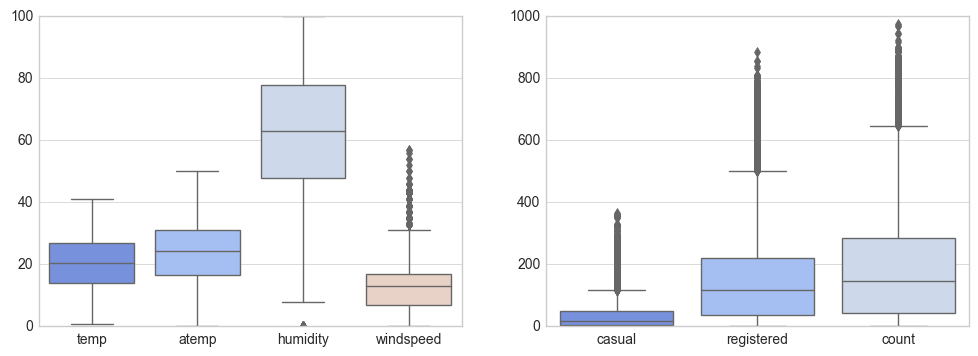

In [20]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(12,4))
sns.boxplot(data=all_no_dummy[continuous_var], ax=ax1)
sns.boxplot(data=all_no_dummy[all_no_dummy['train'] == 1][dependent_variables], ax=ax2)

** Let's find out what is distribution curves for dependent variables. Most of the current machine learning algorithmics performs best on normally distributed data. Pure distribution of depednent variables look more to be Poisson than Gaussian. Log transformation can helps a lot in converting data to normal-like distribution but BoxCox method do the best job by automatically detect proportion (lambda) of log and sqrt transformation. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

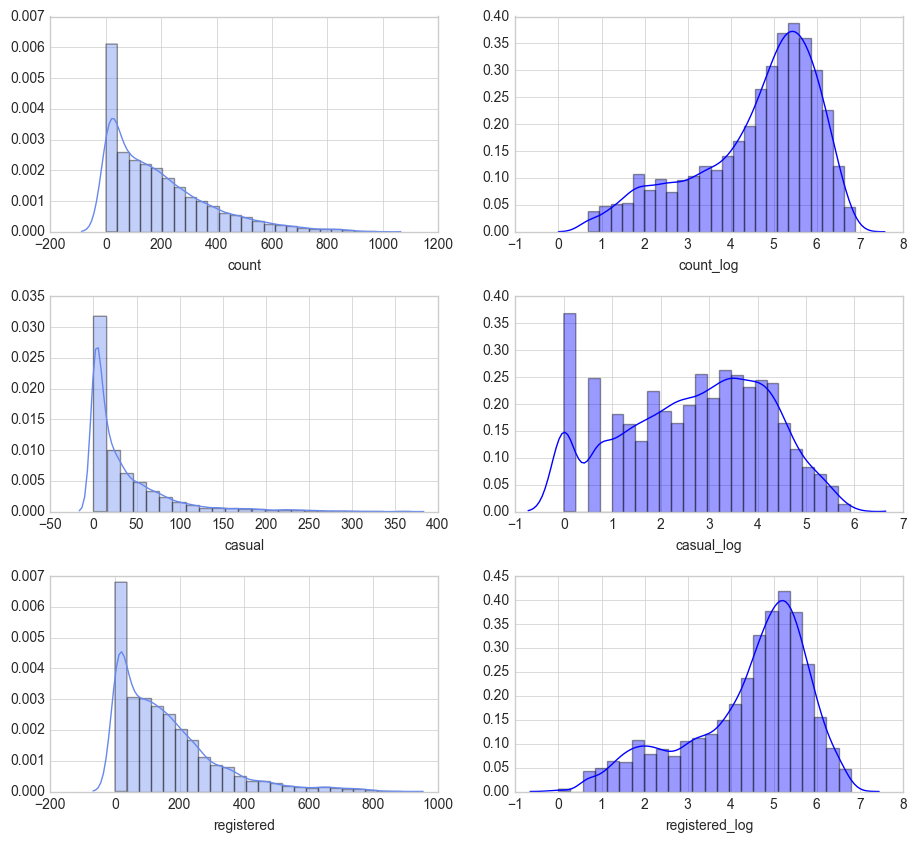

In [21]:
fig,axes= plt.subplots(nrows=3, ncols=2, figsize=(11,10))

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['count'], bins = 24, ax=axes[0][0])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['count_log'], bins = 24, ax=axes[0][1], color='blue')
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['casual'], bins = 24, ax=axes[1][0])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['casual_log'], bins = 24, ax=axes[1][1], color='blue')
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['registered'], bins = 24, ax=axes[2][0])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['registered_log'], bins = 24, ax=axes[2][1], color='blue')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** We can see that LOG distribution looks more normal-like but it's clearly skewed. BoxCox helps us deal with it. But first let's examine raw data divided into 8 hour categories. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


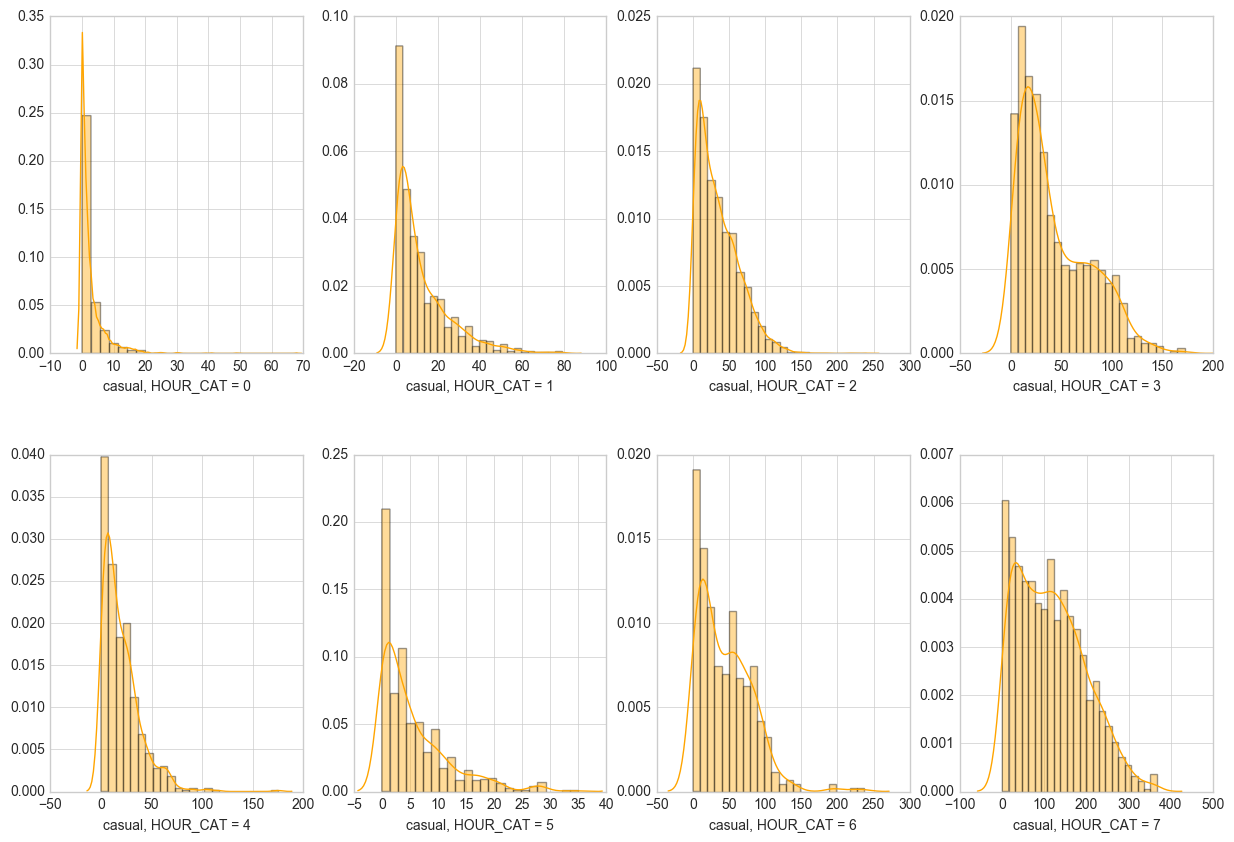

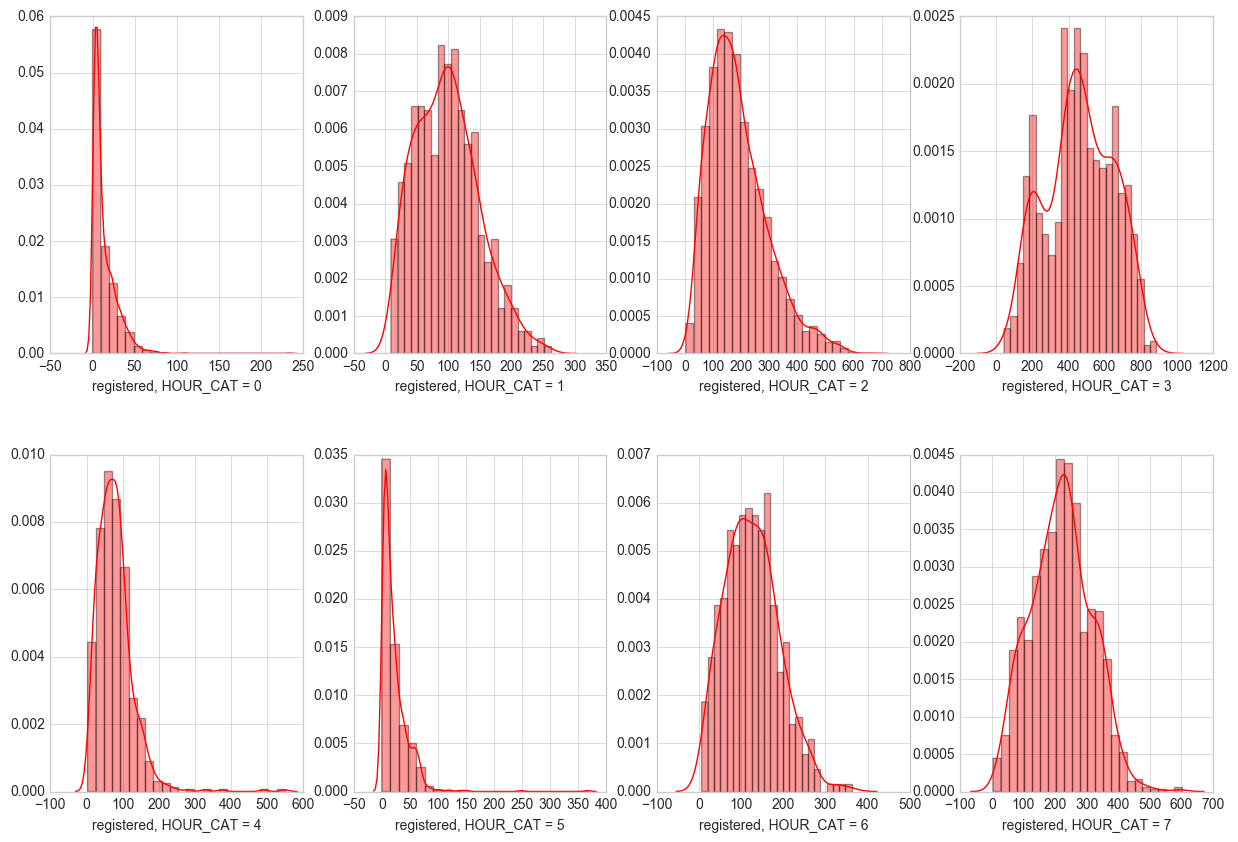

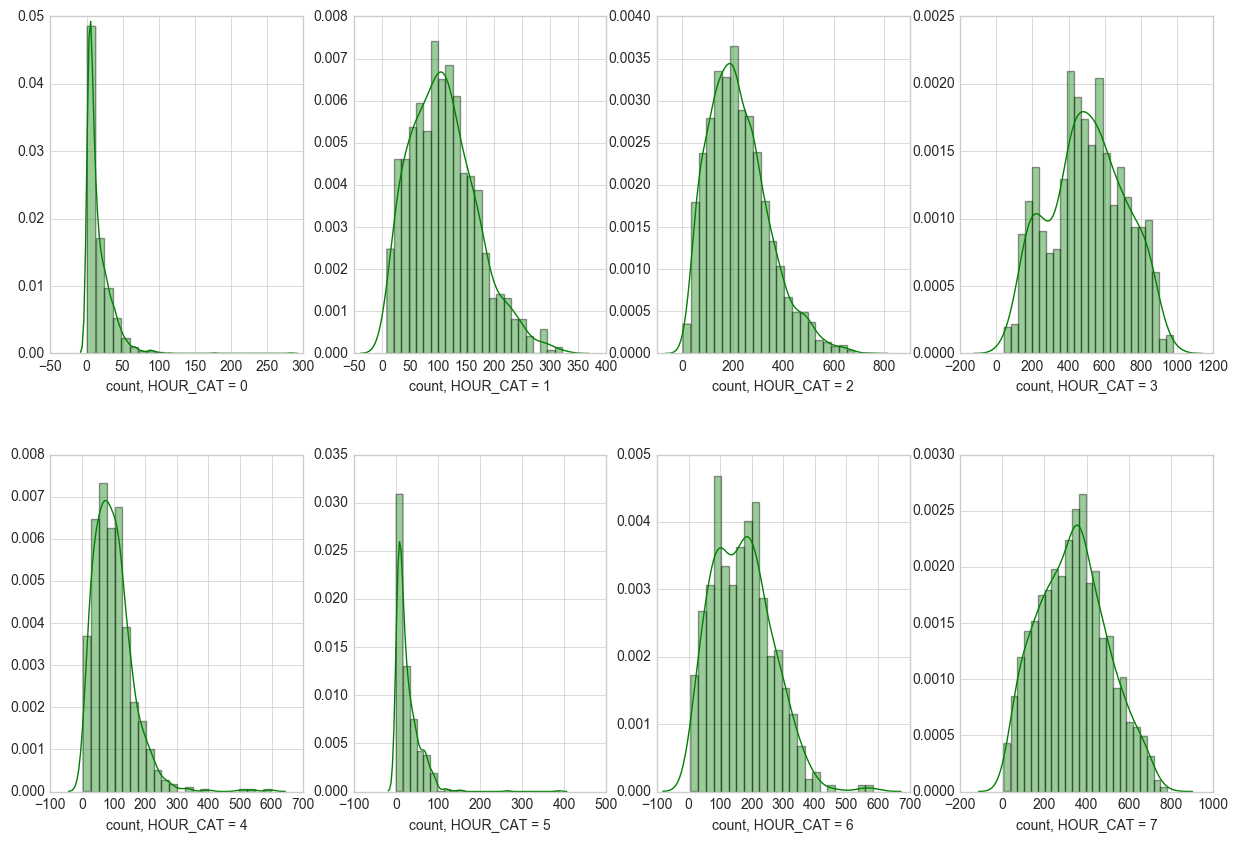

In [22]:
for label in dependent_variables:
    color='orange'
    fig,axes= plt.subplots(nrows=2, ncols=4, figsize=(15,10)) 
    
    if (label == 'registered'): color='red'
    elif (label == 'count'): color='green'
        
    for col in range(0,8):
        sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == col) & (all_no_dummy['train'] == 1)][label], bins = 24, ax=axes[(col // 4)][(col % 4)], axlabel=label + ', HOUR_CAT = ' + str(col),color=color)

    plt.subplots_adjust(hspace = 0.3)
    plt.tight_layout


** Data are highly skewed. It's time to use explore BoxCox transformation. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


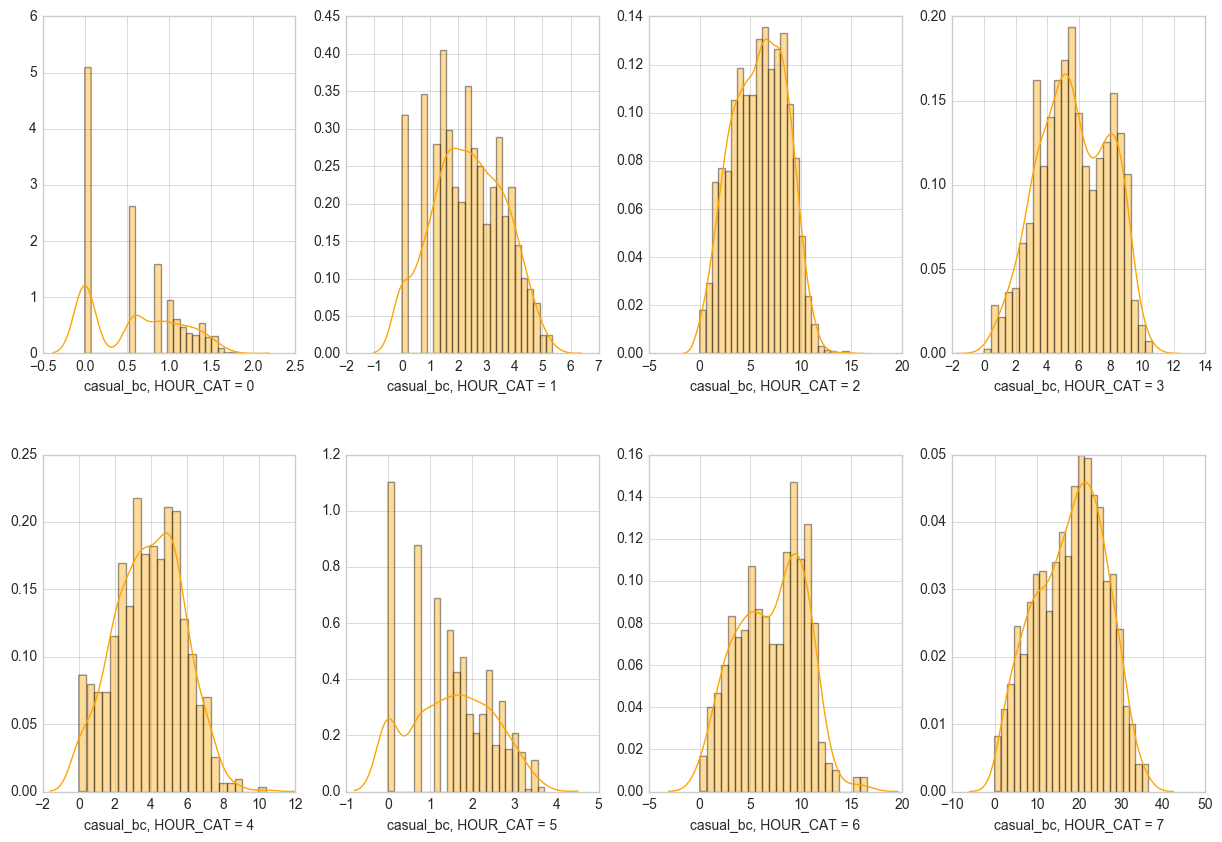

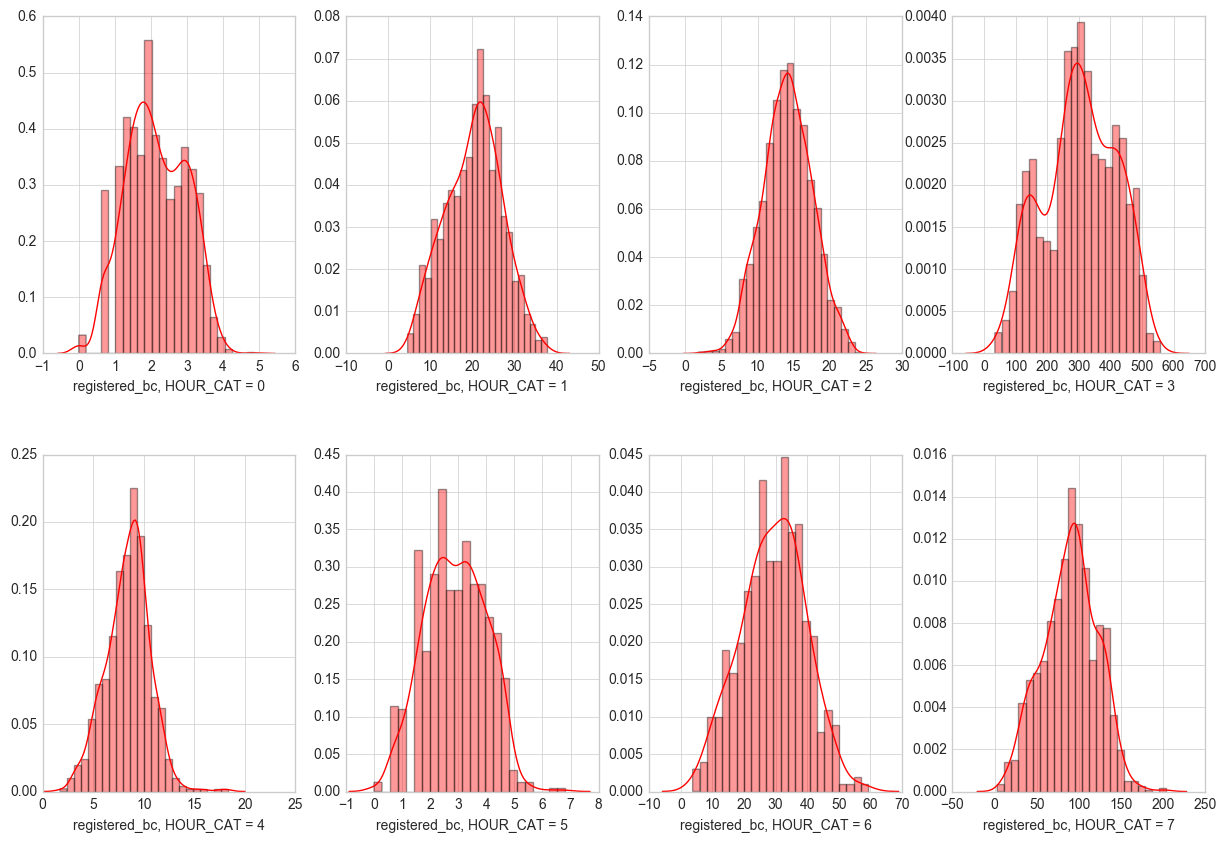

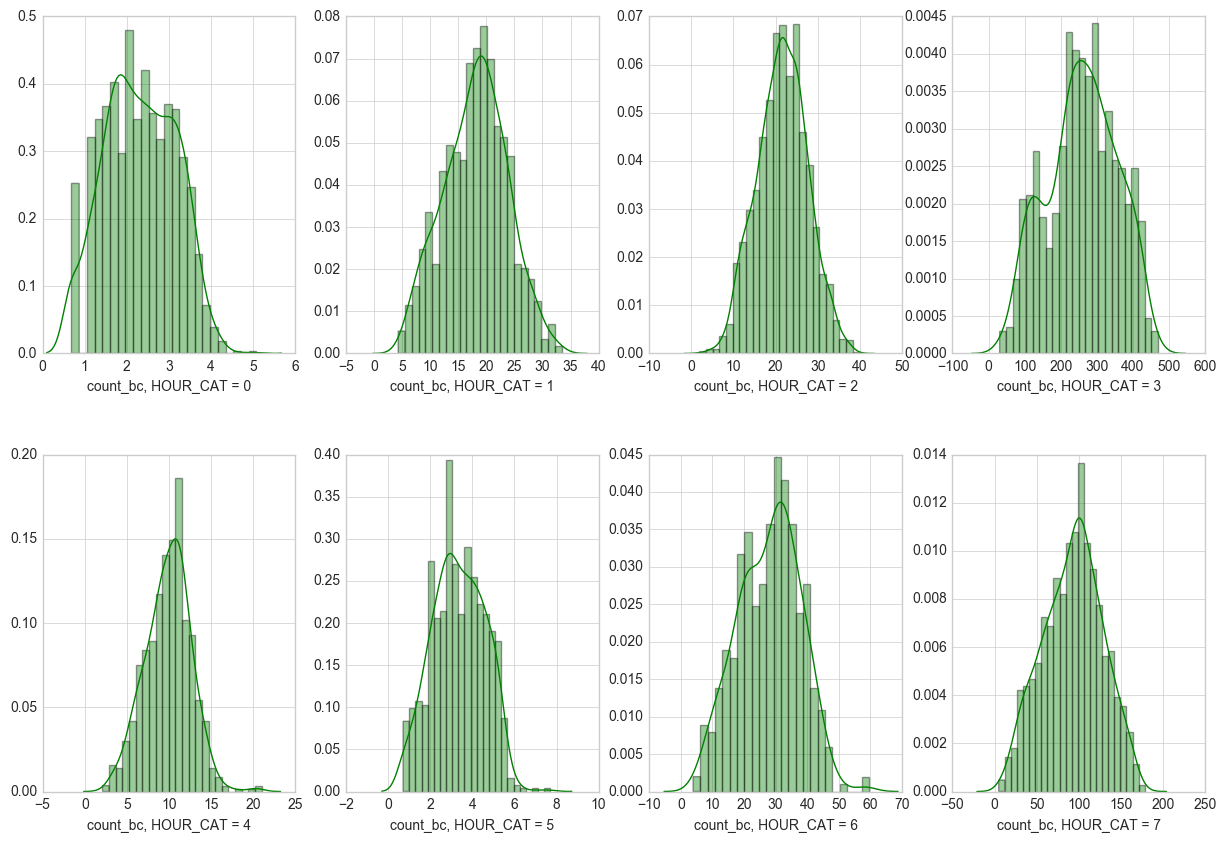

In [23]:
for label in dependent_variables_bc:
    color='orange'
    fig,axes= plt.subplots(nrows=2, ncols=4, figsize=(15,10)) 
    
    if (label == 'registered_bc'): color='red'
    elif (label == 'count_bc'): color='green'
        
    for col in range(0,8):
        sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == col) & (all_no_dummy['train'] == 1)][label], bins = 24, ax=axes[(col // 4)][(col % 4)], axlabel=label + ', HOUR_CAT = ' + str(col),color=color)

    plt.subplots_adjust(hspace = 0.3)
    plt.tight_layout

** Right now only casual rental in hour_cat = 0 (from 0 a.m to 5 a.m., wd=1) and  hour_cat = 5 (from 22 p.m till 1 a.m and 8 a.m., wd=0) are skewed toward zero. Rest of the distributions look good. Let's test those distribution with Kolmogorov-Smirnov Test. P-Value above 0.05 will reject distribution as to be Gaussian one. **

In [24]:
for col in dependent_variables_bc:
    print("Kolmogorov-Smirnov Test for " + col)
    for hour_cat in hour_cat_list:
        print("Hour_cat " + str(hour_cat) + ": " + str(kstest(all_no_dummy[(all_no_dummy['hour_cat'] == hour_cat) & (all_no_dummy['train'] == 1)][col], 'norm')))
    print()

Kolmogorov-Smirnov Test for casual_bc
Hour_cat 0: KstestResult(statistic=0.5, pvalue=0.0)
Hour_cat 1: KstestResult(statistic=0.72754768800143976, pvalue=0.0)
Hour_cat 2: KstestResult(statistic=0.9101667421145383, pvalue=0.0)
Hour_cat 3: KstestResult(statistic=0.93692244959745252, pvalue=0.0)
Hour_cat 4: KstestResult(statistic=0.8469627623153978, pvalue=0.0)
Hour_cat 5: KstestResult(statistic=0.58719220033360342, pvalue=0.0)
Hour_cat 6: KstestResult(statistic=0.92367570457725046, pvalue=0.0)
Hour_cat 7: KstestResult(statistic=0.97607449934301471, pvalue=0.0)

Kolmogorov-Smirnov Test for registered_bc
Hour_cat 0: KstestResult(statistic=0.79283159693523464, pvalue=0.0)
Hour_cat 1: KstestResult(statistic=0.9999984154048952, pvalue=0.0)
Hour_cat 2: KstestResult(statistic=0.99897668737497292, pvalue=0.0)
Hour_cat 3: KstestResult(statistic=1.0, pvalue=0.0)
Hour_cat 4: KstestResult(statistic=0.99516149073150539, pvalue=0.0)
Hour_cat 5: KstestResult(statistic=0.85682293788125341, pvalue=0.0)
Ho

** All distribution passed test, let's find out what is skew for those distributions. The closer to zero the better. **

In [25]:
for col in dependent_variables:
    print("Distribution skew for " + col)
    for hour_cat in hour_cat_list:
        print("Hour_cat " + str(hour_cat) + ": " + str(skew(all_no_dummy[(all_no_dummy['hour_cat'] == hour_cat) & (all_no_dummy['train'] == 1)]['%s_bc' % col])))
    print()

Distribution skew for casual
Hour_cat 0: 0.1849198617641591
Hour_cat 1: -0.022572133741303464
Hour_cat 2: -0.08382844539619586
Hour_cat 3: -0.06554385523563276
Hour_cat 4: -0.040899392343741924
Hour_cat 5: -0.005803802554652065
Hour_cat 6: -0.11320174855345098
Hour_cat 7: -0.16709471438049048

Distribution skew for registered
Hour_cat 0: 0.009540923397725082
Hour_cat 1: -0.06844633747664534
Hour_cat 2: -0.011692128054024899
Hour_cat 3: -0.14275517123713855
Hour_cat 4: 0.03736952136934285
Hour_cat 5: -0.006962353141723
Hour_cat 6: -0.057967027230075886
Hour_cat 7: -0.07666935378133982

Distribution skew for count
Hour_cat 0: 0.008899615897019117
Hour_cat 1: -0.05253121392161439
Hour_cat 2: -0.02663350298296574
Hour_cat 3: -0.13172823100251507
Hour_cat 4: 0.015764837123118415
Hour_cat 5: -0.015689688141390965
Hour_cat 6: -0.07011468213131312
Hour_cat 7: -0.11132562296304664



** Let's compare those results skews with raw data. **

In [26]:
for col in dependent_variables:
    print("Distribution skew for " + col)
    for hour_cat in hour_cat_list:
        print("Hour_cat " + str(hour_cat) + ": " + str(skew(all_no_dummy[(all_no_dummy['hour_cat'] == hour_cat) & (all_no_dummy['train'] == 1)][col])))
    print()

Distribution skew for casual
Hour_cat 0: 4.551863733919366
Hour_cat 1: 1.7667770492729298
Hour_cat 2: 1.1453291761737274
Hour_cat 3: 0.9180986639483172
Hour_cat 4: 2.0449180625230805
Hour_cat 5: 1.6469654009738062
Hour_cat 6: 1.2281598819699528
Hour_cat 7: 0.5510602544523615

Distribution skew for registered
Hour_cat 0: 3.3606865124639005
Hour_cat 1: 0.47705636068077545
Hour_cat 2: 0.9473286991693681
Hour_cat 3: -0.07814560595890273
Hour_cat 4: 2.751384076807352
Hour_cat 5: 4.998036642365348
Hour_cat 6: 0.4857399990663066
Hour_cat 7: 0.1682106786781937

Distribution skew for count
Hour_cat 0: 3.7119397937361978
Hour_cat 1: 0.6340011817611155
Hour_cat 2: 0.7772212384896129
Hour_cat 3: -0.023460746274495414
Hour_cat 4: 2.0924300030691043
Hour_cat 5: 3.7939819089649207
Hour_cat 6: 0.6067382311428698
Hour_cat 7: 0.19651490543262187



** Looks like we did big improvement. Good work. **

### Let's dive deeper into each continuous variable
** Explore data of daily average of one hour bike rentals across all years 2011 and 2012. Sliding windows is of interval 7 days for dependent variables and 3 days for continuous independent variables. Default threshold is set to 75 percentage change computed as (a-b)/b. ** 

In [27]:
outliers = {}

def plot_with_window(column, dataset=all_no_dummy,  all=True, threshold=75):   
    if (all):
        day_avg = 3
        data = dataset
        data_window_mean = data.rolling(window=day_avg * 24).mean()
        data_window_std = data.rolling(window=day_avg * 24).std()
        title = column + ' over time'
        
    else:
        day_avg = 7
        data = dataset[all_no_dummy['train'] == 1].groupby(['year','month','day']).mean()
        data_window_mean = data.rolling(window=day_avg).mean()
        data_window_std = data.rolling(window=day_avg).std()
        title = 'Daily mean of ' + column + ' over time'
    
    diff = np.abs(data[column] - data_window_mean[column])
    # diff for outliers candidates has to be at least above threshold % to avoid false outliers
    outliers = diff[(diff > 3 * data_window_std[column]) & (diff > threshold)]

    plt.figure(figsize=(9,4))
    data[column].plot()
    data_window_mean[column].plot(label=str(day_avg) + ' Day Avg', lw=1, ls='--', c='red')
    
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    
    
    return outliers

In [28]:
def unique_outliers(col_list):
    outliers_list = []
    for col in col_list:
        for timestamp in outliers[col].index:
            outliers_list.append(timestamp)
    return sorted(list(set(outliers_list)))

** Characterics of casual renting is very changeable with many positive peaks. **

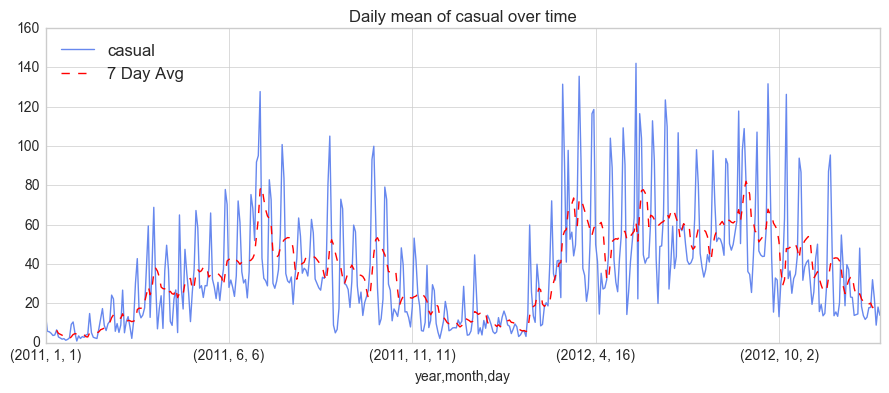

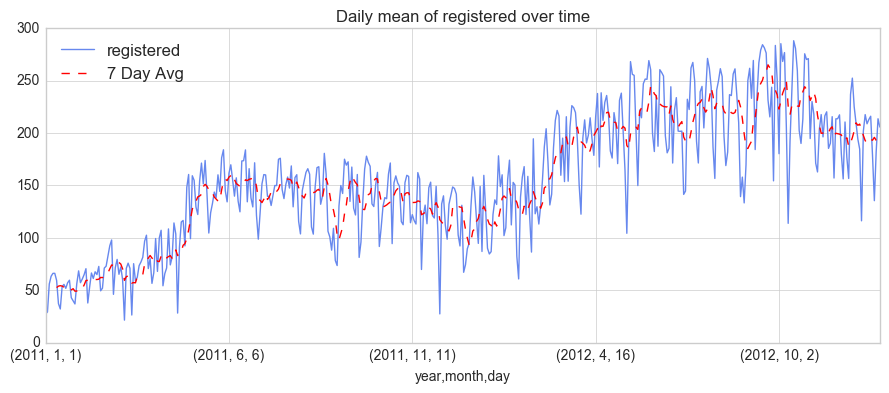

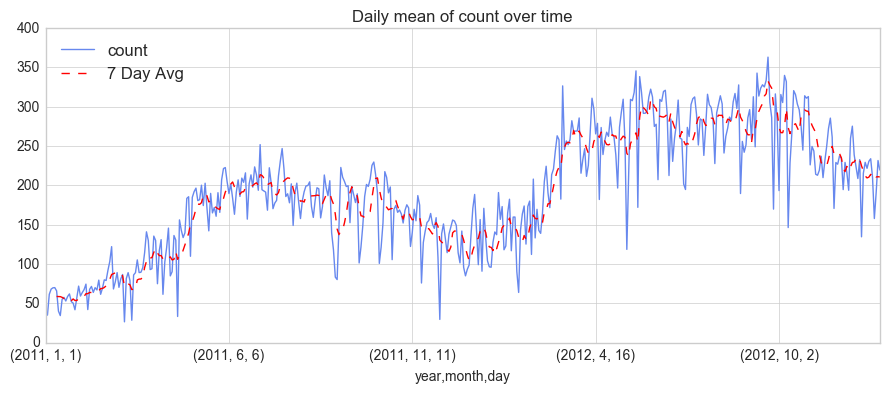

In [29]:
for col in dependent_variables: 
    outliers[col] = plot_with_window(col, all=False)

** Plot for registred users looks almost the same becouse on average about 80% of total rentals are made be registered users. **

In [30]:
all_no_dummy[all_no_dummy['train'] == 1][['casual', 'registered', 'count']].describe().ix['mean']

casual         36.021955
registered    155.552177
count         191.574132
Name: mean, dtype: float64

** Thera are no outliers for dependent variables (by our criteria). **

In [31]:
all_no_dummy.ix[unique_outliers(dependent_variables)]

Empty DataFrame
Columns: [atemp, casual, count, holiday, humidity, registered, season, temp, weather, windspeed, workingday, year, month, day, hour, dayofweek, weekofyear, season_cat, month_cat, dayofweek_cat, weather_cat, quarter, bike_season, temp_prev_hour_change_pct, temp_prev_day_change_pct, atemp_prev_hour_change_pct, atemp_prev_day_change_pct, humidity_prev_hour_change_pct, humidity_prev_day_change_pct, windspeed_prev_hour_change_pct, windspeed_prev_day_change_pct, weather_prev_hour_change_pct, weather_prev_day_change_pct, atemp_temp_diff, temp_cat, hour_cat, train, casual_log, casual_bc, casual_cat, registered_log, registered_bc, registered_cat, count_log, count_bc, count_cat]
Index: []

** Let's find out whether there are some weather data outliers. **

In [32]:
temp_var_list = ['temp',
            'temp_prev_hour_change_pct',
            'temp_prev_day_change_pct']

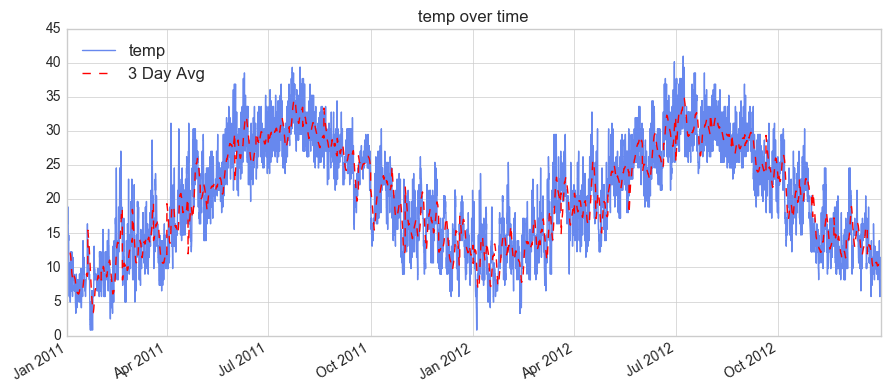

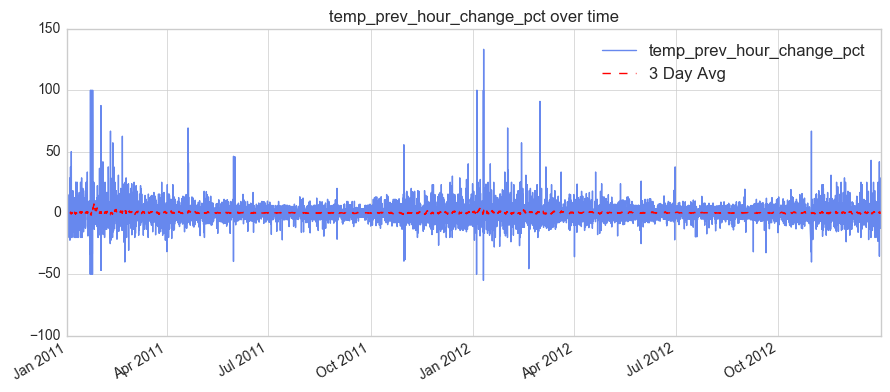

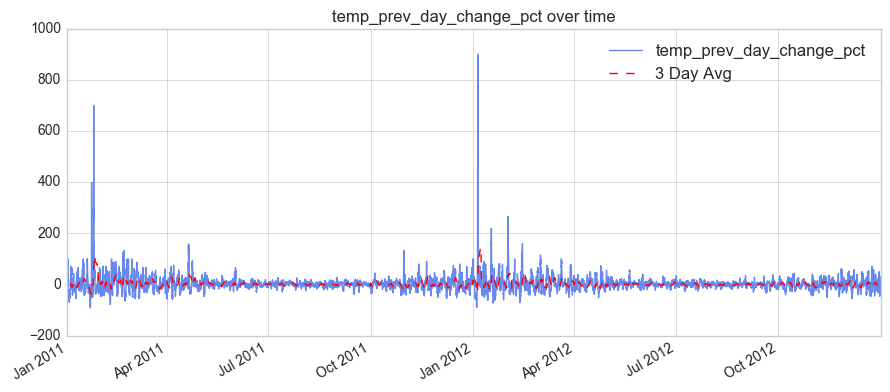

In [33]:
for col in temp_var_list: 
    outliers[col] = plot_with_window(col)

** Some of the outliers below. **

In [34]:
all_no_dummy.ix[unique_outliers(temp_var_list), temp_var_list].head()

temp  temp_prev_hour_change_pct  \
2011-01-15 19:00:00  13.12                   6.666667   
2011-01-15 21:00:00  13.12                   0.000000   
2011-01-22 09:00:00   1.64                 100.000000   
2011-01-23 05:00:00   1.64                 100.000000   
2011-01-23 06:00:00   1.64                   0.000000   

                     temp_prev_day_change_pct  
2011-01-15 19:00:00                     100.0  
2011-01-15 21:00:00                     100.0  
2011-01-22 09:00:00                     -80.0  
2011-01-23 05:00:00                       0.0  
2011-01-23 06:00:00                     100.0

In [35]:
atemp_var_list = ['atemp',
            'atemp_prev_hour_change_pct',
            'atemp_prev_day_change_pct']

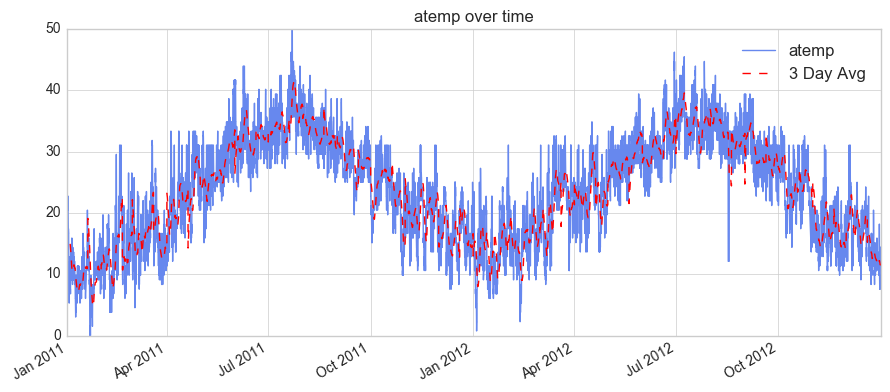

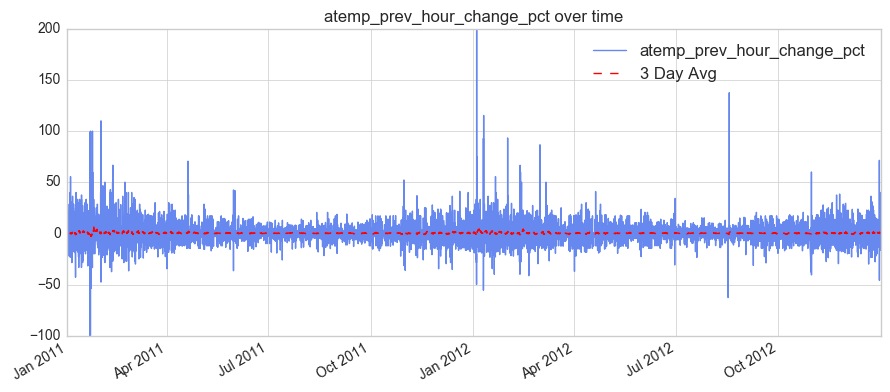

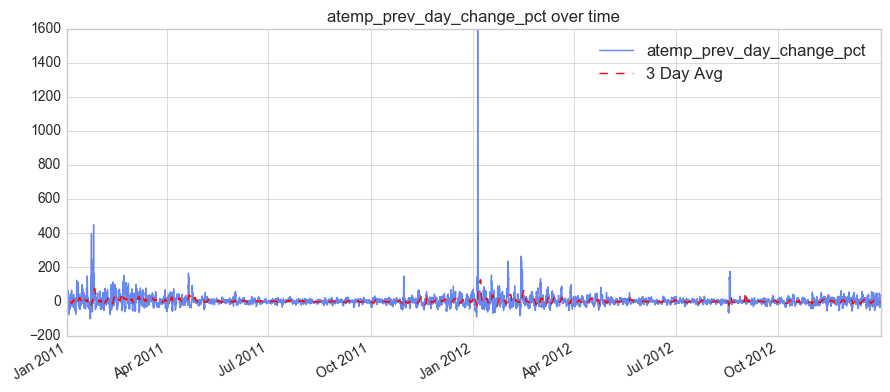

In [36]:
for col in atemp_var_list: 
    outliers[col] = plot_with_window(col)

In [37]:
all_no_dummy.ix[unique_outliers(atemp_var_list)][atemp_var_list].head()

atemp  atemp_prev_hour_change_pct  \
2011-01-09 23:00:00   6.820                   12.541254   
2011-01-10 01:00:00   6.060                    0.000000   
2011-01-14 22:00:00  11.365                    0.000000   
2011-01-14 23:00:00  12.120                    6.643203   
2011-01-19 11:00:00  15.150                   11.111111   

                     atemp_prev_day_change_pct  
2011-01-09 23:00:00                 125.082508  
2011-01-10 01:00:00                 100.000000  
2011-01-14 22:00:00                  87.541254  
2011-01-14 23:00:00                 100.000000  
2011-01-19 11:00:00                 150.000000

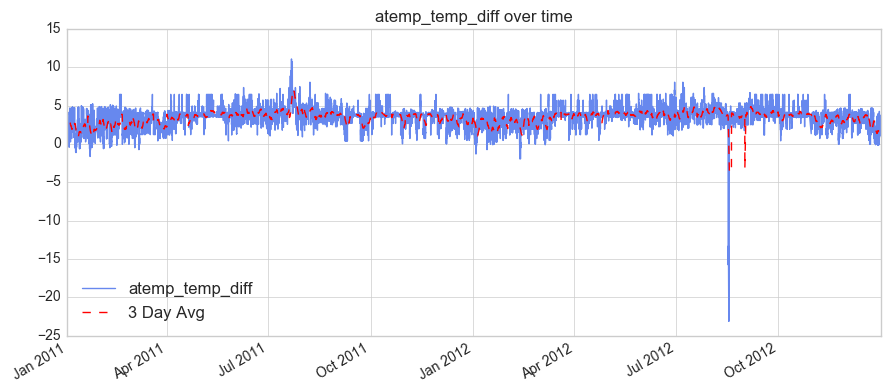

In [38]:
outliers['atemp_temp_diff'] = plot_with_window('atemp_temp_diff', threshold=10)

In [39]:
all_no_dummy.ix[unique_outliers(['atemp_temp_diff'])]['atemp_temp_diff'].head()

2012-08-17 00:00:00   -15.76
2012-08-17 01:00:00   -14.94
2012-08-17 02:00:00   -14.94
2012-08-17 03:00:00   -14.12
2012-08-17 04:00:00   -14.12
Name: atemp_temp_diff, dtype: float64

** We can see one clear outlier in humidity. During minium day for count variable (2011, 3, 6), humidity had one of its highest value. It matches our understanding - there are fewer bike rentals during rain. On (2011, 3, 10) humidity has zero daily mean value although in adjacent days there was high value for humidity. It looks like some missing values. **

In [40]:
all_no_dummy.groupby(['year','month','day']).mean().idxmin()

atemp                              (2011, 1, 22)
casual                             (2011, 1, 20)
count                              (2011, 1, 20)
holiday                             (2011, 1, 1)
humidity                           (2011, 3, 10)
registered                         (2011, 1, 20)
season                              (2011, 1, 1)
temp                               (2011, 1, 22)
weather                             (2011, 1, 3)
windspeed                          (2011, 10, 7)
workingday                          (2011, 1, 1)
hour                              (2012, 10, 29)
dayofweek                           (2011, 1, 3)
weekofyear                          (2011, 1, 3)
quarter                             (2011, 1, 1)
bike_season                         (2011, 1, 1)
temp_prev_hour_change_pct          (2011, 1, 21)
temp_prev_day_change_pct           (2011, 1, 22)
atemp_prev_hour_change_pct         (2012, 2, 11)
atemp_prev_day_change_pct          (2012, 8, 17)
humidity_prev_hour_c

In [41]:
humidity_var_list = ['humidity',
            'humidity_prev_hour_change_pct',
            'humidity_prev_day_change_pct']

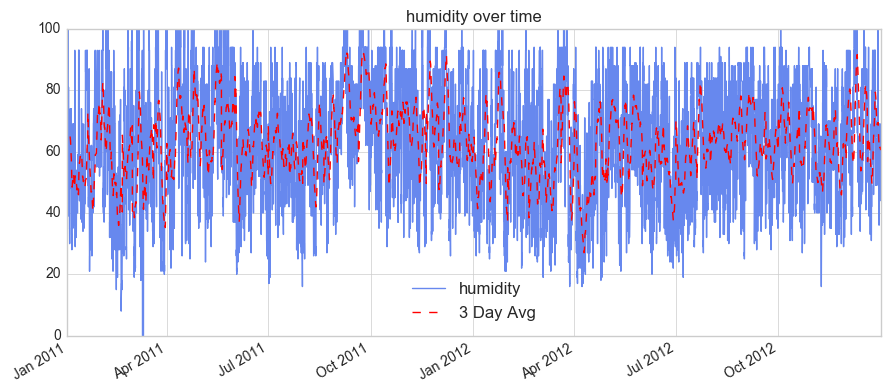

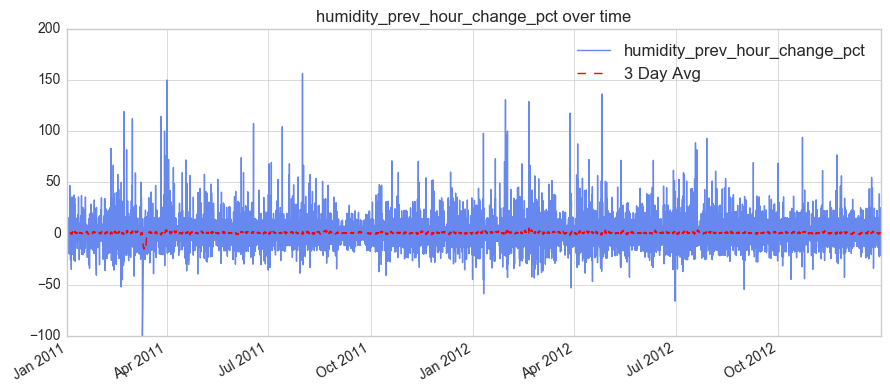

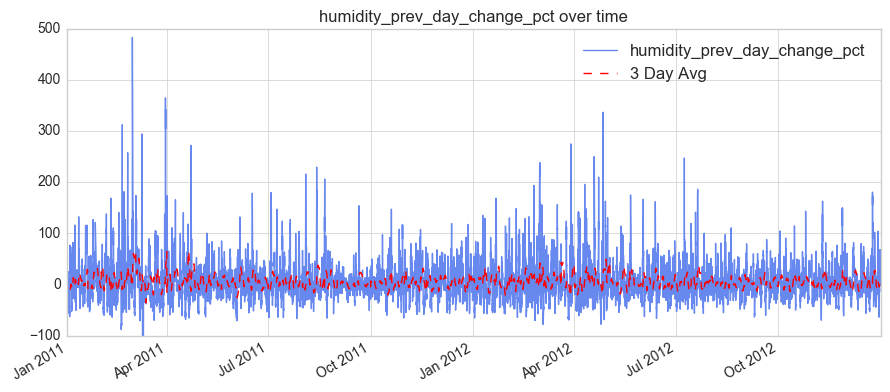

In [42]:
for col in humidity_var_list: 
    outliers[col] = plot_with_window(col)

In [43]:
all_no_dummy.ix[unique_outliers(humidity_var_list)][humidity_var_list].head()

humidity  humidity_prev_hour_change_pct  \
2011-01-08 09:00:00        93                       0.000000   
2011-01-08 10:00:00        80                     -13.978495   
2011-01-11 15:00:00        80                      35.593220   
2011-01-11 16:00:00        86                       7.500000   
2011-01-11 17:00:00        86                       0.000000   

                     humidity_prev_day_change_pct  
2011-01-08 09:00:00                     97.872340  
2011-01-08 10:00:00                    116.216216  
2011-01-11 15:00:00                    100.000000  
2011-01-11 16:00:00                    115.000000  
2011-01-11 17:00:00                    115.000000

** Windspeed becouse of its nature has very inregular characteriscs but in a way it has some stable mean level. Looks like this variable doesn't add value for our predictive models. **

In [44]:
windspeed_var_list = ['windspeed',
            'windspeed_prev_hour_change_pct',
            'windspeed_prev_day_change_pct']

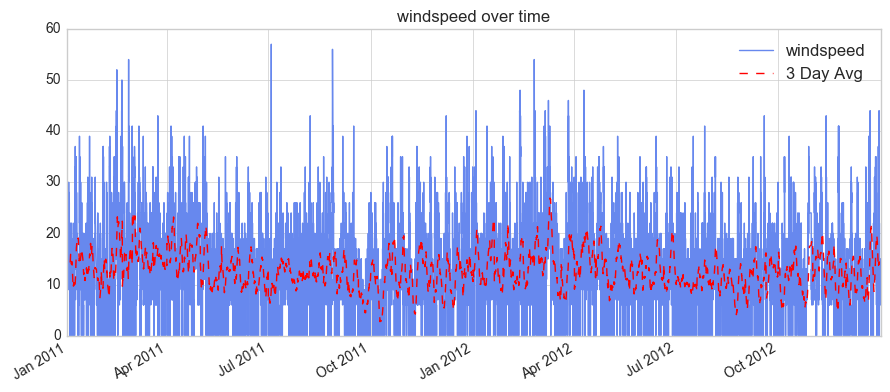

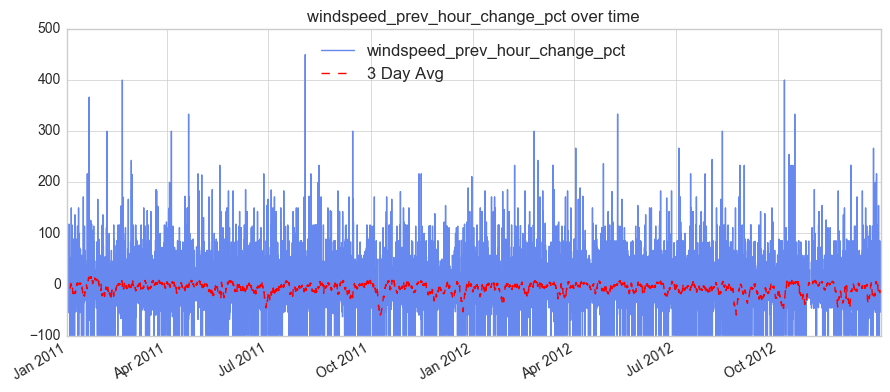

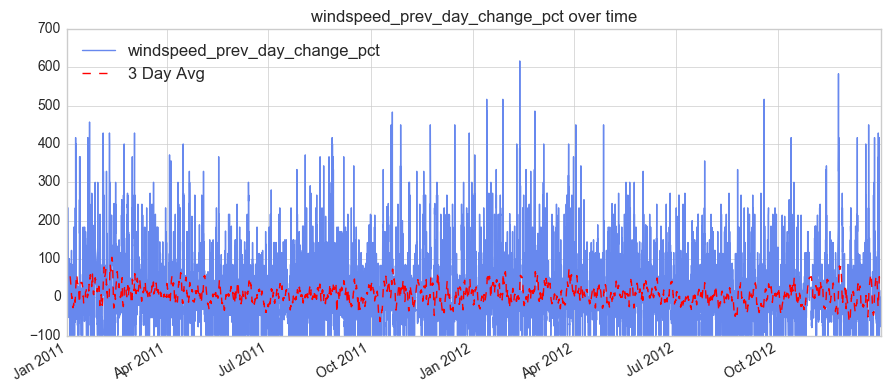

In [45]:
for col in windspeed_var_list: 
    outliers[col] = plot_with_window(col)

In [46]:
all_no_dummy.ix[unique_outliers(windspeed_var_list)][windspeed_var_list].head()

windspeed  windspeed_prev_hour_change_pct  \
2011-01-05 04:00:00    15.0013                      149.888393   
2011-01-09 01:00:00    31.0009                       19.221850   
2011-01-09 09:00:00    35.0008                       84.203103   
2011-01-11 16:00:00    15.0013                      149.888393   
2011-01-12 12:00:00    39.0007                       49.987117   

                     windspeed_prev_day_change_pct  
2011-01-05 04:00:00                      66.716307  
2011-01-09 01:00:00                     416.406250  
2011-01-09 09:00:00                     399.904306  
2011-01-11 16:00:00                       0.000000  
2011-01-12 12:00:00                     254.506699

### There are 808 values beyond our threshold in total. Let's interpolate them. 

In [47]:
len(unique_outliers(humidity_var_list + temp_var_list + atemp_var_list + windspeed_var_list + ['atemp_temp_diff']))

808

In [48]:
def interpolate_data(dataset):
    data = dataset.copy()
    for col_list in [humidity_var_list] + [temp_var_list] + [atemp_var_list] + [windspeed_var_list]:
        for col in col_list:
            for timestamp in outliers[col].index:
                data.loc[timestamp, col_list] = np.NaN
    
    # avoid first row NaN 
    data.iloc[0] = data.iloc[0].fillna(data.mean())
    data = data.interpolate(method='time')
    # after interpolating continuous varialbes we must recompute derivated variables
    data = set_derivated_vars(data)
    data = set_temp_cat(data)
    return data

In [49]:
all_no_dummy_interpolate = interpolate_data(all_no_dummy.copy())

** Difference between original and interpolated data. **

In [50]:
(all_no_dummy != all_no_dummy_interpolate).sum()

atemp                               76
casual                               0
count                                0
holiday                              0
humidity                           253
registered                           0
season                               0
temp                                65
weather                              0
windspeed                          440
workingday                           0
year                                 0
month                                0
day                                  0
hour                                 0
dayofweek                            0
weekofyear                           0
season_cat                           0
month_cat                            0
dayofweek_cat                        0
weather_cat                          0
quarter                              0
bike_season                          0
temp_prev_hour_change_pct           97
temp_prev_day_change_pct           152
atemp_prev_hour_change_pc

** Some exmaple: **

** 2012-01-10 05:00:00  - there were outliers for temp (16.40) and atemp (20.46). Those values were interpolated to (12.77) and (15.26) respectively. **

In [51]:
all_no_dummy.loc[('2012-01-10 02:00:00'):('2012-01-10 07:00:00')][['temp', 'atemp']]

temp   atemp
2012-01-10 02:00:00   9.02  11.365
2012-01-10 04:00:00   8.20  10.605
2012-01-10 05:00:00  16.40  20.455
2012-01-10 06:00:00   7.38   9.090
2012-01-10 07:00:00   7.38   9.850

In [52]:
all_no_dummy_interpolate.ix[('2012-01-10 02:00:00'):('2012-01-10 07:00:00')][['temp', 'atemp']]

temp      atemp
2012-01-10 02:00:00   9.020000  11.365000
2012-01-10 04:00:00   8.200000  10.605000
2012-01-10 05:00:00  12.768315  15.260241
2012-01-10 06:00:00   7.380000   9.090000
2012-01-10 07:00:00   7.380000   9.850000

___
** From the boxplot below its clear most bike rentals are  in hours: 8, 17, 18. We should expect that regular registred users rent bikes in those hours becouse there are almost no outliers. Between those hours there are hours with many outliers. We should expect that more casual users rent bikes in those hours  **

<function matplotlib.pyplot.tight_layout>

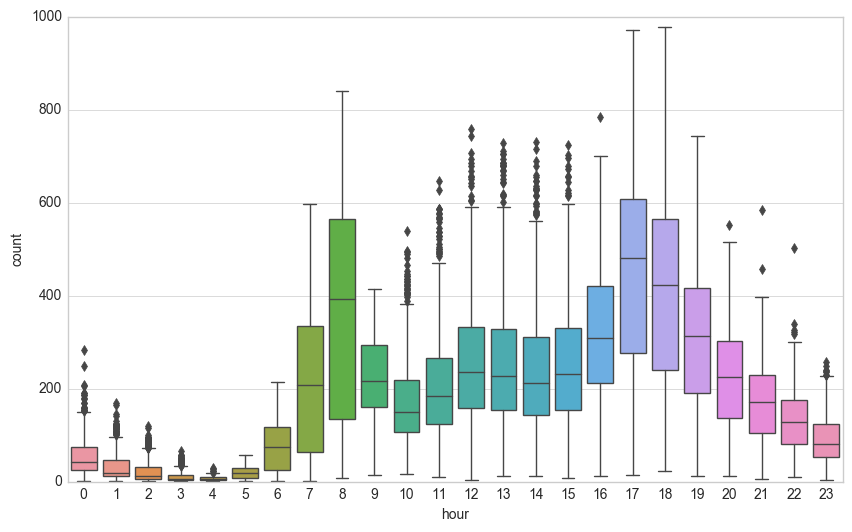

In [53]:
plt.figure(figsize=(10,6))
sns.boxplot(x="hour", y="count", data=all_no_dummy[all_no_dummy['train'] == 1])
plt.tight_layout

** On the plots below we can see rentals distribution for specifc month. Druing summer there are most demand for bikes. During all season hour-rental characteristics have the same shape: for working days thera are two peaks on 8 and 17-18 hours. Casual users rent bike usually between those hours as well as during weekends. **

<function matplotlib.pyplot.tight_layout>

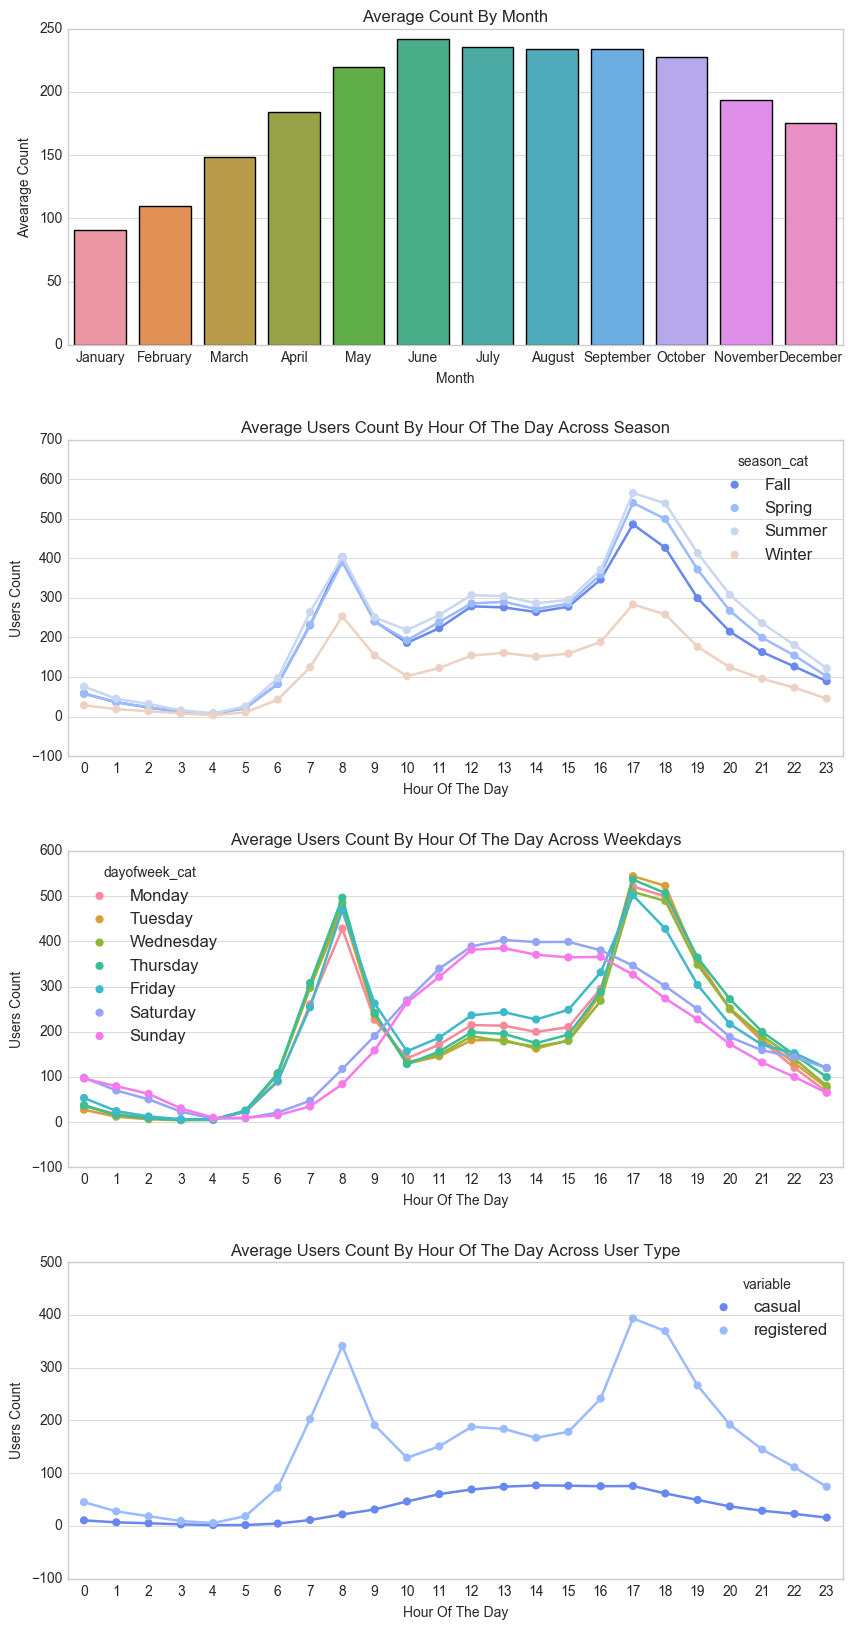

In [54]:
# below code is taken from https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4, figsize=(10,20))
#fig.set_size_inches(12,15)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

monthAggregated = pd.DataFrame(all_no_dummy[all_no_dummy['train'] == 1].groupby("month_cat")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month_cat",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(all_no_dummy[all_no_dummy['train'] == 1].groupby(["hour","season_cat"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season_cat"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(all_no_dummy[all_no_dummy['train'] == 1].groupby(["hour","dayofweek_cat"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["dayofweek_cat"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(all_no_dummy[all_no_dummy['train'] == 1][["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** There are not clear linear relationships between variables, besides dependent variables (casual, registerd, count) themselves and temp - atemp.  It indicates that machine learning regression algorithms that can handle non-linearity could perfom better than linear regression or there is a need to divide data into more linear parts.** 

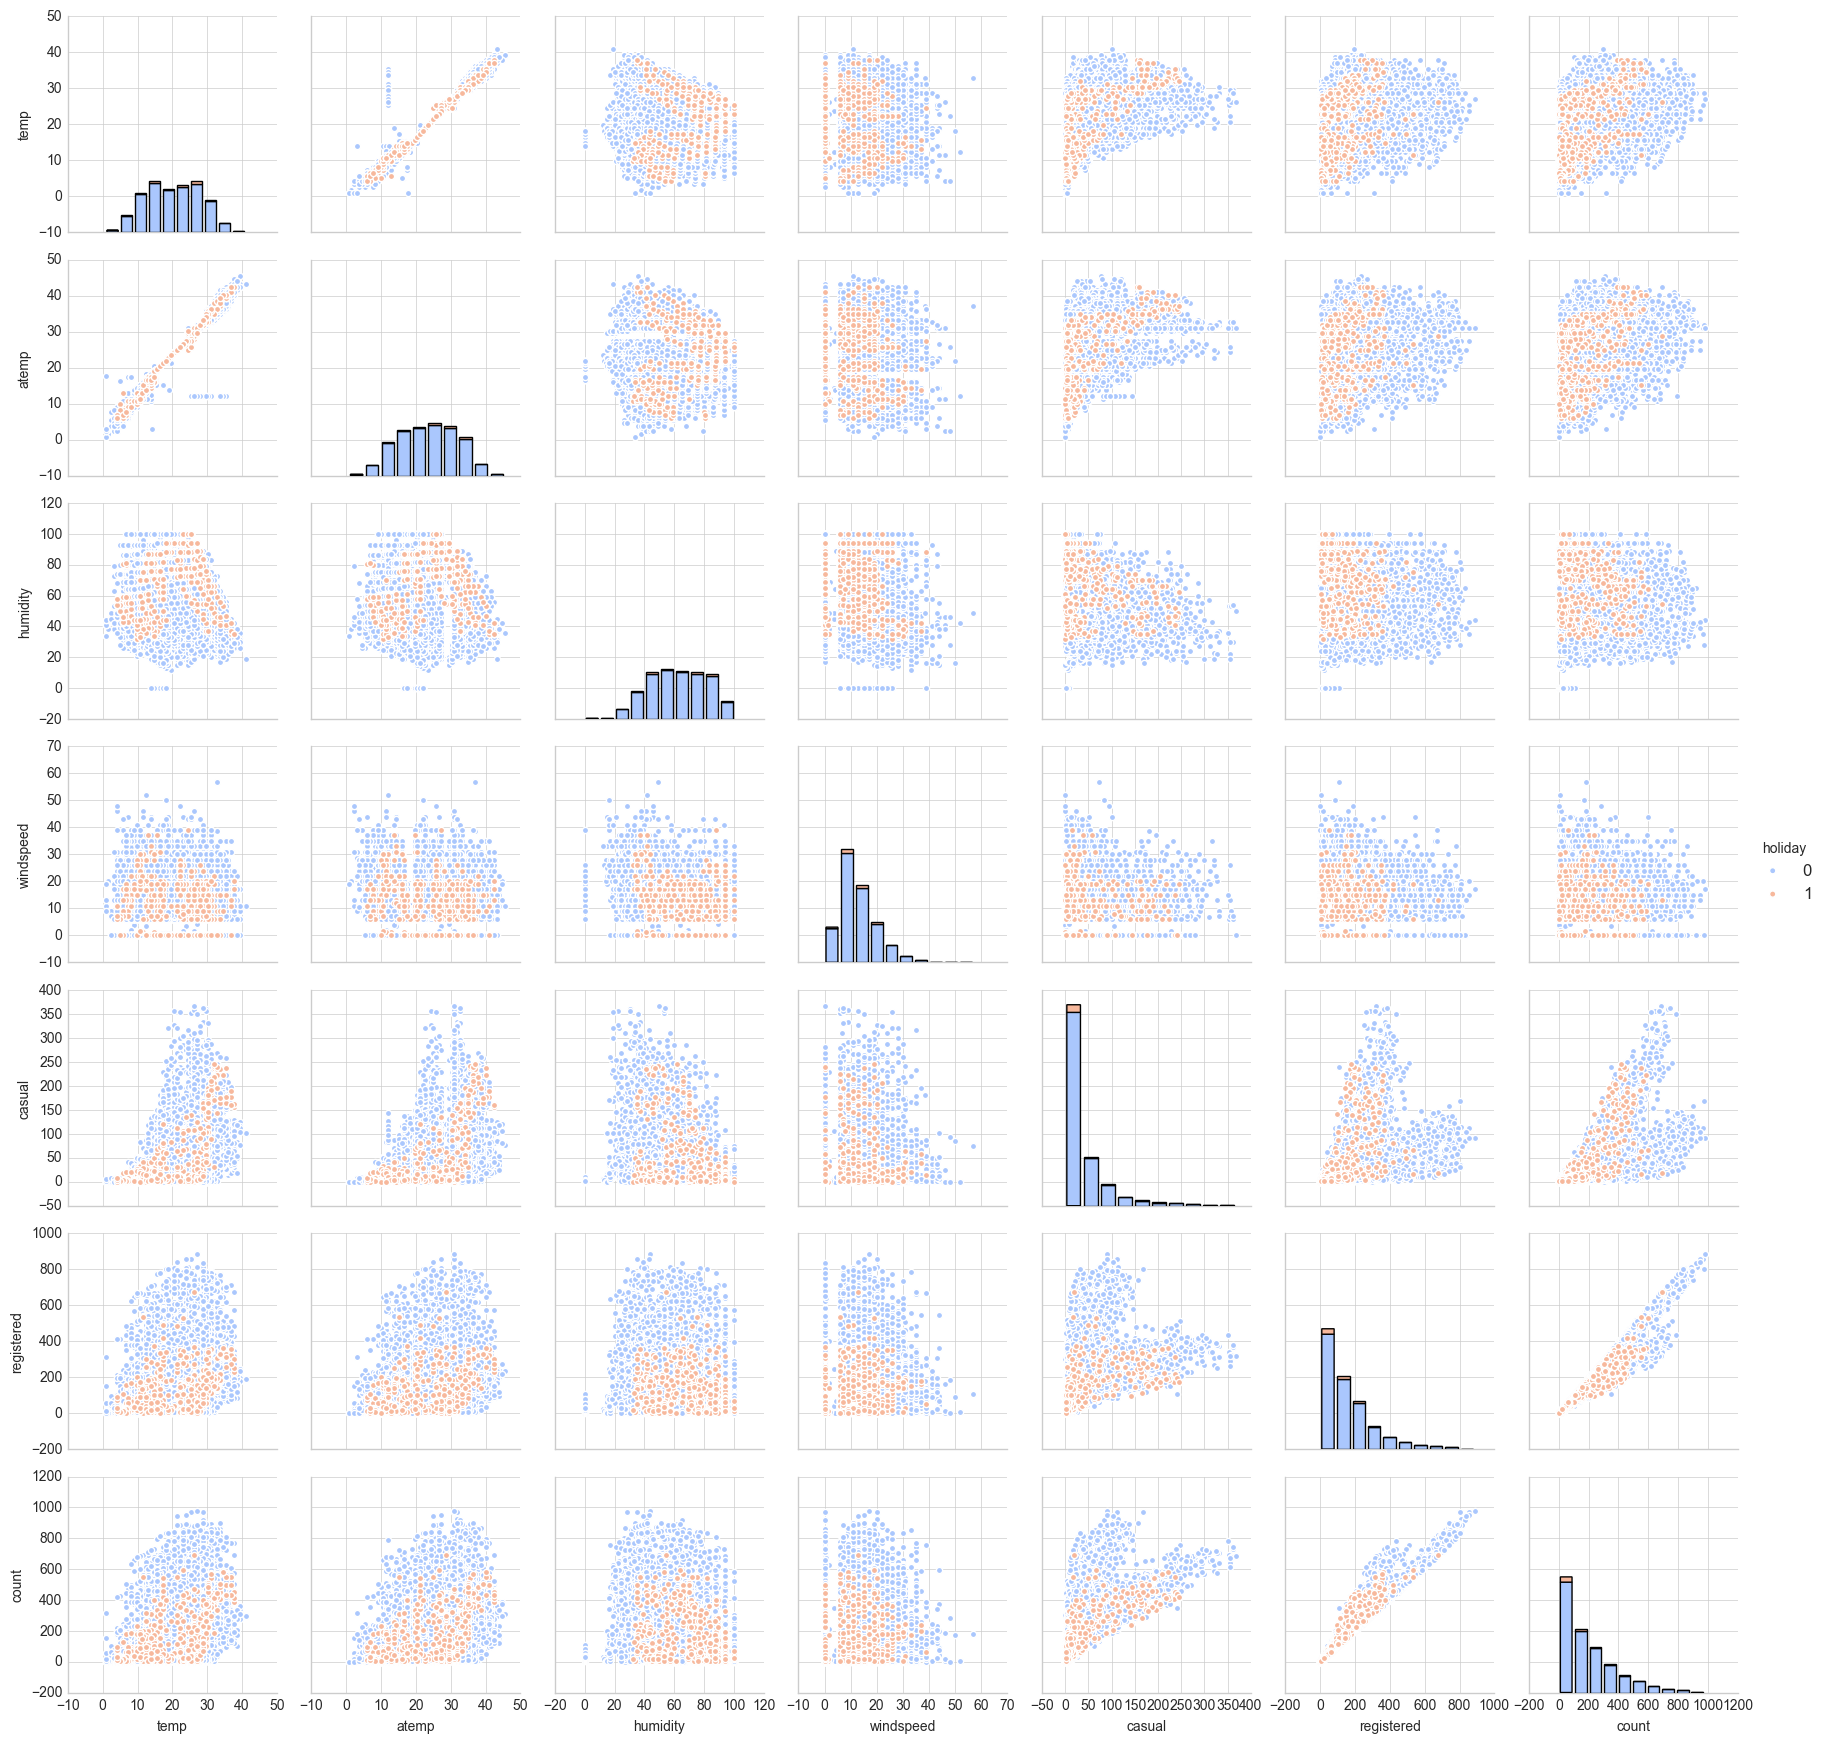

In [55]:
sns.pairplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], vars=continuous_var + dependent_variables, hue='holiday', palette='coolwarm')

** There is some correlation (showed on some next cells on heatmap) between casual and registred users rentals. **

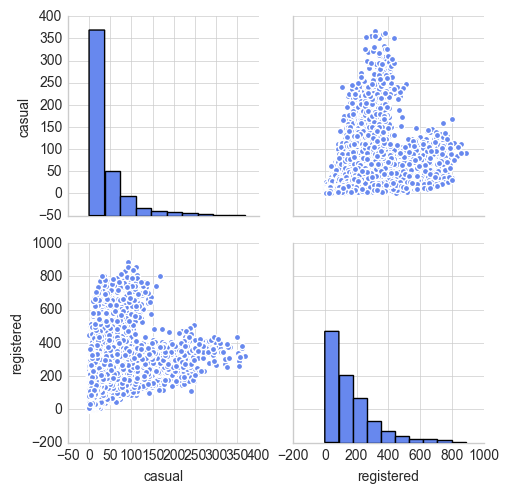

In [56]:
sns.pairplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], vars=['casual', 'registered'], palette='coolwarm')

** It's clear linear relationships between temperature in Celsius and "feels like" temperature in Celsius'. We should probably drop one of them to avoid <a href='https://en.wikipedia.org/wiki/Multicollinearity'> multicollinearity </a> or use ensebled methods. **

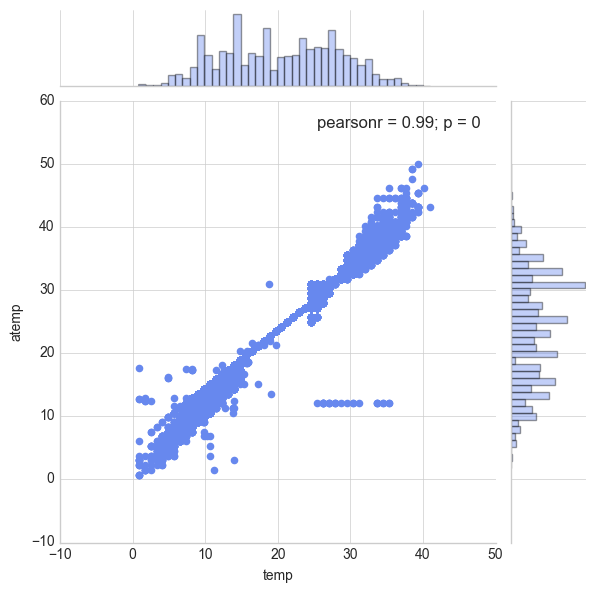

In [57]:
sns.jointplot(x='temp',y='atemp',data=all_no_dummy_interpolate)

** There are potentially 25 outliers where absolute difference between temperature in Celsius and "feels like" temperature in Celsius is greater than 10 Celsius degree. We can build another linear regression model to predict atemp for those outliers. But taking into account fact, there are only 24 records, we just simply interpolate atemp_temp_diff variable for those records.** 

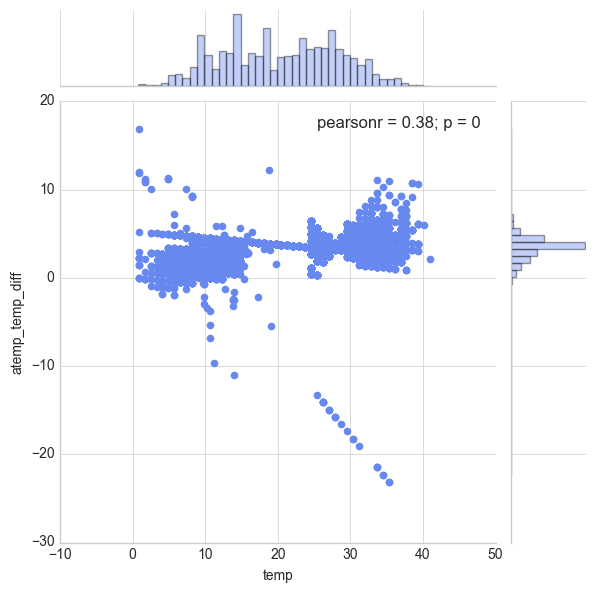

In [58]:
sns.jointplot(x='temp',y='atemp_temp_diff',data=all_no_dummy_interpolate)

In [59]:
all_no_dummy_interpolate[all_no_dummy_interpolate['atemp_temp_diff'] < -10][continuous_var + ['atemp_temp_diff']]

temp  atemp  humidity  windspeed  atemp_temp_diff
2012-01-04 09:00:00  14.024333   3.03      45.0   8.998100       -10.994333
2012-08-17 00:00:00  27.880000  12.12      57.0  11.001400       -15.760000
2012-08-17 01:00:00  27.060000  12.12      65.0   7.001500       -14.940000
2012-08-17 02:00:00  27.060000  12.12      61.0   8.998100       -14.940000
2012-08-17 03:00:00  26.240000  12.12      65.0   7.001500       -14.120000
2012-08-17 04:00:00  26.240000  12.12      73.0  11.001400       -14.120000
2012-08-17 05:00:00  26.240000  12.12      73.0   7.001500       -14.120000
2012-08-17 06:00:00  25.420000  12.12      78.0   8.998100       -13.300000
2012-08-17 07:00:00  26.240000  12.12      73.0   7.001500       -14.120000
2012-08-17 08:00:00  27.880000  12.12      65.0   8.998100       -15.760000
2012-08-17 09:00:00  28.700000  12.12      58.0   7.001500       -16.580000
2012-08-17 10:00:00  30.340000  12.12      55.0  11.001400       -18.220000
2012-08-17 11:00:00  31.160000  12.12      52.0   7.535404       -19.040000
2012-08-17 12:00:00  33.620000  12.12      41.0  15.001300       -21.500000
2012-08-17 13:00:00  34.440000  12.12      36.0  26.002700       -22.320000
2012-08-17 14:00:00  35.260000  12.12      34.0  27.999300       -23.140000
2012-08-17 15:00:00  35.260000  12.12      30.0  31.000900       -23.140000
2012-08-17 16:00:00  34.440000  12.12      32.0  30.002600       -22.320000
2012-08-17 17:00:00  33.620000  12.12      36.0  22.002800       -21.500000
2012-08-17 18:00:00  33.620000  12.12      38.0  16.997900       -21.500000
2012-08-17 19:00:00  30.340000  12.12      55.0   7.465383       -18.220000
2012-08-17 20:00:00  29.520000  12.12      58.0  15.001300       -17.400000
2012-08-17 21:00:00  27.880000  12.12      69.0  19.999500       -15.760000
2012-08-17 22:00:00  27.060000  12.12      83.0  12.998000       -14.940000
2012-08-17 23:00:00  26.240000  12.12      83.0  15.001300       -14.120000

In [60]:
all_no_dummy_interpolate.loc[all_no_dummy_interpolate['atemp_temp_diff'] < -10 , \
                             ['atemp','atemp_temp_diff']] = np.NaN
all_no_dummy.loc[all_no_dummy['atemp_temp_diff'] < -10 , \
                             ['atemp','atemp_temp_diff']] = np.NaN
all_no_dummy_interpolate = all_no_dummy_interpolate.interpolate(method='time')
all_no_dummy = all_no_dummy.interpolate(method='time')
all_no_dummy_interpolate = set_derivated_vars(all_no_dummy_interpolate)
all_no_dummy = set_derivated_vars(all_no_dummy)

** Right now there are no outliers for atemp_temp_diff variable. **

In [61]:
all_no_dummy_interpolate[all_no_dummy_interpolate['atemp_temp_diff'] < -10][continuous_var + ['atemp_temp_diff']]

Empty DataFrame
Columns: [temp, atemp, humidity, windspeed, atemp_temp_diff]
Index: []

___
### Compare categorical variables distribution across Train and Test datasets

** TRAIN data set - categorical variables. **

<function matplotlib.pyplot.tight_layout>

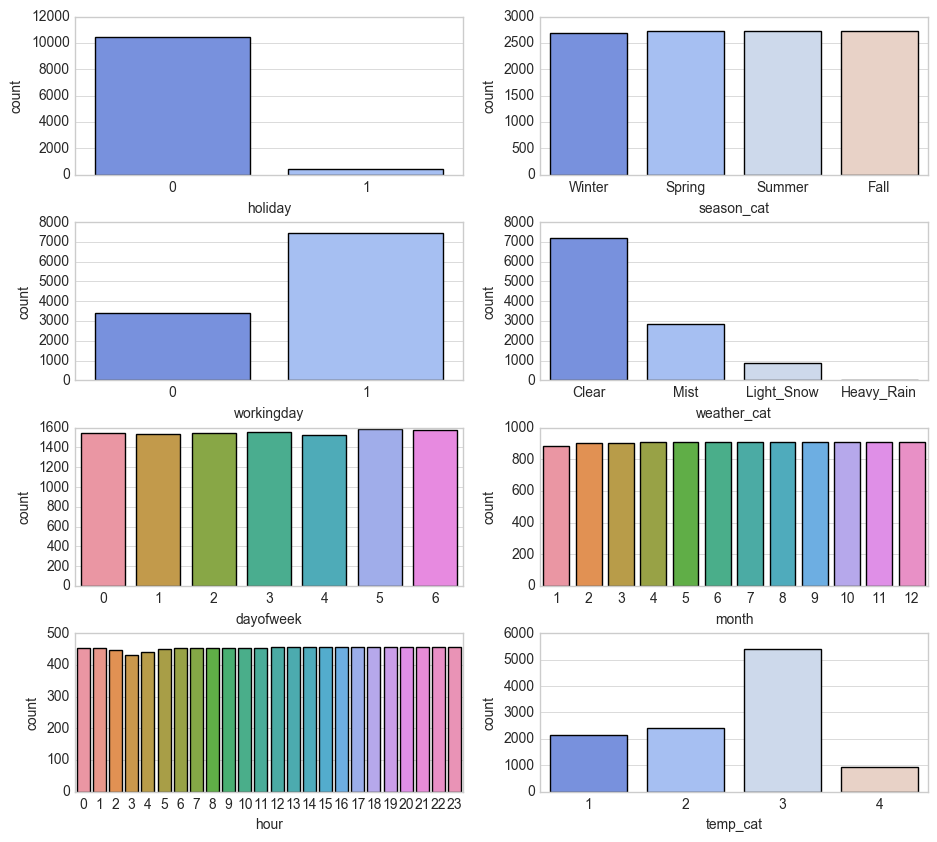

In [62]:
fig,axes= plt.subplots(nrows=4, ncols=2, figsize=(11,10))

sns.countplot(x='holiday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[0][0])
sns.countplot(x='season_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[0][1])
sns.countplot(x='workingday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[1][0])
sns.countplot(x='weather_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[1][1])
sns.countplot(x='dayofweek',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[2][0])
sns.countplot(x='month',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[2][1])
sns.countplot(x='hour',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[3][0])
sns.countplot(x='temp_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[3][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** TEST Kaggle data set - categorical variables. **

<function matplotlib.pyplot.tight_layout>

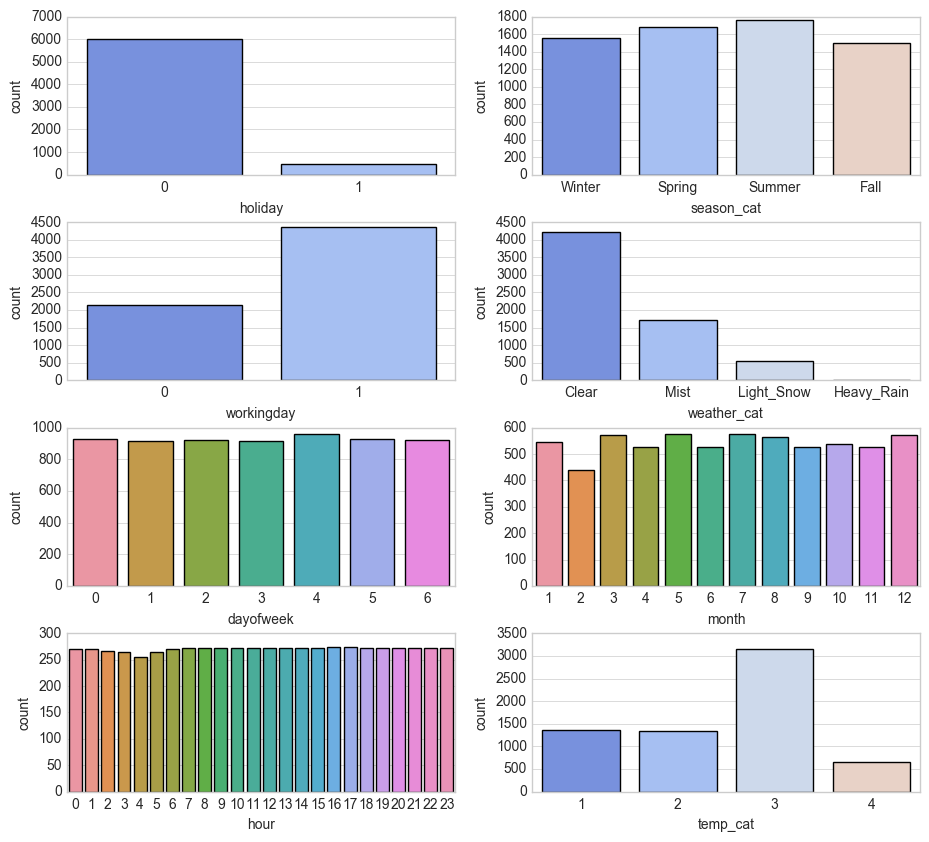

In [63]:
fig,axes= plt.subplots(nrows=4, ncols=2, figsize=(11,10))

sns.countplot(x='holiday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[0][0])
sns.countplot(x='season_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[0][1])
sns.countplot(x='workingday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[1][0])
sns.countplot(x='weather_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[1][1])
sns.countplot(x='dayofweek',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[2][0])
sns.countplot(x='month',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[2][1])
sns.countplot(x='hour',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[3][0])
sns.countplot(x='temp_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[3][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Mainly difference between Train and Test caterogical variables distribution is a smaller amount of rows in February for test data set - it's due to fact in 2011 February had 28 days and in 2012 had 29 days. **

### Compare continuous variables distribution across Train and Test datasets

** TRAIN data set - continuous variables. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

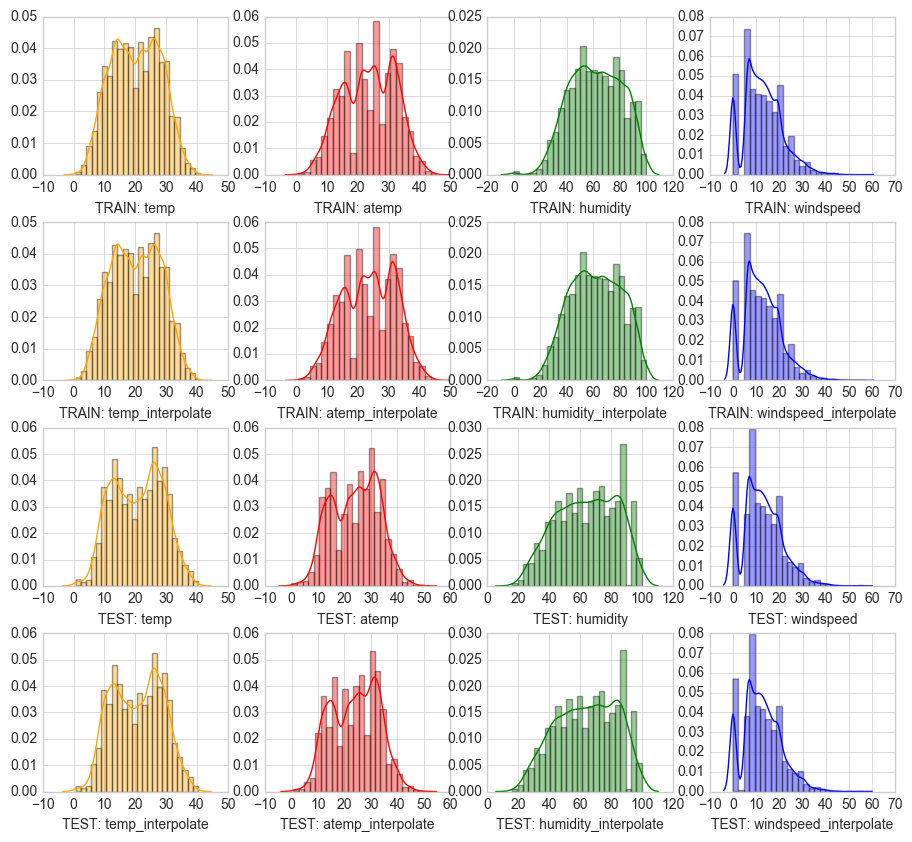

In [64]:
fig,axes= plt.subplots(nrows=4, ncols=4, figsize=(11,10))

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['temp'], bins=24, ax=axes[0][0], axlabel='TRAIN: temp', color='orange')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['temp'], bins=24, ax=axes[1][0], axlabel='TRAIN: temp_interpolate', color='orange')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['temp'], bins=24, ax=axes[2][0], axlabel='TEST: temp', color='orange')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['temp'], bins=24, ax=axes[3][0], axlabel='TEST: temp_interpolate', color='orange')

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['atemp'], bins=24, ax=axes[0][1], axlabel='TRAIN: atemp', color='red')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['atemp'], bins=24, ax=axes[1][1], axlabel='TRAIN: atemp_interpolate', color='red')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['atemp'], bins=24, ax=axes[2][1], axlabel='TEST: atemp', color='red')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['atemp'], bins=24, ax=axes[3][1], axlabel='TEST: atemp_interpolate', color='red')


sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['humidity'], bins=24, ax=axes[0][2], axlabel='TRAIN: humidity', color='green')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['humidity'], bins=24, ax=axes[1][2], axlabel='TRAIN: humidity_interpolate', color='green')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['humidity'], bins=24, ax=axes[2][2], axlabel='TEST: humidity', color='green')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['humidity'], bins=24, ax=axes[3][2], axlabel='TEST: humidity_interpolate', color='green')

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['windspeed'], bins=24, ax=axes[0][3], axlabel='TRAIN: windspeed', color='blue')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['windspeed'], bins=24, ax=axes[1][3], axlabel='TRAIN: windspeed_interpolate', color='blue')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['windspeed'], bins=24, ax=axes[2][3], axlabel='TEST: windspeed', color='blue')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['windspeed'], bins=24, ax=axes[3][3], axlabel='TEST: windspeed_interpolate', color='blue')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** We can see that both TRAIN and TEST data sets have very similar distribution for continuous and nominal variables so overall there is no need to  select specific subset (similar to test data) from training data to train models on. **

___
### Mesure correlation between variables.

In [65]:
all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].corr().ix[dependent_variables]

atemp    casual     count   holiday  humidity  registered  \
casual      0.465058  1.000000  0.690414  0.024455 -0.348001    0.497250   
registered  0.317356  0.497250  0.970948 -0.041725 -0.266291    1.000000   
count       0.392878  0.690414  1.000000 -0.028046 -0.318015    0.970948   

              season      temp   weather  windspeed  workingday      year  \
casual      0.096758  0.467059 -0.135918   0.090095   -0.319864  0.145241   
registered  0.164011  0.318479 -0.109340   0.087790    0.120154  0.264265   
count       0.163439  0.394366 -0.128655   0.098048    0.011965  0.260403   

               month       day      hour  dayofweek  weekofyear   quarter  \
casual      0.092722  0.014109  0.302045   0.246959    0.079906  0.174336   
registered  0.169451  0.019111  0.380540  -0.084427    0.156480  0.311324   
count       0.166862  0.019826  0.400601  -0.002283    0.152512  0.307666   

            bike_season  temp_prev_hour_change_pct  temp_prev_day_change_pct  \
casual         0.286533                   0.029686                 -0.009000   
registered     0.185317                   0.025987                 -0.006274   
count          0.233545                   0.029855                 -0.007714   

            atemp_prev_hour_change_pct  atemp_prev_day_change_pct  \
casual                        0.014970                  -0.004221   
registered                    0.007370                  -0.007802   
count                         0.010274                  -0.007670   

            humidity_prev_hour_change_pct  humidity_prev_day_change_pct  \
casual                          -0.059997                     -0.038709   
registered                      -0.000914                     -0.049257   
count                           -0.017310                     -0.051747   

            windspeed_prev_hour_change_pct  windspeed_prev_day_change_pct  \
casual                            0.016999                      -0.012536   
registered                        0.018445                      -0.003364   
count                             0.020068                      -0.006262   

            weather_prev_hour_change_pct  weather_prev_day_change_pct  \
casual                          0.004343                    -0.081416   
registered                      0.011562                    -0.070839   
count                           0.010838                    -0.081521   

            atemp_temp_diff  temp_cat  hour_cat  train  casual_log  casual_bc  \
casual             0.229730  0.214594  0.522047    NaN    0.780839   0.956054   
registered         0.158248  0.304729  0.218678    NaN    0.629648   0.473509   
count              0.195308  0.313270  0.326317    NaN    0.740363   0.658498   

            casual_cat  registered_log  registered_bc  registered_cat  \
casual        0.604377        0.510717       0.339883        0.303038   
registered    0.424501        0.805086       0.801823        0.606966   
count         0.520641        0.812142       0.762305        0.589670   

            count_log  count_bc  count_cat  
casual       0.579034  0.426681   0.545920  
registered   0.792129  0.829003   0.674728  
count        0.820181  0.808907   0.713158

** Heatmap is better visualisation tool to see some Pearson Correlation. There aren't strong correlations: hour and temp variable have approximately 0.4 Pearson Correlation value. **

<function matplotlib.pyplot.tight_layout>

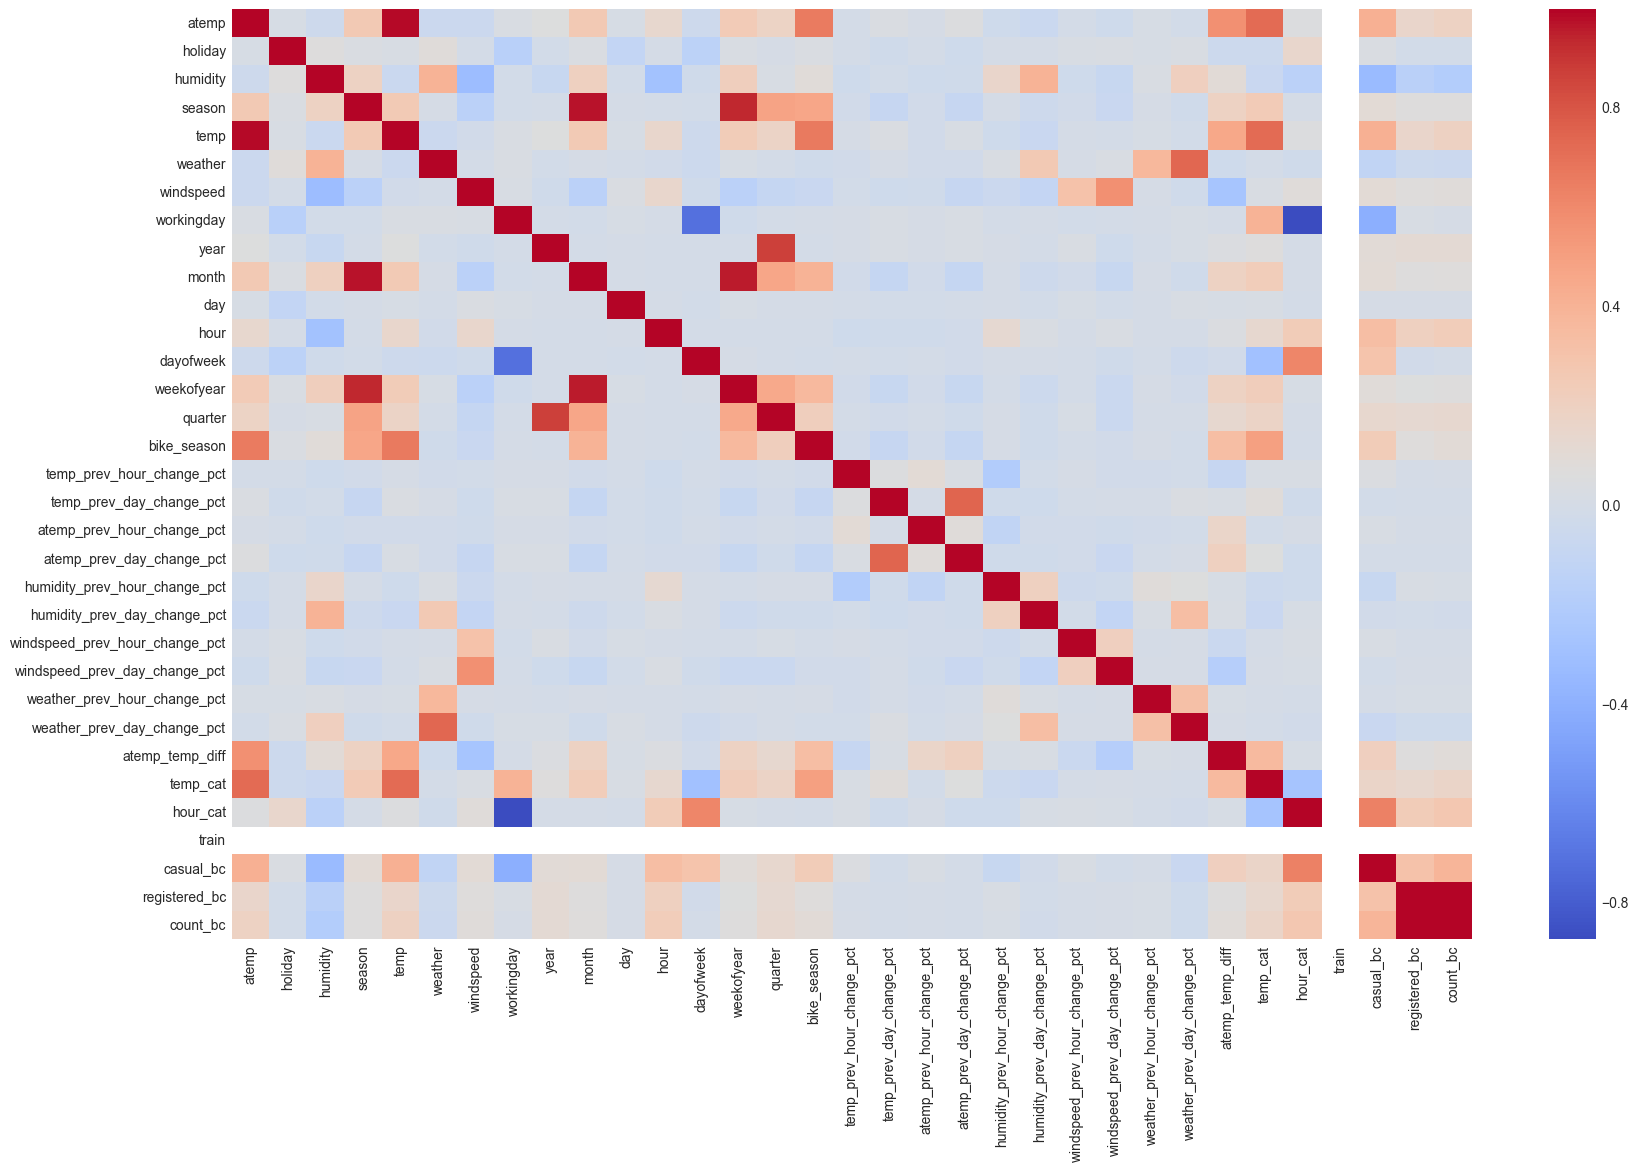

In [66]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].drop(dependent_variables + dependent_variables_cat + dependent_variables_log, axis=1).corr(), annot=False,cmap='coolwarm')
plt.tight_layout

### Let's visualize linear relationships between variables with highest correlations: hour and temp. 

** We can see that linear regression can give us only roughly approximation of total rentals from hour variable. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


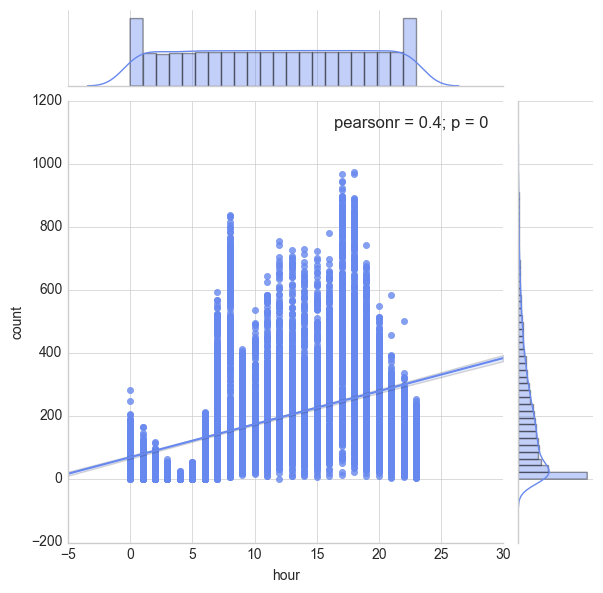

In [67]:
sns.jointplot(x='hour',y='count',kind='reg',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1])

** Temp-Count scatter plot is skewed in right direction which indicates that higher temperature results in higher total bike rentals. But again, we can see it's only roughly approximation. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


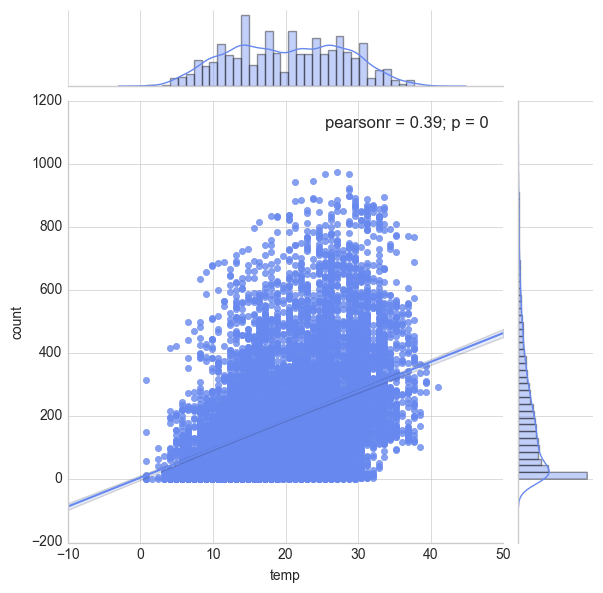

In [68]:
sns.jointplot(x='temp',y='count',kind='reg',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1])

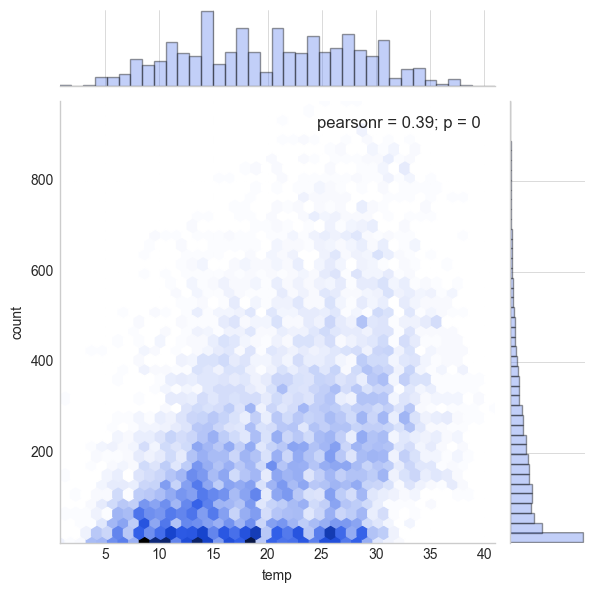

In [69]:
sns.jointplot(x='temp',y='count',kind='hex',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1])

** Let's have a close look on ditribution across different years. **

In [70]:
train_no_dummy_year_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].pivot_table(values='count',index='month',columns='year').rename(index=monthDict)
train_no_dummy_year_piv

year             2011        2012
month                            
January     54.645012  124.353201
February    73.641256  145.646154
March       86.849776  208.276923
April      111.026374  257.455947
May        174.809211  264.109649
June       196.877193  287.186404
July       203.614035  267.037281
August     182.666667  285.570175
September  174.622517  292.598684
October    174.773626  280.508772
November   155.458333  231.980220
December   134.173246  217.054825

** It looks like there are much more rentals in 2012 than in 2011. Perhaps there were more bikes in total to rent in 2012 than in 2011. Another reason could be fact that people got used to rent a bike from Capital BikeShare and there were more registred users in total. **

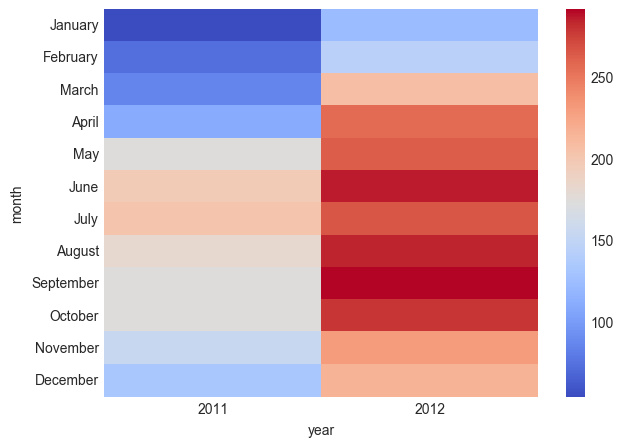

In [71]:
fig = plt.figure(figsize=(7,5))
sns.heatmap(train_no_dummy_year_piv,cmap='coolwarm')

In [72]:
train_no_dummy_month_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].pivot_table(values='count',index='hour',columns='month').rename(columns=monthDict)

** We can see that from April to November there is a bike season.  **

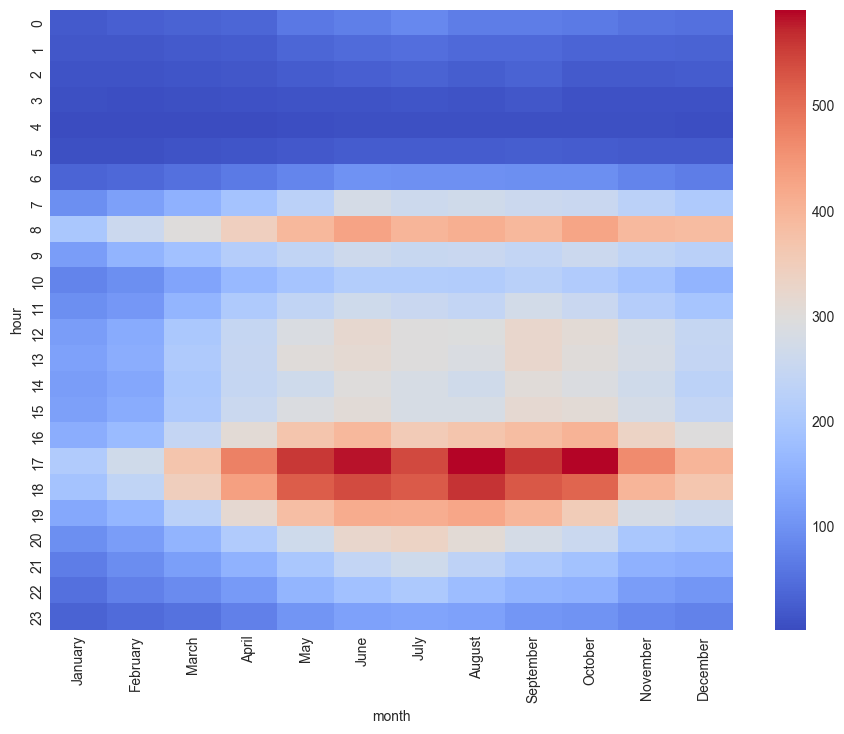

In [73]:
fig = plt.figure(figsize=(11,8))
sns.heatmap(train_no_dummy_month_piv,cmap='coolwarm')

** Let's cluster hour and workingday impact on rentals. **

In [74]:
train_no_dummy_workingday_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].pivot_table(values='count',index='hour',columns=['workingday'])

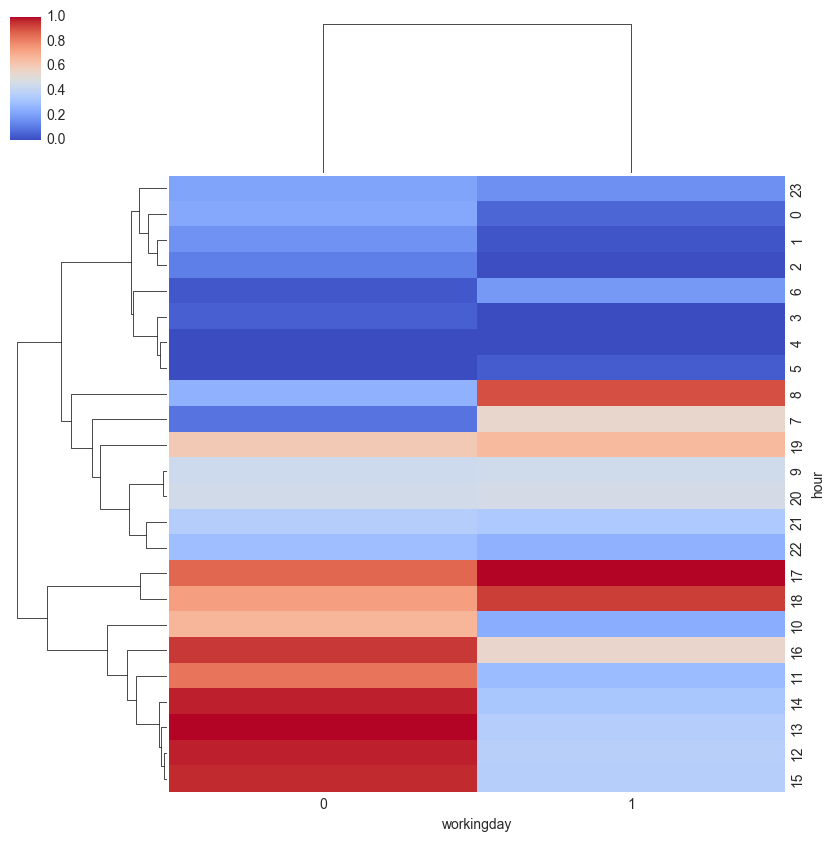

In [75]:
sns.clustermap(train_no_dummy_workingday_piv,cmap='coolwarm',standard_scale=1,method='average')

In [76]:
all_no_dummy_interpolate[(all_no_dummy_interpolate['train'] == 1) & \
                         (all_no_dummy_interpolate['workingday'] == 1)].groupby('hour').mean()['count']

hour
0      36.714744
1      16.038585
2       8.485342
3       4.896907
4       5.357860
5      24.535256
6     102.496795
7     290.544872
8     479.743590
9     242.262821
10    133.849359
11    157.253205
12    199.578275
13    197.316294
14    180.654952
15    198.753994
16    292.517572
17    529.159744
18    495.319489
19    349.386581
20    249.345048
21    184.865815
22    138.399361
23     89.019169
Name: count, dtype: float64

In [77]:
all_no_dummy_interpolate[(all_no_dummy_interpolate['train'] == 1) & \
                         (all_no_dummy_interpolate['workingday'] == 0)].groupby('hour').mean()['count']

hour
0      95.335664
1      72.615385
2      54.283688
3      25.816901
4       8.601399
5       9.142857
6      19.013986
7      44.181818
8     107.552448
9     177.090909
10    265.076923
11    327.230769
12    381.118881
13    390.146853
14    380.874126
15    375.874126
16    368.587413
17    336.573427
18    289.769231
19    240.622378
20    182.930070
21    148.209790
22    123.020979
23     90.580420
Name: count, dtype: float64

### From the plot clustermap above and hourly count mean statistics, we can devide hours into 8 categories: 
<ul> 
<li>workingday = 1
    <ol>
        <li>(0-5)</li>
        <li>{6,10,11,22,23}</li>
        <li>(7-21) \ {8,17,18}</li>
        <li>{8,17,18}</li>
    </ol>
</li>
<br>
<li>workingday = 0
    <ol>
        <li>(22-1) v {8}</li>
        <li>(2-7)</li>
        <li>{9,20,21}</li>
        <li>(10-19)</li>
    </ol>
</li>
</ul>

We added those categories in variable **hour_cat.**

** Let's cluster temp and workingday impact on rentals. **

In [78]:
train_no_dummy_year_temp_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].round().pivot_table(values='count',index='temp',columns=['workingday']).dropna()

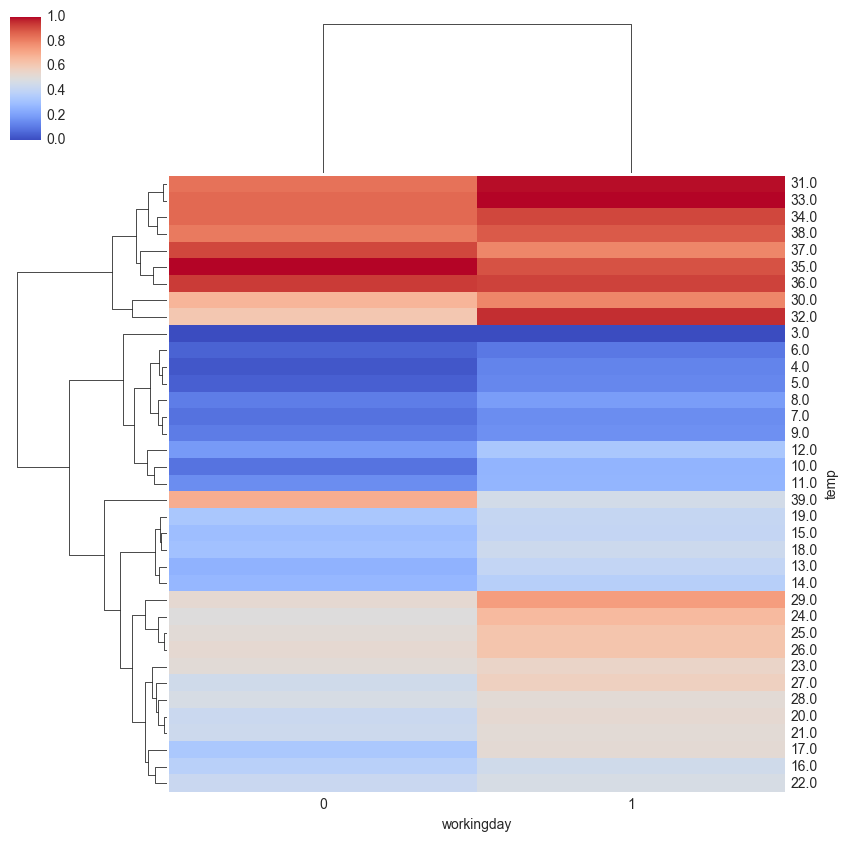

In [79]:
sns.clustermap(train_no_dummy_year_temp_piv,cmap='coolwarm',standard_scale=1,method='average')

### From the plot clustermap above we can devide rounded temp into 3 categories: 
<ol>
<li>(below 13)</li>
<li>[13-30], workingday=0</li>
<li>[13-30], workingday=1</li>
<li>(above 30)</li>
</ol>

We added those categories in variable ** temp_cat. **

___
# 4. Training and Testing Data
----
###  4.1 Regression Evaluation Metrics

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Root Mean Squared Log Error** (RMSLE) is the square root of the mean of the squared log errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(log(y_i+1)-log(\hat{y}_i+1))^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.
- **RMSLE** can be used when we don’t want to penalize huge differences when both the values are huge numbers.

All of these are **loss functions**, because we want to minimize them.
___

In [80]:
def evaluatorMAE_own(predictions, labelCol):
    diff = np.abs(predictions[labelCol] - predictions['prediction'])
    mean_error = diff.mean()
    return mean_error

def evaluatorMSE_own(predictions, labelCol):
    diff = predictions[labelCol] - predictions['prediction']
    mean_error = np.square(diff).mean()
    return mean_error
                                   
def evaluatorRMSE_own(predictions, labelCol):
    diff = predictions[labelCol] - predictions['prediction']
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def evaluatorRMSLE_own(predictions, labelCol):
    diff = np.log(predictions[labelCol] + 1) - np.log(predictions['prediction'] + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def evaluatorR2_own(predictions, labelCol):
    SS_res = np.sum(np.square(predictions[labelCol] - predictions['prediction']))
    SS_tot = np.sum(np.square(predictions[labelCol] - predictions[labelCol].mean()))
    R2 = 1 - SS_res/SS_tot
    return R2

def undo_log_transform(pred,labelCol, Kaggle=False):
    predictions = pred.copy()
    # Kaggle test data doesn't have labels
    if (not Kaggle):
        predictions[labelCol] = np.exp(predictions[labelCol]) - 1
    predictions['prediction'] = np.exp(predictions['prediction']) - 1
    return predictions

def undo_bc_transform(pred,labelCol, lmbd, Kaggle=False):
    predictions = pred.copy()
    # Kaggle test data doesn't have labels
    if (not Kaggle):
        predictions[labelCol] = inv_boxcox(predictions[labelCol], lmbd) - 1
    predictions['prediction'] = inv_boxcox(predictions['prediction'], lmbd) - 1
    return predictions

def evaluateMetrics(preds, labelCol, lmbd, rollback=True, rounded=True):   
    predictions = preds.copy()
    
    if (rollback):
        predictions = undo_bc_transform(predictions, labelCol, lmbd)
    if (rounded):
        predictions = np.round(predictions)
    
#     print("MAE:   " + str('%.4f' % evaluatorMAE_own(predictions, labelCol)))
#     print("MSE:   " + str('%.4f' % evaluatorMSE_own(predictions, labelCol)))
#     print("RMSE:  " + str('%.4f' % evaluatorRMSE_own(predictions, labelCol)))
    print("R2:    " + str('%.4f' % evaluatorR2_own(predictions, labelCol)))
#    print("----------------")
    print("RMSLE: " + str('%.4f' % evaluatorRMSLE_own(predictions, labelCol)))
#    print("----------------")
    
    return evaluatorRMSLE_own(predictions, labelCol)

** Drop unnecessary added category variables from training dataset. Apache Spark needs all data to be numerical. Later on we will perform feature selection to chose best variables for our models. **

In [81]:
all_no_dummy_interpolate = all_no_dummy_interpolate.drop(added_cat_var, axis=1)

** Dummy variables for linear regression. **

In [82]:
all_dummy_interpolate = pd.get_dummies(data = all_no_dummy_interpolate.copy(), \
                             columns = categorical_var, drop_first=True)

** Split training data into train and "test" to evaluate our models. Final model will predict labels for test_KAGGLE datasets. **

In [83]:
trainingData_dummy = all_dummy_interpolate[all_dummy_interpolate['day'] <= 15]
testData_dummy = all_dummy_interpolate[(all_dummy_interpolate['day'] > 15) & (all_dummy_interpolate['day'] < 20)]

trainingData_no_dummy = all_no_dummy_interpolate[all_no_dummy_interpolate['day'] <= 15]
testData_no_dummy = all_no_dummy_interpolate[(all_no_dummy_interpolate['day'] > 15) & (all_no_dummy_interpolate['day'] < 20)]

** Create Apache Spark Data Frames ** 

In [84]:
spark_train_dummy = sqlContext.createDataFrame(trainingData_dummy)
spark_test_dummy = sqlContext.createDataFrame(testData_dummy)

spark_train_no_dummy = sqlContext.createDataFrame(trainingData_no_dummy)
spark_test_no_dummy = sqlContext.createDataFrame(testData_no_dummy)

** Prepare Kaggle test data. **

In [85]:
# reset index for including datetime as column
spark_Kaggle_test_dummy = sqlContext.createDataFrame(all_dummy_interpolate[all_dummy_interpolate['train'] != 1].reset_index())
spark_Kaggle_test_no_dummy = sqlContext.createDataFrame(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1].reset_index())

___
## 4.2 Format input data for machine learning
** Apache Spark Machine Learning lib requires input as data frame transformed to labeled point. **

In [86]:
from pyspark.ml.linalg import Vectors
DUMMY = True

In [87]:
columns_to_hide = added_cat_var + dependent_variables + dependent_variables_log \
                + dependent_variables_bc + dependent_variables_cat + ['train','index', 'hour_cat']

In [88]:
dummy_cols = [x for x in spark_train_dummy.columns if x not in columns_to_hide]
no_dummy_cols = [x for x in spark_train_no_dummy.columns if x not in columns_to_hide]

In [89]:
def transformToLabeledPoint(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    for col in spark_col:
        retArray.append(row[col])
    
    hour_cat = row["hour_cat"]
    label_count = row["count_bc"]
    label_registered = row["registered_bc"]
    label_casual = row["casual_bc"]
        
    return hour_cat, label_count, label_registered, label_casual, Vectors.dense(retArray)

In [90]:
def transformToLabeledPointKaggle(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    for col in spark_col:
        retArray.append(row[col])

    hour_cat = row["hour_cat"]    
    datetime = row["index"]
    
    # lables must match this from transformToLabeledPoint for further unionAll() operation    
    return hour_cat, datetime,0,0, Vectors.dense(retArray)

** ChiSqSelector used for feature selection. **

In [91]:
def transformToLabeledPointChiSqSelector(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    for col in spark_col:
        retArray.append(row[col])
    
    hour_cat = row["hour_cat"]
    label_count_cat = row["count_cat"]
    label_registered_cat = row["registered_cat"]
    label_casual_cat = row["casual_cat"]
   
    return hour_cat, label_count_cat, label_registered_cat, label_casual_cat, Vectors.dense(retArray)

** Preparation Apache Spark data frame for linear regression **

In [92]:
DUMMY = True
trainingData_dummy = sqlContext.createDataFrame(spark_train_dummy.rdd.map(transformToLabeledPoint), ["hour_cat", "label_count", "label_registered", "label_casual", "features_to_filter"])
testData_dummy = sqlContext.createDataFrame(spark_test_dummy.rdd.map(transformToLabeledPoint), ["hour_cat", "label_count", "label_registered", "label_casual", "features_to_filter"])
testKaggle_dummy = sqlContext.createDataFrame(spark_Kaggle_test_dummy.rdd.map(transformToLabeledPointKaggle), ["hour_cat", "label_count", "label_registered", "label_casual", "features_to_filter"])
chiSq_dummy = sqlContext.createDataFrame(spark_train_dummy.unionAll(spark_test_dummy)\
                                         .rdd.map(transformToLabeledPointChiSqSelector), ["hour_cat", "label_count_cat", "label_registered_cat", "label_casual_cat", "features_to_filter"])

** Preparation Apache Spark data frame for random forest and gradient boosted regression. No need for dummy variables. **

In [93]:
DUMMY = False
trainingData_no_dummy = sqlContext.createDataFrame(spark_train_no_dummy.rdd.map(transformToLabeledPoint), ["hour_cat", "label_count", "label_registered", "label_casual", "features_to_filter"])
testData_no_dummy = sqlContext.createDataFrame(spark_test_no_dummy.rdd.map(transformToLabeledPoint), ["hour_cat", "label_count", "label_registered", "label_casual", "features_to_filter"])
testKaggle_no_dummy = sqlContext.createDataFrame(spark_Kaggle_test_no_dummy.rdd.map(transformToLabeledPointKaggle), ["hour_cat", "label_count", "label_registered", "label_casual","features_to_filter"])
chiSq_no_dummy = sqlContext.createDataFrame(spark_train_no_dummy.unionAll(spark_test_no_dummy)\
                                         .rdd.map(transformToLabeledPointChiSqSelector), ["hour_cat", "label_count_cat", "label_registered_cat", "label_casual_cat", "features_to_filter"])

** Cache spark data frames into memory for faster computation **

In [94]:
trainingData_dummy.cache()
trainingData_dummy.count()
trainingData_no_dummy.cache()
trainingData_no_dummy.count()

8600

In [95]:
testData_dummy.cache()
testData_dummy.count()
testData_no_dummy.cache()
testData_no_dummy.count()

2286

In [96]:
testKaggle_dummy.cache()
testKaggle_dummy.count()
testKaggle_no_dummy.cache()
testKaggle_no_dummy.count()

6493

** To treat categorical variables as nominal we must first index them by featureIndexer. Features with number of unique values above maxCategories will be treated as continuous. **

In [97]:
from pyspark.ml.feature import VectorIndexer

featureIndexer =\
    VectorIndexer(inputCol="features_to_filter", outputCol="indexedFeatures", maxCategories=4) \
    .fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))

___
## 4.3 Function definitions
** Now its time to train and tune our model on training data using k-fold cross validation method! **


In [98]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import TrainValidationSplit

In [99]:
def make_prediction(models_dict, feature_selector, hour_cat, dummy=False, Kaggle=False):
     
    selector = feature_selector
    # Kaggle test data is used only with no_dummy
    if (dummy):
        #selector = feature_selector_dummy[hour_cat]
        if (Kaggle):
            test_data = testKaggle_dummy.filter(testKaggle_dummy.hour_cat == hour_cat)
        else:
            test_data = testData_dummy.filter(testData_dummy.hour_cat == hour_cat)
    elif (Kaggle):
        test_data = featureIndexer.transform(testKaggle_no_dummy.filter(testKaggle_no_dummy.hour_cat == hour_cat))
    else:
        test_data = featureIndexer.transform(testData_no_dummy.filter(testData_no_dummy.hour_cat == hour_cat))
    

    predictionsTestData_r = models_dict['label_registered'].transform(selector['label_registered'].transform(test_data))
    predictionsTestData_c = models_dict['label_casual'].transform(selector['label_casual'].transform(test_data))
    predictionsTestData_count = models_dict['label_count'].transform(selector['label_count'].transform(test_data))

    
    return predictionsTestData_r, predictionsTestData_c, predictionsTestData_count

** Function for evaluation metrics, support both functionalities: evaluate rounded predictions and not. **

In [100]:
def evaluate_prediction(predictionsTestData_r, predictionsTestData_c, predictionsTestData_count, lambdas, rounded=True):
    print("Evaluation prediction for registred users:")
    pandas_pred_r = predictionsTestData_r.toPandas()
    pandas_pred_r.loc[(pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    rmsle_r = evaluateMetrics(pandas_pred_r, 'label_registered', lmbd=lambdas['registered'], rounded=rounded)
    print()

    print("Evaluation prediction for casual users:")
    pandas_pred_c = predictionsTestData_c.toPandas()
    pandas_pred_c.loc[(pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    rmsle_c = evaluateMetrics(pandas_pred_c, 'label_casual', lmbd=lambdas['casual'], rounded=rounded)
    print()

    print("Evaluation prediction for sum of both models: registred + casual users:")
    pandas_pred_c_undo_log = undo_bc_transform(pandas_pred_c,'label_casual', lmbd=lambdas['casual'])
    pandas_pred_c_undo_log.loc[(pandas_pred_c_undo_log['prediction'] < 0), 'prediction'] = 0
    pandas_pred_r_undo_log = undo_bc_transform(pandas_pred_r,'label_registered', lmbd=lambdas['registered'])
    pandas_pred_r_undo_log.loc[(pandas_pred_r_undo_log['prediction'] < 0), 'prediction'] = 0
    pandas_pred_sum = pd.DataFrame()
    pandas_pred_sum['label_count'] = pandas_pred_c_undo_log['label_casual'] + pandas_pred_r_undo_log['label_registered']
    pandas_pred_sum['prediction'] = pandas_pred_c_undo_log['prediction'] + pandas_pred_r_undo_log['prediction']
    rmsle_sum = evaluateMetrics(pandas_pred_sum, 'label_count', lmbd={}, rollback=False, rounded=rounded)
    print()

    print("Evaluation prediction for one count users model:")
    pandas_pred_count = predictionsTestData_count.toPandas()
    pandas_pred_count.loc[(pandas_pred_count['prediction'] < 0), 'prediction'] = 0
    rmsle_count = evaluateMetrics(pandas_pred_count, 'label_count', lmbd=lambdas['count'], rounded=rounded)
    
    # We drop features variable in case to mix prediction from dummy and no_dummy models;
    # dummy features vector has much more positions than no_dummy, so there would be problem to connect both.
    # We just won't need features vector any more.
    prediction_dict = {'label_registered' : undo_bc_transform(pandas_pred_r.drop(['features'], axis = 1).copy(), 'label_registered',lmbd=lambdas['registered']),
                      'label_casual': undo_bc_transform(pandas_pred_c.drop(['features'], axis = 1).copy(), 'label_casual',lmbd=lambdas['casual']),
                      'label_sum': pandas_pred_sum.copy(),
                      'label_count': undo_bc_transform(pandas_pred_count.drop(['features'], axis = 1).copy(),'label_count', lmbd=lambdas['count']),
                      'rmsle_r': rmsle_r,
                      'rmsle_c': rmsle_c,
                      'rmsle_sum': rmsle_sum,
                      'rmsle_count': rmsle_count}
    
    return prediction_dict

In [101]:
def evaluate_all_prediction(all_registered, all_casual, all_sum, all_count, rounded=True):
    print("Evaluation prediction for registred users:")
    rmsle_r = evaluateMetrics(all_registered, 'label_registered', lmbd={}, rollback=False, rounded=rounded)
    print()

    print("Evaluation prediction for casual users:")
    rmsle_c = evaluateMetrics(all_casual, 'label_casual', lmbd={}, rollback=False, rounded=rounded)
    print()

    print("Evaluation prediction for sum of both models: registred + casual users:")
    rmsle_sum = evaluateMetrics(all_sum, 'label_count', lmbd={}, rollback=False, rounded=rounded)
    print()

    print("Evaluation prediction for one count users model:")
    rmsle_count = evaluateMetrics(all_count, 'label_count', lmbd={}, rollback=False, rounded=rounded)
    
    prediction_dict = {'rmsle_r': rmsle_r,
                      'rmsle_c': rmsle_c,
                      'rmsle_sum': rmsle_sum,
                      'rmsle_count': rmsle_count}
    
    return prediction_dict

** Function for mixing predictions from two different models together with respect to specifc ratio rate. **

In [102]:
def evaluate_mixed_prediction(rf_all_sum, rf_all_count, gbt_all_sum, gbt_all_count, ratio=0.5, rounded=True):

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for sum of both models: registred + casual users:")
    mixed_pandas_sum = ratio * rf_all_sum[['label_count', 'prediction']] + (1.0 - ratio) * gbt_all_sum[['label_count', 'prediction']]
    rmsle_sum = evaluateMetrics(mixed_pandas_sum, 'label_count', lmbd={}, rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for one count users model:")
    mixed_pandas_count = ratio * rf_all_count[['label_count', 'prediction']] + (1.0 - ratio) * gbt_all_count[['label_count', 'prediction']]
    rmsle_count = evaluateMetrics(mixed_pandas_count, 'label_count', lmbd={}, rollback=False, rounded=rounded)
    
    mixed_prediction_dict = {'sum': mixed_pandas_sum.copy(),
                     'count': mixed_pandas_count.copy(),
                     'rmsle_sum' : rmsle_sum,
                     'rmsle_count' : rmsle_count}
    
    return mixed_prediction_dict

** Function for final prediction for Kaggle test dataset. Support mixing prediction with specific ratio. Final sum of predictions is rounded. **

In [103]:
def predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, \
                        gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, lambdas, ratio=0.5):
    
    # 1. Although Kaggle test dataset does not have labels, all prediction are Spark dataframes 
    # with schema ["label_count", "label_registered", "label_casual", "features"]
    # for coherent format with training data which enables us to use Spark featureIndexer during traingin models
    # featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    #
    # 2. We used column 'label_count' for convenient cache datatime variable used for submission file format
    # pandas_pred_sum.rename(columns={"label_count": "datetime"})
    #
    # 3. Predicted values have to be numerical
    # 4. labelCol is set to '' becouse Kaggle test dataset doesn't have one
    
    rf_pandas_pred_r = rf_predictionsTestData_r.toPandas().drop(['features'], axis = 1).copy()
    rf_pandas_pred_c = rf_predictionsTestData_c.toPandas().drop(['features'], axis = 1).copy()
    gbtr_pandas_pred_r = gbtr_predictionsTestData_r.toPandas().drop(['features'], axis = 1).copy()
    gbtr_pandas_pred_c = gbtr_predictionsTestData_c.toPandas().drop(['features'], axis = 1).copy()
    
    rf_pandas_pred_r.loc[(rf_pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    rf_pandas_pred_c.loc[(rf_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    gbtr_pandas_pred_r.loc[(gbtr_pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    gbtr_pandas_pred_c.loc[(gbtr_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    
    rf_pandas_pred_r = undo_bc_transform(rf_pandas_pred_r, labelCol='', lmbd=lambdas['registered'], Kaggle=True)
    rf_pandas_pred_c = undo_bc_transform(rf_pandas_pred_c, labelCol='', lmbd=lambdas['casual'], Kaggle=True)
    gbtr_pandas_pred_r = undo_bc_transform(gbtr_pandas_pred_r, labelCol='', lmbd=lambdas['registered'], Kaggle=True)
    gbtr_pandas_pred_c = undo_bc_transform(gbtr_pandas_pred_c, labelCol='', lmbd=lambdas['casual'], Kaggle=True)
    

    
    pandas_pred_sum = rf_pandas_pred_r.copy()
    pandas_pred_sum['count'] = 0.0
    pandas_pred_sum['count'] = ratio * (rf_pandas_pred_r['prediction'] + rf_pandas_pred_c['prediction']) + \
                                (1.0 - ratio) * (gbtr_pandas_pred_r['prediction'] + gbtr_pandas_pred_c['prediction'])
    pandas_pred_sum['count'] = np.round(pandas_pred_sum['count']).astype(int)
    # other option to truncate floating point number instead of round
    # pandas_pred_sum['count'] = pandas_pred_sum['count'].astype(int)
    
    return pandas_pred_sum.rename(columns={"label_count": "datetime"})[['datetime','count']]

** Function to compute score for mixed score for COUNT. Later on we will use better predictions: SUM (casual + registered separately) or COUNT. Unfortunatelly we can choose better one only by comparing results from Kaggle webstite. :-)**

In [104]:
def predict_count_Kaggle_test(rf_predictionsTestData_c, gbtr_predictionsTestData_c, lambdas, ratio=0.5):
    
    
    rf_pandas_pred_c = rf_predictionsTestData_c.toPandas().drop(['features'], axis = 1).copy()
    gbtr_pandas_pred_c = gbtr_predictionsTestData_c.toPandas().drop(['features'], axis = 1).copy()
    
    rf_pandas_pred_c.loc[(rf_pandas_pred_c['prediction'] < 0), 'prediction'] = 0  
    gbtr_pandas_pred_c.loc[(gbtr_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    
    rf_pandas_pred_c = undo_bc_transform(rf_pandas_pred_c, labelCol='', lmbd=lambdas['count'], Kaggle=True)    
    gbtr_pandas_pred_c = undo_bc_transform(gbtr_pandas_pred_c, labelCol='', lmbd=lambdas['count'], Kaggle=True)    

    
    pandas_pred_sum = rf_pandas_pred_c.copy()
    pandas_pred_sum['count'] = 0.0
    pandas_pred_sum['count'] = ratio * (rf_pandas_pred_c['prediction']) + \
                                (1.0 - ratio) * (gbtr_pandas_pred_c['prediction'])
    pandas_pred_sum['count'] = np.round(pandas_pred_sum['count']).astype(int)
    # other option to truncate floating point number instead of round
    # pandas_pred_sum['count'] = pandas_pred_sum['count'].astype(int)
    
    return pandas_pred_sum.rename(columns={"label_count": "datetime"})[['datetime','count']]

** Concatenate all hour_cat in one pandas dataFrame. **

In [105]:
def concatenate_Kaggle_predictions(pred_sum_dict, pred_count_dict):
    # initialize with data from first hour_cat and then append rest hour categories
    all_sum = pred_sum_dict[0].copy()
    all_count = pred_count_dict[0].copy()
    
    # start from hour_cat = 1
    for hour_cat in hour_cat_list[1:]:
        all_sum = all_sum.append(pred_sum_dict[hour_cat])
        all_count = all_count.append(pred_count_dict[hour_cat])
    
    return all_sum.reset_index(drop=True), all_count.reset_index(drop=True)

In [106]:
def concatenate_predictions(pred_dict):
    # initialize with data from first hour_cat and then append rest hour categories
    all_registered = pred_dict[0]['label_registered'].copy()
    all_casual = pred_dict[0]['label_casual'].copy()
    all_sum = pred_dict[0]['label_sum'].copy()
    all_count = pred_dict[0]['label_count'].copy()
    
    # start from hour_cat = 1
    for hour_cat in hour_cat_list[1:]:
        all_registered = all_registered.append(pred_dict[hour_cat]['label_registered'])
        all_casual = all_casual.append(pred_dict[hour_cat]['label_casual'])
        all_sum = all_sum.append(pred_dict[hour_cat]['label_sum'])
        all_count = all_count.append(pred_dict[hour_cat]['label_count'])
    
    return all_registered.reset_index(drop=True), all_casual.reset_index(drop=True), all_sum.reset_index(drop=True), all_count.reset_index(drop=True)

___
# 4.4 Train Models

## 4.4.1 ChiSquare Test & Decision Tree for feature selection
Decision trees are a popular family of classification and regression methods. We will use them as step before ensemled models training, to verify subsets of features to minimalize loss function. 


** Let's find out how  number of chosen features impacts RMSLE metric. **

In [107]:
dt = DecisionTreeRegressor(maxDepth=30, minInstancesPerNode=10, featuresCol="features")
dt_cv_models_dict = {}
selector_no_dummy_dict = {}
rmsle_hour_cat = {}

#### COMMENTED
** Code below is commented becouse it's time consuming. Instead, we load  by pickle previously computed results. **

In [108]:
# for hour_cat in hour_cat_list:
    
#     rmsle_registered = []
#     rmsle_casual = []
#     rmsle_sum = []
#     rmsle_count = []
    
#     for num in range(1,len(no_dummy_cols) + 1):
#         for label in ["label_count", "label_registered", "label_casual"]:

#             selector_no_dummy = ChiSqSelector(selectorType="numTopFeatures", fpr=0.01, numTopFeatures=num, \
#                                               featuresCol="indexedFeatures",outputCol="features", labelCol=label + "_cat")

#             selected_features_no_dummy = selector_no_dummy.fit(featureIndexer \
#                                                       .transform(chiSq_no_dummy.filter(chiSq_no_dummy.hour_cat == hour_cat)))

#             pipeline = Pipeline(stages=[featureIndexer, selected_features_no_dummy, dt.setLabelCol(label)])
#             model = pipeline.fit(trainingData_no_dummy.filter(trainingData_no_dummy.hour_cat == hour_cat)) 
#             dt_cv_models_dict[label] = model
#             selector_no_dummy_dict[label] = selected_features_no_dummy
        
#         print("\n==========================================")
#         print("Category: " + str(hour_cat) + ", using " + str(num) + " best features")
#         print("==========================================")
#         dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count = make_prediction(dt_cv_models_dict, selector_no_dummy_dict, hour_cat, dummy=False)
#         dt_pred_dict = evaluate_prediction(dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat])
#         rmsle_registered.append(dt_pred_dict['rmsle_r'])
#         rmsle_casual.append(dt_pred_dict['rmsle_c'])
#         rmsle_sum.append(dt_pred_dict['rmsle_sum'])
#         rmsle_count.append(dt_pred_dict['rmsle_count'])

#     rmsle_hour_cat[hour_cat] = {'registered' : rmsle_registered, 
#                                 'casual' : rmsle_casual, 
#                                 'sum': rmsle_sum, 
#                                 'count' : rmsle_count}

** Load previously computed metrics score. **

In [109]:
#pickle.dump(rmsle_hour_cat, open( "../data/rmsle_hour_cat.p", "wb" ))
rmsle_hour_cat = pickle.load( open( "../data/rmsle_hour_cat.p", "rb" ) )

** From the plots below it's clear that different features number with the smallest p-Value do the job for different hour categories. Increasing number of features above some some level doesn't lead to any metric improvemnt and there is a risk of overfitting. Feature 'hour' -  has the biggest impact on minimizing final score.  **

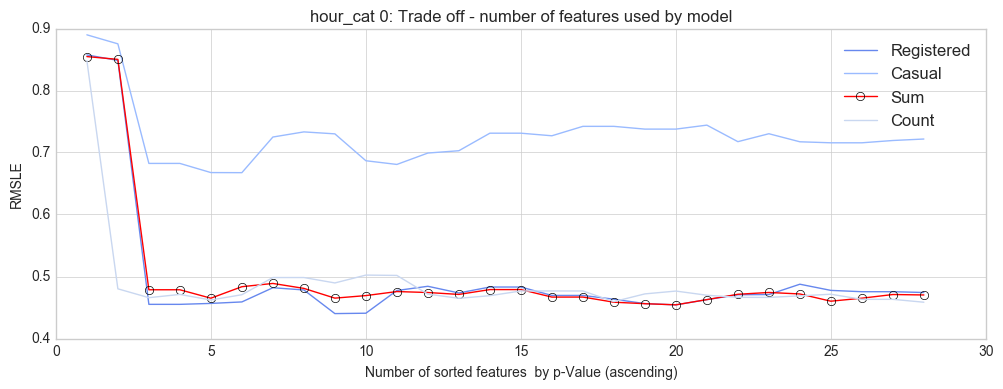

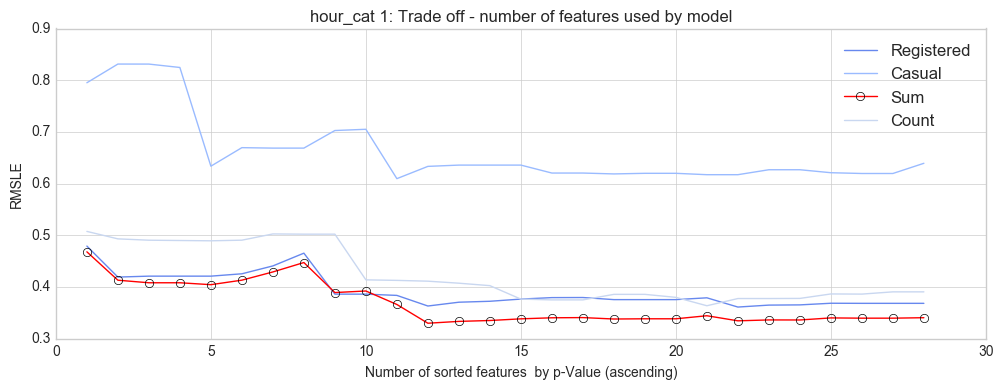

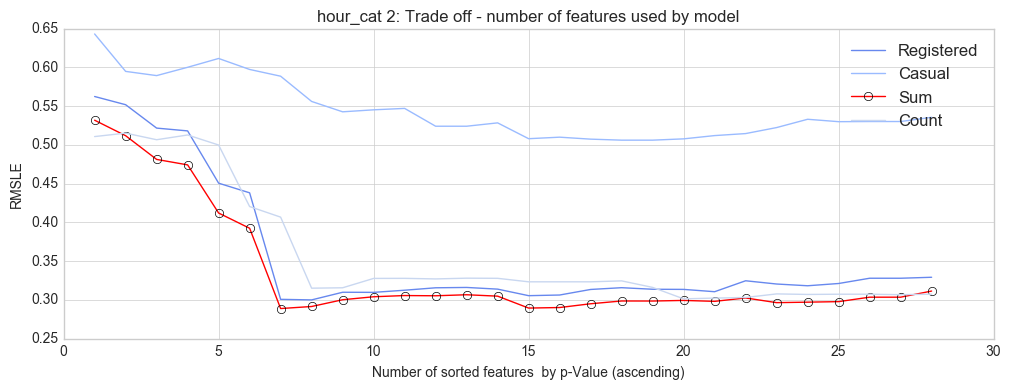

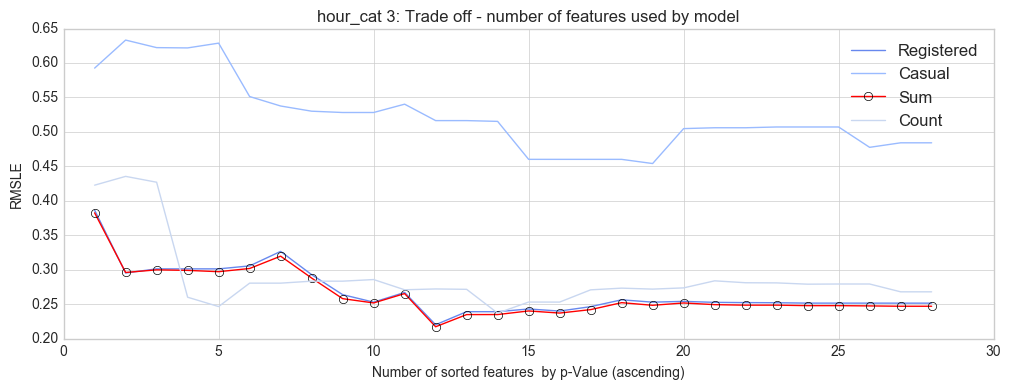

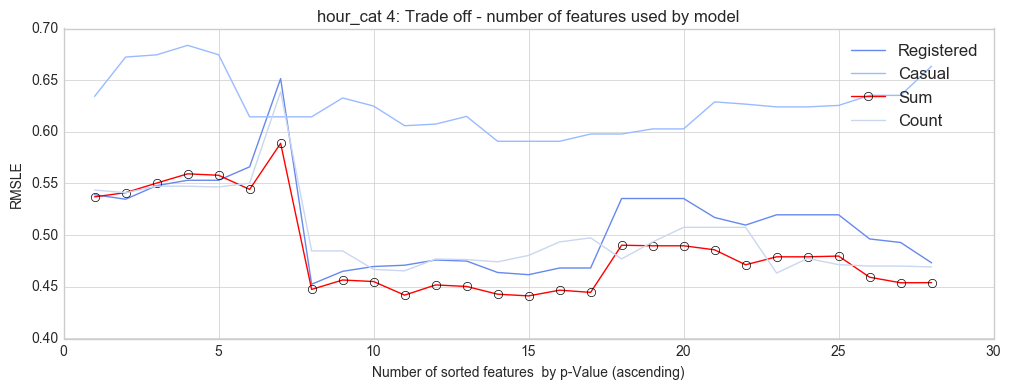

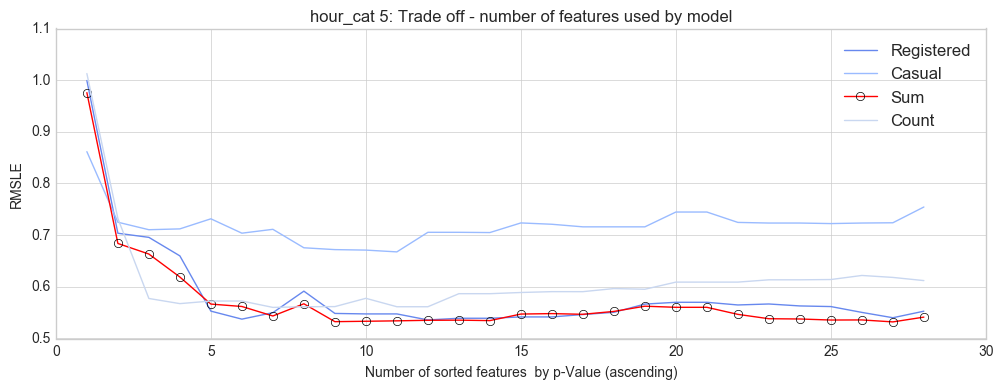

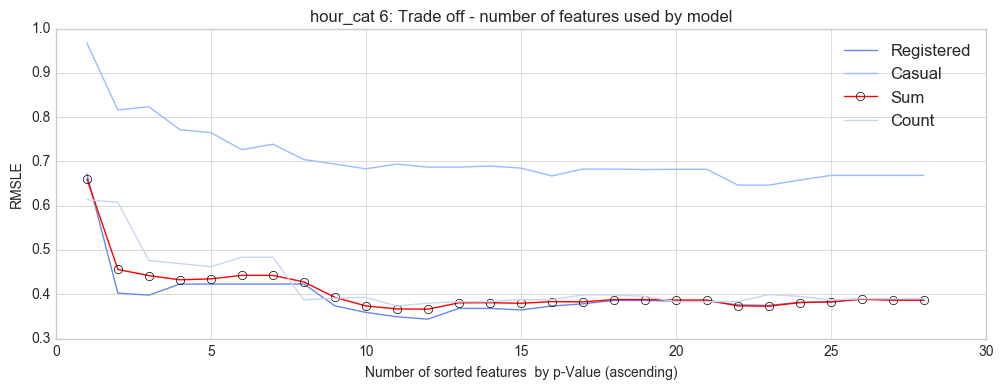

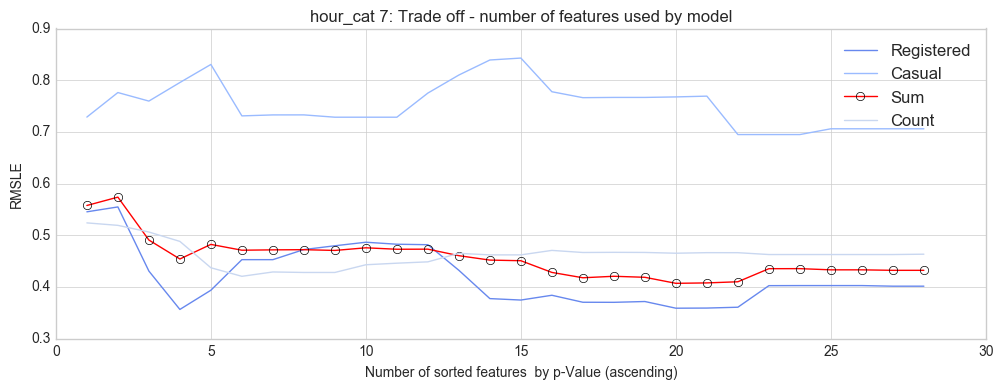

In [110]:
for hour_cat in hour_cat_list:
    fig = plt.figure(figsize=(12,4))

    plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_hour_cat[hour_cat]['registered'], label='Registered')
    plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_hour_cat[hour_cat]['casual'] , label='Casual')
    plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_hour_cat[hour_cat]['sum'], label='Sum', c='red', marker='o', markerfacecolor='None')
    plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_hour_cat[hour_cat]['count'], label='Count')
    plt.xlabel("Number of sorted features  by p-Value (ascending)")
    plt.ylabel("RMSLE")
    plt.title("hour_cat " + str(hour_cat) + ": Trade off - number of features used by model")
    plt.legend()

** From the plots above we can set number of features for each hour_cat separately to minimize Sum RMSLE. For same cases we should use all features to minimize RMSLE best, but in those scenarios models are proned to overfitting. We use threshold for number of chosen features. We set min number features useful for random forest regression.**

In [125]:
min_num_features = 12
max_num_features = 17
feat_num_hour_cat = {}
for hour_cat in hour_cat_list:
        feat_num_hour_cat[hour_cat] = {'label_registered' : rmsle_hour_cat[hour_cat]['registered'][:max_num_features]\
                                       .index(min(rmsle_hour_cat[hour_cat]['registered'][:max_num_features])) + 1,
                                      'label_casual' : rmsle_hour_cat[hour_cat]['casual'][:max_num_features]\
                                       .index(min(rmsle_hour_cat[hour_cat]['casual'][:max_num_features])) + 1,
                                      'label_count' : rmsle_hour_cat[hour_cat]['count'][:max_num_features]\
                                       .index(min(rmsle_hour_cat[hour_cat]['count'][:max_num_features])) + 1}

In [126]:
for hour_cat in hour_cat_list:
        for label in ['label_registered', 'label_casual', 'label_count']:
            if (feat_num_hour_cat[hour_cat][label] < min_num_features): feat_num_hour_cat[hour_cat][label] = min_num_features

In [127]:
feat_num_hour_cat

{0: {'label_casual': 12, 'label_count': 12, 'label_registered': 12},
 1: {'label_casual': 12, 'label_count': 16, 'label_registered': 12},
 2: {'label_casual': 17, 'label_count': 12, 'label_registered': 12},
 3: {'label_casual': 16, 'label_count': 14, 'label_registered': 12},
 4: {'label_casual': 14, 'label_count': 12, 'label_registered': 12},
 5: {'label_casual': 12, 'label_count': 12, 'label_registered': 12},
 6: {'label_casual': 16, 'label_count': 12, 'label_registered': 12},
 7: {'label_casual': 12, 'label_count': 12, 'label_registered': 12}}

** Prepare ChiSquare Selector ( https://en.wikipedia.org/wiki/Chi-squared_test ) to choose best features to our models based on feat_num_hour_cat. For dummy option select all features with p-Value below 0.05 **

In [128]:
feature_selector_dummy = {}
feature_selector_no_dummy = {}

In [129]:
for hour_cat in hour_cat_list:
    
    feat_selector_no_dummy = {}
    feat_selector_dummy = {}
    
    for label in ["label_count", "label_registered", "label_casual"]:
        # for dummy option select features with p-Value below 0.05
        selector_dummy = ChiSqSelector( selectorType="fpr", percentile=0.5, fpr=0.05, featuresCol="features_to_filter",
                                 outputCol="features", labelCol=label + "_cat")

        # we would like to connect selector with feature indexer so we must fit selector to
        # indexed data before we will be able to transform indexed data
        selector_no_dummy = ChiSqSelector(selectorType="numTopFeatures", fpr=0.05, \
                                          numTopFeatures=feat_num_hour_cat[hour_cat][label], featuresCol="indexedFeatures", \
                                          outputCol="features", labelCol=label + "_cat")

        selected_features_no_dummy = selector_no_dummy.fit(featureIndexer \
                                                  .transform(chiSq_no_dummy.filter(chiSq_no_dummy.hour_cat == hour_cat)))
        selected_features_dummy = selector_dummy.fit(chiSq_dummy.filter(chiSq_dummy.hour_cat == hour_cat))

        feat_selector_no_dummy[label] = selected_features_no_dummy 
        feat_selector_dummy[label] = selected_features_dummy

        # print selected columns for no_dummy option
        print(label + "_no_dummy, cat_" + str(hour_cat) + ": ChiSqSelector output with %d features selected below %.2f p-Value" \
                      % (len(selected_features_no_dummy.selectedFeatures), selector_no_dummy.getFpr()))
        for ind in selected_features_no_dummy.selectedFeatures:
            print("\t- " + no_dummy_cols[ind])
        print("")
        
    feature_selector_no_dummy[hour_cat] = feat_selector_no_dummy
    feature_selector_dummy[hour_cat] = feat_selector_dummy

label_count_no_dummy, cat_0: ChiSqSelector output with 12 features selected below 0.05 p-Value
	- season
	- hour
	- quarter
	- bike_season
	- temp_cat
	- temp_prev_hour_change_pct
	- month
	- year
	- atemp
	- humidity_prev_day_change_pct
	- weekofyear
	- dayofweek

label_registered_no_dummy, cat_0: ChiSqSelector output with 12 features selected below 0.05 p-Value
	- season
	- year
	- hour
	- quarter
	- bike_season
	- temp_prev_hour_change_pct
	- month
	- temp_cat
	- dayofweek
	- atemp
	- humidity_prev_day_change_pct
	- weekofyear

label_casual_no_dummy, cat_0: ChiSqSelector output with 12 features selected below 0.05 p-Value
	- season
	- month
	- hour
	- bike_season
	- temp_cat
	- quarter
	- atemp
	- weekofyear
	- temp
	- dayofweek
	- temp_prev_hour_change_pct
	- atemp_temp_diff

label_count_no_dummy, cat_1: ChiSqSelector output with 16 features selected below 0.05 p-Value
	- atemp
	- season
	- year
	- month
	- quarter
	- bike_season
	- atemp_temp_diff
	- temp_cat
	- temp
	- hour
	- te

** Verify final feature selection results on Decision Tree model. **

In [130]:
# Train a DecisionTree model.
dt = DecisionTreeRegressor(maxDepth=30, minInstancesPerNode=10, featuresCol="features")
dt_cv_models_dict = {}

for hour_cat in hour_cat_list:
    dt_cv_models = {}
    
    for label in ['label_registered','label_casual', 'label_count']:     
        pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[hour_cat][label], dt.setLabelCol(label)])
        model = pipeline.fit(trainingData_no_dummy.filter(trainingData_no_dummy.hour_cat == hour_cat)) 
        dt_cv_models[label] = model
        print("Train for hour_cat " + str(hour_cat) + " and " + label + " done.")
    dt_cv_models_dict[hour_cat] = dt_cv_models

Train for hour_cat 0 and label_registered done.
Train for hour_cat 0 and label_casual done.
Train for hour_cat 0 and label_count done.
Train for hour_cat 1 and label_registered done.
Train for hour_cat 1 and label_casual done.
Train for hour_cat 1 and label_count done.
Train for hour_cat 2 and label_registered done.
Train for hour_cat 2 and label_casual done.
Train for hour_cat 2 and label_count done.
Train for hour_cat 3 and label_registered done.
Train for hour_cat 3 and label_casual done.
Train for hour_cat 3 and label_count done.
Train for hour_cat 4 and label_registered done.
Train for hour_cat 4 and label_casual done.
Train for hour_cat 4 and label_count done.
Train for hour_cat 5 and label_registered done.
Train for hour_cat 5 and label_casual done.
Train for hour_cat 5 and label_count done.
Train for hour_cat 6 and label_registered done.
Train for hour_cat 6 and label_casual done.
Train for hour_cat 6 and label_count done.
Train for hour_cat 7 and label_registered done.
Train f

In [131]:
dt_pred_dict = {}
for hour_cat in hour_cat_list:
    print("\n==========================================")
    print("Category: " + str(hour_cat))
    print("==========================================")
    dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count = make_prediction(dt_cv_models_dict[hour_cat], feature_selector_no_dummy[hour_cat], hour_cat, dummy=False)
    dt_pred_dict[hour_cat] = evaluate_prediction(dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat])


Category: 0
Evaluation prediction for registred users:
R2:    0.7574
RMSLE: 0.4842

Evaluation prediction for casual users:
R2:    0.3343
RMSLE: 0.6991

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7460
RMSLE: 0.4742

Evaluation prediction for one count users model:
R2:    0.7819
RMSLE: 0.4716

Category: 1
Evaluation prediction for registred users:
R2:    0.5778
RMSLE: 0.3629

Evaluation prediction for casual users:
R2:    0.5964
RMSLE: 0.6331

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.6258
RMSLE: 0.3296

Evaluation prediction for one count users model:
R2:    0.5625
RMSLE: 0.3747

Category: 2
Evaluation prediction for registred users:
R2:    0.7747
RMSLE: 0.3154

Evaluation prediction for casual users:
R2:    0.6192
RMSLE: 0.5072

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7718
RMSLE: 0.2958

Evaluation prediction for one count users model:
R2:    0.7635
RMSLE: 0.3269

Cat

In [132]:
dt_all_registered, dt_all_casual, dt_all_sum, dt_all_count = concatenate_predictions(dt_pred_dict)
dt_all_evaluated = evaluate_all_prediction(dt_all_registered, dt_all_casual, dt_all_sum, dt_all_count)

Evaluation prediction for registred users:
R2:    0.8859
RMSLE: 0.4035

Evaluation prediction for casual users:
R2:    0.7448
RMSLE: 0.6196

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.8731
RMSLE: 0.3914

Evaluation prediction for one count users model:
R2:    0.8683
RMSLE: 0.4049


** We got result 0.3914 on simple decision tree. Looks primising. **

___
##  4.4.2 Linear Regression
We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. This will allow us to jointly choose parameters for all Pipeline stages. A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator. We use a ParamGridBuilder to construct a grid of parameters to search over. 

<table class="table">
  <thead>
    <tr><th></th><th>regularizer $R(w)$</th><th>gradient or sub-gradient</th></tr>
  </thead>
  <tbody>
    <tr>
      <td>zero (unregularized)</td><td>0</td><td>0</td>
    </tr>
    <tr>
      <td>L2</td><td>$\frac{1}{2}\|w\|^2$</td><td>$w$</td>
    </tr>
    <tr>
      <td>L1</td><td>$\|w\|$</td><td>$\mathrm{sign}(w)$</td>
    </tr>
    <tr>
      <td>elastic net</td><td>$\alpha \|w\| + (1-\alpha)\frac{1}{2}\|w\|^2$</td><td>$\alpha \mathrm{sign}(w) + (1-\alpha) w$</td>
    </tr>
  </tbody>
</table>
Here sign(w) is the vector consisting of the signs (±1) of all the entries of $w$.
L2-regularized problems are generally easier to solve than L1-regularized due to smoothness. However, L1 regularization can help promote sparsity in weights leading to smaller and more interpretable models, the latter of which can be useful for feature selection. Elastic net is a combination of L1 and L2 regularization. It is not recommended to train models without any regularization, especially when the number of training examples is small.

###  K-fold Cross Validation

In [177]:
lr_cv_models_dict = {}

In [178]:
lr = LinearRegression()

regParam = [1.0, 0.5, 0.1, 0.01, 0.001]
elasticNetParam = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


for hour_cat in hour_cat_list:
    lr_cv_models = {}
    
    for label in ['label_registered','label_casual', 'label_count']: 
        
        pipeline = Pipeline(stages=[lr])
        paramGrid = ParamGridBuilder() \
            .addGrid(lr.regParam, regParam) \
            .addGrid(lr.elasticNetParam, elasticNetParam) \
            .addGrid(lr.labelCol, [label]) \
            .build()

        crossval = TrainValidationSplit(estimator=pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
                                  trainRatio=0.75)  # (5x10) = 50 models to check  

        start = time.time()

        # Run cross-validation, and choose the best set of parameters on dummy dataset.
        # trainingData_dummy + testData_dummy = whole Kaggle Train data, we separarated this sets to simply evaluate models
        # we cross-validate on whole Kaggle train data to find best params to predict whole Kaggle Test set

        # use only features chosen before by ChiSqSelector 
        cvModel = crossval.fit(feature_selector_dummy[hour_cat][label].transform( \
                                trainingData_dummy.filter(trainingData_dummy.hour_cat == hour_cat)\
                               .unionAll(testData_dummy.filter(testData_dummy.hour_cat == hour_cat))))
        end = time.time()
        print("======= CV for hour_cat " + str(hour_cat) + " and " + label +  " =========")
        print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
        bestModel = cvModel.bestModel.stages[0]._java_obj
        print("RegParam: " + str(bestModel.getRegParam()))
        print("ElasticNetParam: "   + str(bestModel.getElasticNetParam()))
        lr_cv_models[label] = cvModel
        print()
    lr_cv_models_dict[hour_cat] = lr_cv_models

======= CV for hour_cat 0 and label_registered =========
Time taken to train model with k-fold cv: 35.765148878097534 seconds
RegParam: 0.001
ElasticNetParam: 0.3

======= CV for hour_cat 0 and label_casual =========
Time taken to train model with k-fold cv: 22.198549032211304 seconds
RegParam: 0.01
ElasticNetParam: 1.0

======= CV for hour_cat 0 and label_count =========
Time taken to train model with k-fold cv: 22.507302045822144 seconds
RegParam: 0.001
ElasticNetParam: 0.0

======= CV for hour_cat 1 and label_registered =========
Time taken to train model with k-fold cv: 23.030433177947998 seconds
RegParam: 0.01
ElasticNetParam: 0.4

======= CV for hour_cat 1 and label_casual =========
Time taken to train model with k-fold cv: 20.231430053710938 seconds
RegParam: 0.01
ElasticNetParam: 1.0

======= CV for hour_cat 1 and label_count =========
Time taken to train model with k-fold cv: 23.670408010482788 seconds
RegParam: 0.001
ElasticNetParam: 0.0

======= CV for hour_cat 2 and label_r



Now that we have fit our model, let's evaluate its performance by predicting off the test values with the best values from cross validation!.

In [180]:
lr_pred_dict = {}
for hour_cat in hour_cat_list:
    print("\n==========================================")
    print("Category: " + str(hour_cat))
    print("==========================================")
    lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count = make_prediction(lr_cv_models_dict[hour_cat], feature_selector_dummy[hour_cat], hour_cat, dummy=True)
    lr_pred_dict[hour_cat] = evaluate_prediction(lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat])


Category: 0
Evaluation prediction for registred users:
R2:    0.7920
RMSLE: 0.4094

Evaluation prediction for casual users:
R2:    0.1024
RMSLE: 0.7118

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7284
RMSLE: 0.4233

Evaluation prediction for one count users model:
R2:    0.7684
RMSLE: 0.4132

Category: 1
Evaluation prediction for registred users:
R2:    0.7420
RMSLE: 0.2644

Evaluation prediction for casual users:
R2:    0.6300
RMSLE: 0.5423

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7349
RMSLE: 0.2621

Evaluation prediction for one count users model:
R2:    0.7413
RMSLE: 0.2722

Category: 2
Evaluation prediction for registred users:
R2:    0.8088
RMSLE: 0.2690

Evaluation prediction for casual users:
R2:    0.6743
RMSLE: 0.4650

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7885
RMSLE: 0.2714

Evaluation prediction for one count users model:
R2:    0.8081
RMSLE: 0.2641

Cat



Let's evaluate our model performance by calculating the evaluation metrics. ** We achieved better result 0.3454 vs 0.3914 from simple decision tree. **

In [181]:
lr_all_registered, lr_all_casual, lr_all_sum, lr_all_count = concatenate_predictions(lr_pred_dict)
lr_all_evaluated = evaluate_all_prediction(lr_all_registered, lr_all_casual, lr_all_sum, lr_all_count)

Evaluation prediction for registred users:
R2:    0.9207
RMSLE: 0.3366

Evaluation prediction for casual users:
R2:    0.8718
RMSLE: 0.5566

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.9190
RMSLE: 0.3454

Evaluation prediction for one count users model:
R2:    0.9214
RMSLE: 0.3474


** Create a scatterplot of the real test values versus the predicted values. **



Let's quickly explore the residuals to make sure everything was okay with our data. 
It's good idea to plot a histogram of the residuals and make sure it looks normally distributed.

<function matplotlib.pyplot.tight_layout>

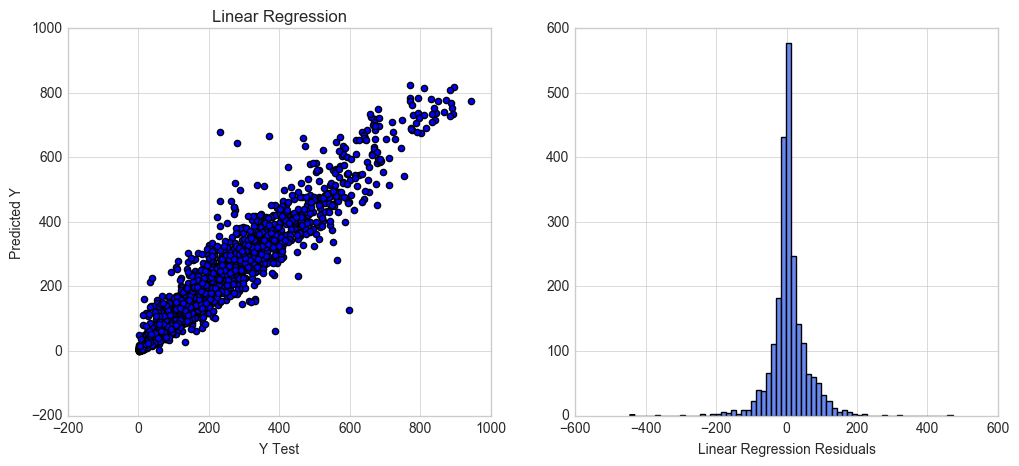

In [182]:
fig,axes= plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(lr_all_sum['label_count'],lr_all_sum['prediction'])
axes[0].set_xlabel('Y Test')
axes[0].set_ylabel('Predicted Y')
axes[0].set_title('Linear Regression')

#sns.distplot((lr_all_sum['label_count'] - lr_all_sum['prediction']),bins=64, ax=axes[1]);
axes[1].hist(lr_all_sum['label_count'] - lr_all_sum['prediction'],bins=64)
axes[1].set_xlabel('Linear Regression Residuals')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

___
## 4.4.3 Random Forest
Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression. They combine many decision trees in order to reduce the risk of overfitting. Like decision trees, random forests handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.
<h3 id="basic-algorithm">Basic algorithm</h3>

<p>Random forests train a set of decision trees separately, so the training can be done in parallel.
The algorithm injects randomness into the training process so that each decision tree is a bit
different.  Combining the predictions from each tree reduces the variance of the predictions,
improving the performance on test data.</p>

<p>The randomness injected into the training process includes:</p>

<ul>
  <li>Subsampling the original dataset on each iteration to get a different training set (a.k.a. bootstrapping).</li>
  <li>Considering different random subsets of features to split on at each tree node.</li>
</ul>

<p>Apart from these randomizations, decision tree training is done in the same way as for individual decision trees.To make a prediction on a new instance, a random forest must aggregate the predictions from its set of decision trees. This aggregation is done differently for classification and regression.For regression each tree predicts a real value. The label is predicted to be the average of the tree predictions.</p>

In [141]:
rf_cv_models_dict = {}

In [146]:
rf = RandomForestRegressor()

numTrees = [500, 1000]
maxDepth =  [10, 15, 30]
minInstancesPerNode = [10]
maxBins = [32]


for hour_cat in hour_cat_list:
    rf_cv_models = {}
    
    for label in ['label_registered','label_casual', 'label_count']: 
        pipeline = Pipeline(stages=[rf])
        paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, numTrees) \
            .addGrid(rf.maxDepth, maxDepth) \
            .addGrid(rf.minInstancesPerNode, minInstancesPerNode) \
            .addGrid(rf.maxBins, maxBins) \
            .addGrid(rf.labelCol, [label]) \
            .build()

        crossval = TrainValidationSplit(estimator=pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
                                  trainRatio=0.75)  # (2x3) = 4 models to check

        start = time.time()
        cvModel = crossval.fit(feature_selector_no_dummy[hour_cat][label].transform(\
                                featureIndexer.transform(trainingData_no_dummy.filter(trainingData_no_dummy.hour_cat == hour_cat)\
                               .unionAll(testData_no_dummy.filter(testData_no_dummy.hour_cat == hour_cat)))))
        print("======= CV for hour_cat " + str(hour_cat) + " and " + label +  " =========")
        end = time.time()
        print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")

        bestModel = cvModel.bestModel.stages[0]._java_obj
        print("NumTrees: " + str(bestModel.getNumTrees()))
        print("MaxDepth: "   + str(bestModel.getMaxDepth()))
        print("MinInstancesPerNode: "   + str(bestModel.getMinInstancesPerNode()))
        print("MaxBins: "   + str(bestModel.getMaxBins()))
        rf_cv_models[label] = cvModel
        print()
    rf_cv_models_dict[hour_cat] = rf_cv_models

======= CV for hour_cat 0 and label_registered =========
Time taken to train model with k-fold cv: 357.2658700942993 seconds
NumTrees: 1000
MaxDepth: 30
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 0 and label_casual =========
Time taken to train model with k-fold cv: 312.27041697502136 seconds
NumTrees: 500
MaxDepth: 30
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 0 and label_count =========
Time taken to train model with k-fold cv: 343.16280913352966 seconds
NumTrees: 1000
MaxDepth: 30
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 1 and label_registered =========
Time taken to train model with k-fold cv: 114.93206000328064 seconds
NumTrees: 500
MaxDepth: 10
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 1 and label_casual =========
Time taken to train model with k-fold cv: 120.89300203323364 seconds
NumTrees: 500
MaxDepth: 15
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 1 and label_count =========
Time taken

### COMMENTED - use either cv (time consuming) or  create models with common params for all models 

In [143]:
# rf = RandomForestRegressor(numTrees=500, maxDepth=15, minInstancesPerNode=10, featuresCol="features")

# for hour_cat in hour_cat_list:
#     rf_cv_models = {}
    
#     for label in ['label_registered','label_casual', 'label_count']:     
#         pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[hour_cat][label], rf.setLabelCol(label)])
#         model = pipeline.fit(trainingData_no_dummy.filter(trainingData_no_dummy.hour_cat == hour_cat)) 
#         rf_cv_models[label] = model
#         print("Train for hour_cat " + str(hour_cat) + " and " + label + " done.")
#     rf_cv_models_dict[hour_cat] = rf_cv_models

** Evaluate results in each hour_cat separately. **

In [147]:
rf_pred_dict = {}
for hour_cat in hour_cat_list:
    print("\n==========================================")
    print("Category: " + str(hour_cat))
    print("==========================================")
    rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict[hour_cat], feature_selector_no_dummy[hour_cat], hour_cat, dummy=False)
    rf_pred_dict[hour_cat] = evaluate_prediction(rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat])


Category: 0
Evaluation prediction for registred users:
R2:    0.8059
RMSLE: 0.3740

Evaluation prediction for casual users:
R2:    0.4471
RMSLE: 0.5542

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7727
RMSLE: 0.3844

Evaluation prediction for one count users model:
R2:    0.8031
RMSLE: 0.3761

Category: 1
Evaluation prediction for registred users:
R2:    0.8025
RMSLE: 0.2569

Evaluation prediction for casual users:
R2:    0.7184
RMSLE: 0.4835

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.7949
RMSLE: 0.2554

Evaluation prediction for one count users model:
R2:    0.8052
RMSLE: 0.2555

Category: 2
Evaluation prediction for registred users:
R2:    0.8763
RMSLE: 0.2342

Evaluation prediction for casual users:
R2:    0.8464
RMSLE: 0.3335

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.8784
RMSLE: 0.2242

Evaluation prediction for one count users model:
R2:    0.8793
RMSLE: 0.2259

Cat

Evaluate concatenated results. ** We achieved better result 0.3086 vs 0.3509 from cv linear regression. Looks even better. **

In [148]:
rf_all_registered, rf_all_casual, rf_all_sum, rf_all_count = concatenate_predictions(rf_pred_dict)
rf_all_evaluated = evaluate_all_prediction(rf_all_registered, rf_all_casual, rf_all_sum, rf_all_count)

Evaluation prediction for registred users:
R2:    0.9405
RMSLE: 0.3024

Evaluation prediction for casual users:
R2:    0.9025
RMSLE: 0.4540

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.9396
RMSLE: 0.3086

Evaluation prediction for one count users model:
R2:    0.9416
RMSLE: 0.3112


** Residuals should have normal distribution. Looks good. **

<function matplotlib.pyplot.tight_layout>

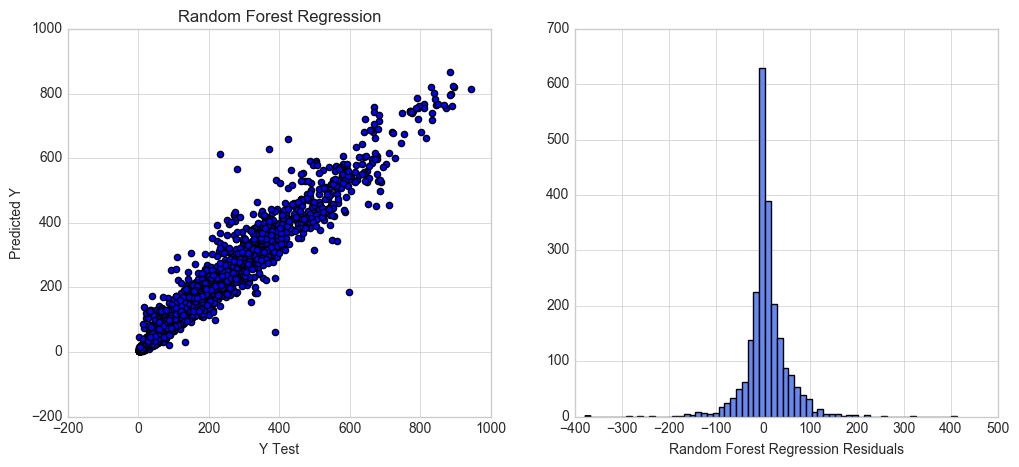

In [149]:
fig,axes= plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(rf_all_sum['label_count'],rf_all_sum['prediction'])
axes[0].set_xlabel('Y Test')
axes[0].set_ylabel('Predicted Y')
axes[0].set_title('Random Forest Regression')

axes[1].hist(rf_all_sum['label_count'] - rf_all_sum['prediction'],bins=64)
axes[1].set_xlabel('Random Forest Regression Residuals')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

___
## 4.4.4 Gradient-boosted tree regression
Gradient-Boosted Trees (GBTs) are ensembles of decision trees. GBTs iteratively train decision trees in order to minimize a loss function. Like decision trees, GBTs handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

<h3> Gradient-Boosted Trees vs. Random Forests</h3>

<p>Both <a href="https://en.wikipedia.org/wiki/Gradient_boosting">Gradient-Boosted Trees (GBTs)</a> and <a href="https://en.wikipedia.org/wiki/Random_forest">Random Forests</a> are algorithms for learning ensembles of trees, but the training processes are different.  There are several practical trade-offs:</p>

<ul>
  <li>GBTs train one tree at a time, so they can take longer to train than random forests.  Random Forests can train multiple trees in parallel.
    <ul>
      <li>On the other hand, it is often reasonable to use smaller (shallower) trees with GBTs than with Random Forests, and training smaller trees takes less time.</li>
    </ul>
  </li>
  <li>Random Forests can be less prone to overfitting.  Training more trees in a Random Forest reduces the likelihood of overfitting, but training more trees with GBTs increases the likelihood of overfitting.  (In statistical language, Random Forests reduce variance by using more trees, whereas GBTs reduce bias by using more trees.)</li>
  <li>Random Forests can be easier to tune since performance improves monotonically with the number of trees (whereas performance can start to decrease for GBTs if the number of trees grows too large).</li>
</ul>

<p>In short, both algorithms can be effective, and the choice should be based on the particular dataset.</p>

In [150]:
gbt_cv_models_dict = {}

### COMMENTED - use either cv (time consuming) or  create models with common params for all models 

In [151]:
gbt = GBTRegressor()

maxDepth =  [4]
maxIter = [30, 60, 90]
minInstancesPerNode =  [10]
maxBins = [32]

for hour_cat in hour_cat_list:
    gbt_cv_models = {}
    
    for label in ['label_registered','label_casual', 'label_count']: 
        pipeline = Pipeline(stages=[gbt])
        paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode, minInstancesPerNode) \
            .addGrid(gbt.maxDepth, maxDepth) \
            .addGrid(gbt.maxIter, maxIter) \
            .addGrid(gbt.maxBins, maxBins) \
            .addGrid(gbt.labelCol, [label]) \
            .build()

        crossval = TrainValidationSplit(estimator=pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
                                  trainRatio=0.8)  # (3x3)x3 = 27 models to check

        start = time.time()
        cvModel = crossval.fit(feature_selector_no_dummy[hour_cat][label].transform(\
                                featureIndexer.transform(trainingData_no_dummy.filter(trainingData_no_dummy.hour_cat == hour_cat)\
                               .unionAll(testData_no_dummy.filter(testData_no_dummy.hour_cat == hour_cat)))))
        
        print("======= CV for hour_cat " + str(hour_cat) + " and " + label +  " =========")
        end = time.time()
        print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")

        bestModel = cvModel.bestModel.stages[0]._java_obj
        print("MaxIter: "   + str(bestModel.getMaxIter()))
        print("MaxDepth: "   + str(bestModel.getMaxDepth()))
        print("MinInstancesPerNode: " + str(bestModel.getMinInstancesPerNode()))
        print("MaxBins: "   + str(bestModel.getMaxBins()))
        gbt_cv_models[label] = cvModel
        print()
    gbt_cv_models_dict[hour_cat] = gbt_cv_models

======= CV for hour_cat 0 and label_registered =========
Time taken to train model with k-fold cv: 98.69893908500671 seconds
MaxIter: 60
MaxDepth: 4
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 0 and label_casual =========
Time taken to train model with k-fold cv: 79.74381685256958 seconds
MaxIter: 30
MaxDepth: 4
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 0 and label_count =========
Time taken to train model with k-fold cv: 80.3261570930481 seconds
MaxIter: 30
MaxDepth: 4
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 1 and label_registered =========
Time taken to train model with k-fold cv: 76.31143522262573 seconds
MaxIter: 30
MaxDepth: 4
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 1 and label_casual =========
Time taken to train model with k-fold cv: 104.72736501693726 seconds
MaxIter: 90
MaxDepth: 4
MinInstancesPerNode: 10
MaxBins: 32

======= CV for hour_cat 1 and label_count =========
Time taken to train model with 

In [152]:
gbt_cv_models_dict

{0: {'label_casual': TrainValidationSplitModel_41da96005bf96d384aa9,
  'label_count': TrainValidationSplitModel_4e10bdd3dc122bc6696c,
  'label_registered': TrainValidationSplitModel_4a80a29c20805626b1e1},
 1: {'label_casual': TrainValidationSplitModel_4ec3b02984c498f00578,
  'label_count': TrainValidationSplitModel_49a2a02ac4bd45ce80c3,
  'label_registered': TrainValidationSplitModel_45d29e5e9e9ad6cf8322},
 2: {'label_casual': TrainValidationSplitModel_4aee9cb66c0a26575c12,
  'label_count': TrainValidationSplitModel_44e2bfe921bcc926e7d2,
  'label_registered': TrainValidationSplitModel_4f94a9d0c7d18e745783},
 3: {'label_casual': TrainValidationSplitModel_4d2b908d493d6758d5cf,
  'label_count': TrainValidationSplitModel_40708a46d4a4258d20ef,
  'label_registered': TrainValidationSplitModel_4c158aa84ce8a4d630e4},
 4: {'label_casual': TrainValidationSplitModel_44f1b7ea3629c4162092,
  'label_count': TrainValidationSplitModel_4334b8a1da82406bcdf8,
  'label_registered': TrainValidationSplitMode

** Cross validating GBTRegressor is very painfull so we train all hour_cat wiht common params. Probably loosing some accuracy. **

In [153]:
# gbt = GBTRegressor(maxDepth=4, minInstancesPerNode=10, maxIter=100, featuresCol="features")

# for hour_cat in hour_cat_list:
#     gbt_cv_models = {}
    
#     for label in ['label_registered','label_casual', 'label_count']:     
#         pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[hour_cat][label], gbt.setLabelCol(label)])
#         model = pipeline.fit(trainingData_no_dummy.filter(trainingData_no_dummy.hour_cat == hour_cat)) 
#         gbt_cv_models[label] = model
#         print("Train for hour_cat " + str(hour_cat) + " and " + label + " done.")
#     gbt_cv_models_dict[hour_cat] = gbt_cv_models

** Evaluate results in each hour_cat separately. **

In [154]:
gbt_pred_dict = {}
for hour_cat in hour_cat_list:
    print("\n==========================================")
    print("Category: " + str(hour_cat))
    print("==========================================")
    gbt_predictionsTestData_r, gbt_predictionsTestData_c, gbt_predictionsTestData_count = make_prediction(gbt_cv_models_dict[hour_cat], feature_selector_no_dummy[hour_cat], hour_cat, dummy=False)
    gbt_pred_dict[hour_cat] = evaluate_prediction(gbt_predictionsTestData_r, gbt_predictionsTestData_c, gbt_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat])


Category: 0
Evaluation prediction for registred users:
R2:    0.8987
RMSLE: 0.3197

Evaluation prediction for casual users:
R2:    0.5704
RMSLE: 0.5455

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.8894
RMSLE: 0.3315

Evaluation prediction for one count users model:
R2:    0.8427
RMSLE: 0.3506

Category: 1
Evaluation prediction for registred users:
R2:    0.8507
RMSLE: 0.2310

Evaluation prediction for casual users:
R2:    0.8709
RMSLE: 0.3376

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.8722
RMSLE: 0.2119

Evaluation prediction for one count users model:
R2:    0.8292
RMSLE: 0.2356

Category: 2
Evaluation prediction for registred users:
R2:    0.9077
RMSLE: 0.2038

Evaluation prediction for casual users:
R2:    0.8660
RMSLE: 0.2951

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.9118
RMSLE: 0.1915

Evaluation prediction for one count users model:
R2:    0.8979
RMSLE: 0.1961

Cat

** Evaluate concatenated results. **

In [155]:
gbt_all_registered, gbt_all_casual, gbt_all_sum, gbt_all_count = concatenate_predictions(gbt_pred_dict)
gbt_all_evaluated = evaluate_all_prediction(gbt_all_registered, gbt_all_casual, gbt_all_sum, gbt_all_count)

Evaluation prediction for registred users:
R2:    0.9533
RMSLE: 0.2568

Evaluation prediction for casual users:
R2:    0.9374
RMSLE: 0.3954

Evaluation prediction for sum of both models: registred + casual users:
R2:    0.9567
RMSLE: 0.2544

Evaluation prediction for one count users model:
R2:    0.9540
RMSLE: 0.2577


** Visualize results. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

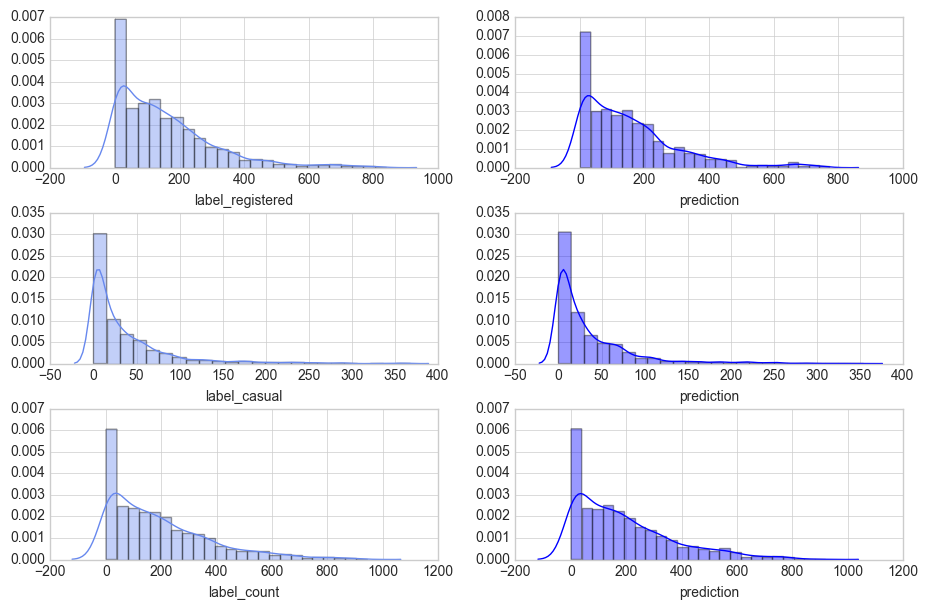

In [156]:
fig,axes= plt.subplots(nrows=3, ncols=2, figsize=(11,7))

sns.distplot(gbt_all_registered['label_registered'], bins = 24, ax=axes[0][0])
sns.distplot(gbt_all_registered['prediction'], bins = 24, ax=axes[0][1], color='blue')
sns.distplot(gbt_all_casual['label_casual'], bins = 24, ax=axes[1][0])
sns.distplot(gbt_all_casual['prediction'], bins = 24, ax=axes[1][1], color='blue')
sns.distplot(gbt_all_count['label_count'], bins = 24, ax=axes[2][0])
sns.distplot(gbt_all_count['prediction'], bins = 24, ax=axes[2][1], color='blue')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Hour category 0 and 5 has the biggest RMSLE score: 0.3315 and 0.3702 accordingly. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


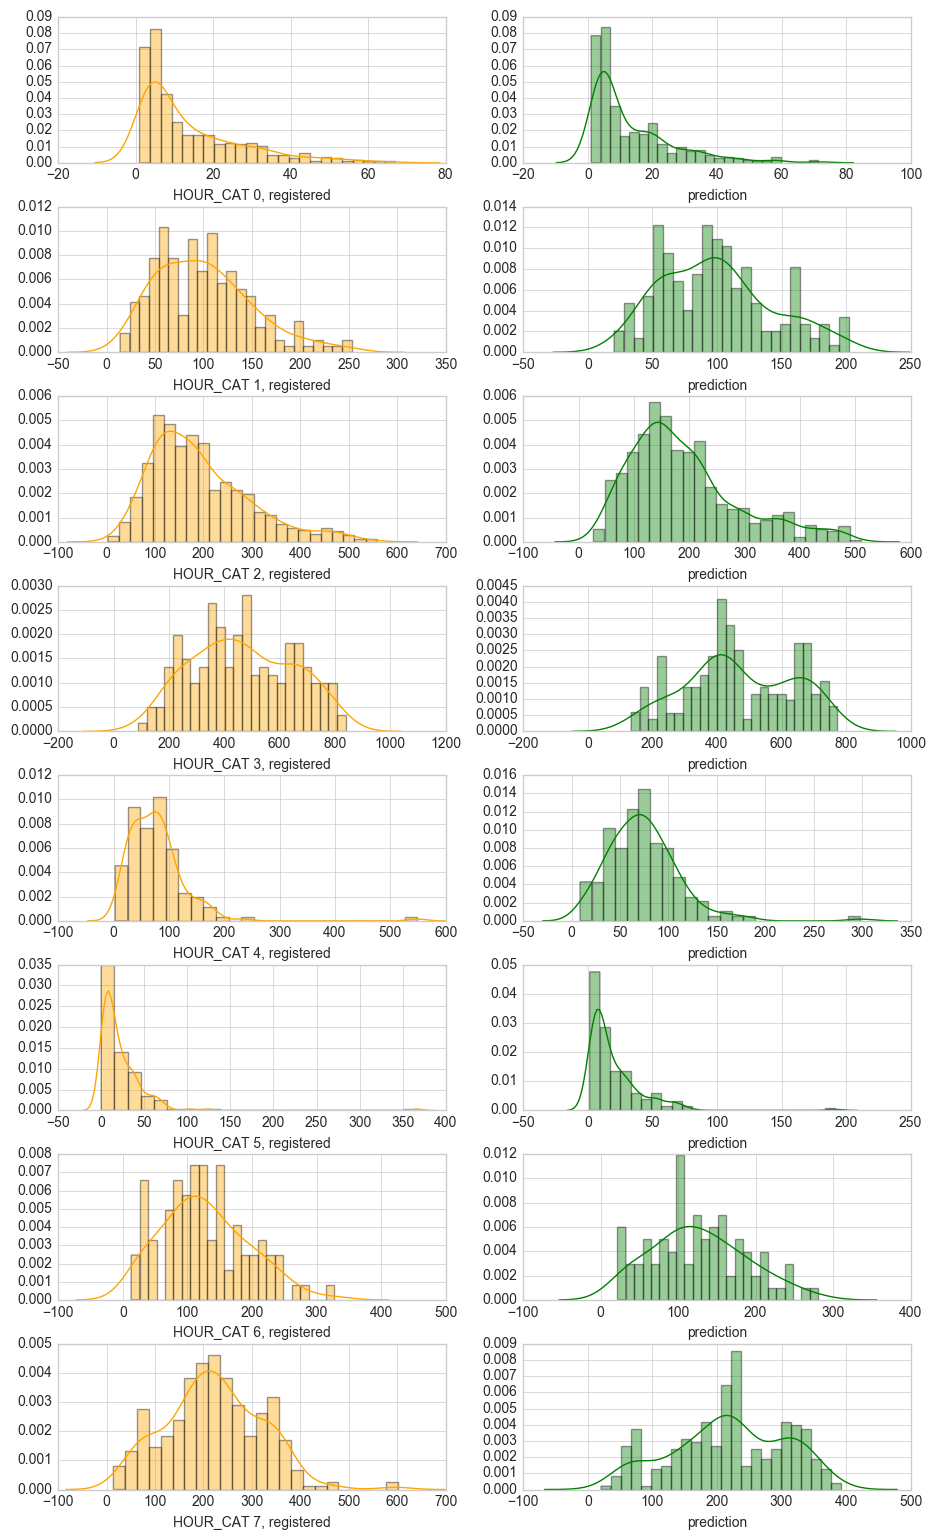

In [157]:
fig,axes= plt.subplots(nrows=8, ncols=2, figsize=(11,19))
for hour_cat in hour_cat_list:       
    sns.distplot(gbt_all_registered[gbt_all_registered['hour_cat'] == hour_cat]['label_registered'], bins = 24, ax=axes[hour_cat][0], axlabel='HOUR_CAT ' + str(hour_cat) + ', registered', color='orange')
    sns.distplot(gbt_all_registered[gbt_all_registered['hour_cat'] == hour_cat]['prediction'], bins = 24, ax=axes[hour_cat][1], color='green')
    plt.subplots_adjust(hspace = 0.3)
    plt.tight_layout

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


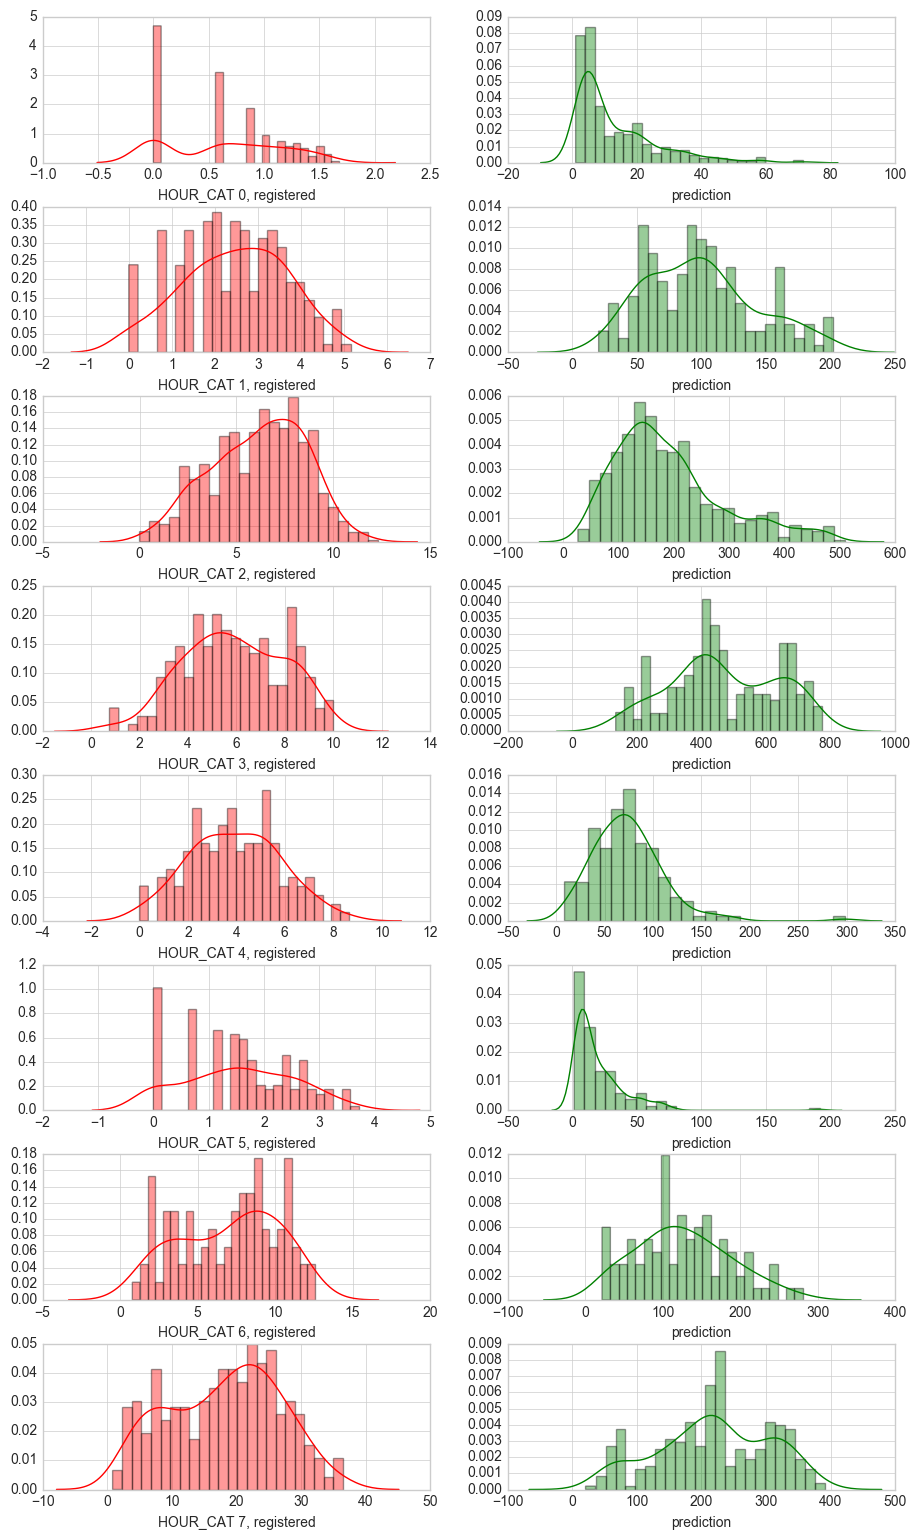

In [175]:
fig,axes= plt.subplots(nrows=8, ncols=2, figsize=(11,19))
for hour_cat in hour_cat_list:       
    sns.distplot(gbt_all_registered[gbt_all_registered['hour_cat'] == hour_cat]['label_casual'], bins = 24, ax=axes[hour_cat][0], axlabel='HOUR_CAT ' + str(hour_cat) + ', registered', color='red')
    sns.distplot(gbt_all_registered[gbt_all_registered['hour_cat'] == hour_cat]['prediction'], bins = 24, ax=axes[hour_cat][1], color='green')
    plt.subplots_adjust(hspace = 0.3)
    plt.tight_layout

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


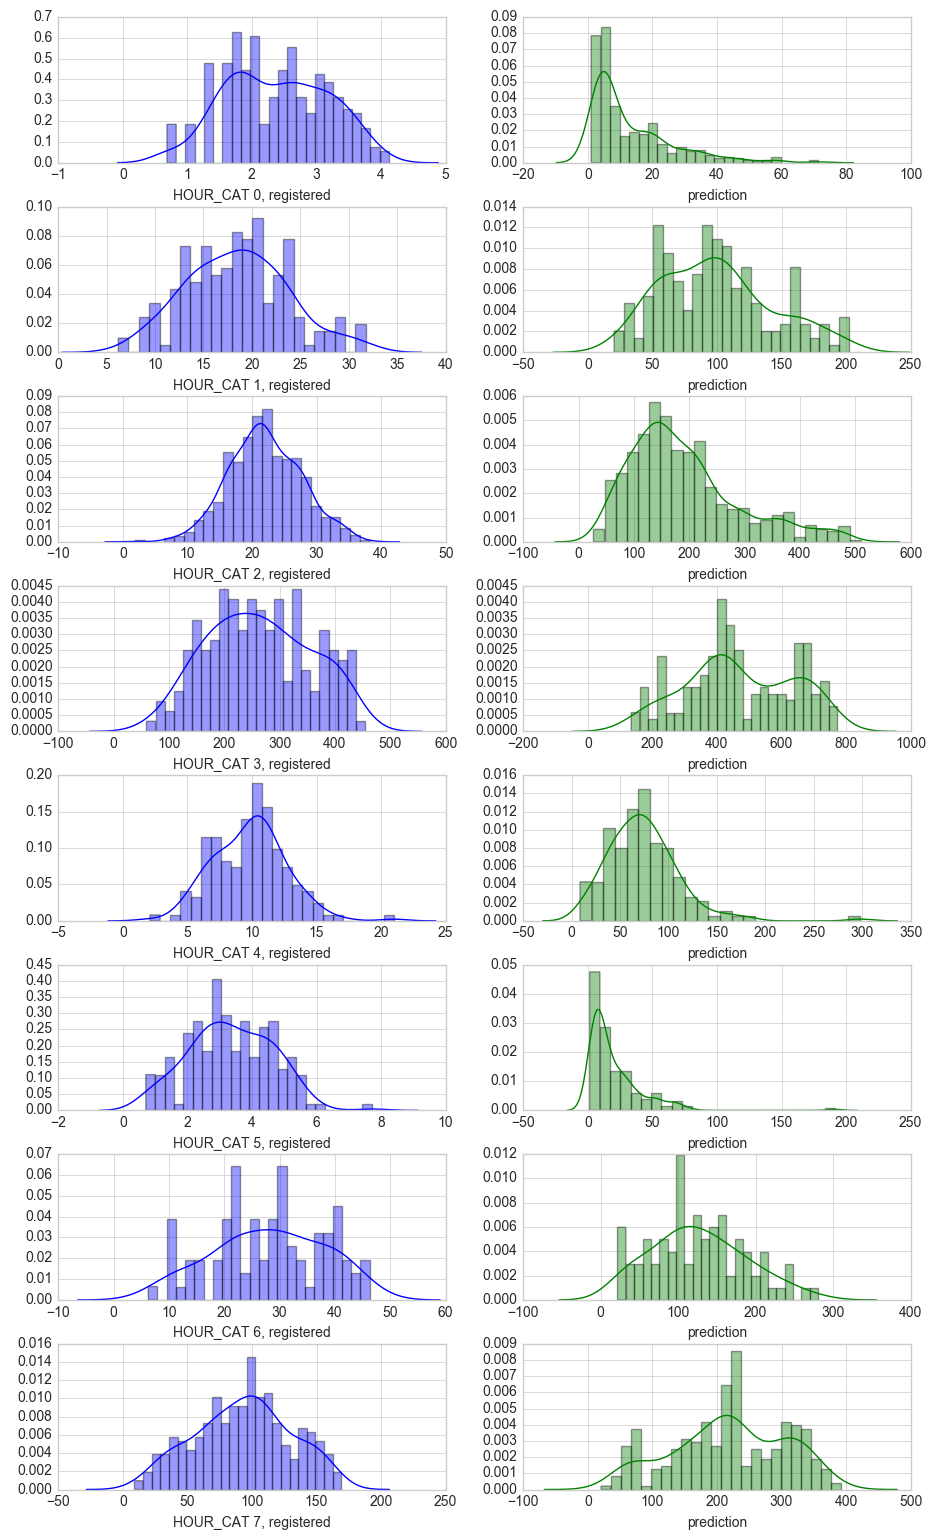

In [176]:
fig,axes= plt.subplots(nrows=8, ncols=2, figsize=(11,19))
for hour_cat in hour_cat_list:       
    sns.distplot(gbt_all_registered[gbt_all_registered['hour_cat'] == hour_cat]['label_count'], bins = 24, ax=axes[hour_cat][0], axlabel='HOUR_CAT ' + str(hour_cat) + ', registered', color='blue')
    sns.distplot(gbt_all_registered[gbt_all_registered['hour_cat'] == hour_cat]['prediction'], bins = 24, ax=axes[hour_cat][1], color='green')
    plt.subplots_adjust(hspace = 0.3)
    plt.tight_layout

<function matplotlib.pyplot.tight_layout>

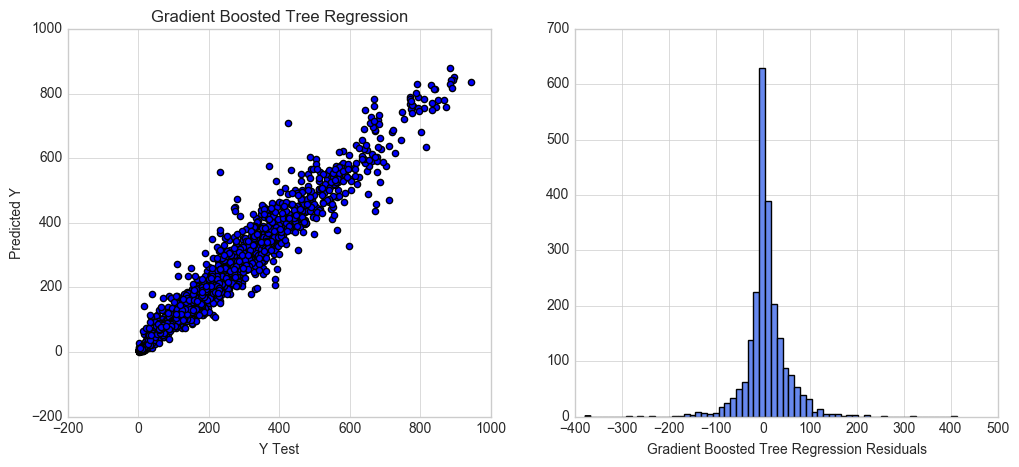

In [158]:
fig,axes= plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(gbt_all_sum['label_count'],gbt_all_sum['prediction'])
axes[0].set_xlabel('Y Test')
axes[0].set_ylabel('Predicted Y')
axes[0].set_title('Gradient Boosted Tree Regression')

axes[1].hist(rf_all_sum['label_count'] - rf_all_sum['prediction'],bins=64)
axes[1].set_xlabel('Gradient Boosted Tree Regression Residuals')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

___
# 5. Conclusion

We trained three machine learning algorithms. We used K-fold cross validation for parameter tuning. Of course we couldn't check all posibly combination due to computancy limitation. Especially Gradient Boosted Regression was hard to train becouse of its iterative manner. On the other hand it predicts very fast - this is one of the reason of its popularity (ex. for page rank cases). As we might suspect, non-linearity models gave us better results. Gradient Boosted Regression won the game with the score ** 0.2544 ** !
<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">RMSLE</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
    <th scope="row">Linear Regression</th>
    <td><div align="center">0.3366</div></td>
    <td>0.5566</td>  
    <td><div align="center">0.3454</div></td>
    <td>0.3474</td>   
  </tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><div align="center">0.3024</div></td>
    <td>0.4540</td>
    <td><div align="center">0.3086</div></td>
    <td>0.3112</td>
  </tr>
   <tr>
    <th scope="row">Gradient Boosted Regression</th>
    <td><div align="center">0.2568</div></td>
    <td>0.3954</td>
    <td><div align="center"><strong> 0.2544 </strong></div></td>
    <td>0.2577</td>
  </tr>
</table>

<br>
Training two models to predict casual and registred rentals accordingly gave us slightly better results. In all models prediction for casual users were significant worse than for registered users. It follows our understanding that there is no strict rule for renting bikes for casual users / there is some other variable, not present in our dataset, that could better model  casual renting.

RMSLE can be used when we don’t want to penalize huge differences when both the values are huge numbers, on the other hand it's harder to compare those results to others. That's why we also measured $R^2$ metric which in a way is standariezed. 

<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">$R^2$</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
    <th scope="row">Linear Regression</th>
    <td><div align="center">0.9207</div></td>
    <td>0.8718</td>
    <td><div align="center">0.9190</div></td>
    <td>0.9214</td>
  </tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><div align="center">0.9405</div></td>
    <td>0.9025</td>
    <td><div align="center">0.9396</div></td>
    <td>0.9416</td>
  </tr>
   <tr>
    <th scope="row">Gradient Boosted Regression</th>
    <td><div align="center">0.9533</div></td>
    <td>0.9374</td>
    <td><div align="center"><strong> 0.9567 </strong></div></td>
    <td>0.9540</td>
  </tr>
</table>

Depends on $R^2$ value we assume that compatibility is:
<ul>
<li>-∞ - 0,0 - unacceptable</li>
<li>0,0 - 0,5 - unsatisfactory</li>
<li>0,5 - 0,6 - weak </li>
<li>0,6 - 0,8 - satisfactory</li>
<li>0,8 - 0,9 - good</li>
<li>0,9 - 1,0 - very good</li>
</ul>

** It's worth to notice that combinig two models (for registered and casual) results in better accuracy than each of them had separately. **
<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">RMSLE</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><p style="color:#66CDAA; text-align:center">0.2568</p></td>
    <td><p style="color:#FFA500; text-align:center">0.3954</p></td>
    <td><p style="color:#32CD32; text-align:center"><strong> 0.2544 </strong></p></td>
    <td>0.2577</td>
  </tr>
</table>

** So it's good idea to combine prediction from two / three machine learning algorithms: Linear Regression, Random Forest Regression and Gradient Boosted Regression **

** We need to plot curve ratio to RMSLE to verify the split proportion for both SUM and COUNT prediction. **

In [187]:
rmsle_sum_rf_gbt = []
rmsle_count_rf_gbt = []
rmsle_sum_lr_rf = []
rmsle_count_lr_rf = []
rmsle_sum_lr_gbt = []
rmsle_count_lr_gbt = []

ratio_array = np.linspace(0.05,1,20)

for ratio in ratio_array:
    rmsle_sum_rf_gbt.append(evaluate_mixed_prediction(rf_all_sum, rf_all_count, gbt_all_sum, gbt_all_count,ratio=float(ratio))['rmsle_sum'])
    rmsle_count_rf_gbt.append(evaluate_mixed_prediction(rf_all_sum, rf_all_count, gbt_all_sum, gbt_all_count,ratio=float(ratio))['rmsle_count'])
    rmsle_sum_lr_rf.append(evaluate_mixed_prediction(lr_all_sum, lr_all_count,rf_all_sum, rf_all_count, ratio=float(ratio))['rmsle_sum'])
    rmsle_count_lr_rf.append(evaluate_mixed_prediction( lr_all_sum, lr_all_count,rf_all_sum, rf_all_count,ratio=float(ratio))['rmsle_count'])
    rmsle_sum_lr_gbt.append(evaluate_mixed_prediction(lr_all_sum, lr_all_count, gbt_all_sum, gbt_all_count,ratio=float(ratio))['rmsle_sum'])
    rmsle_count_lr_gbt.append(evaluate_mixed_prediction(lr_all_sum, lr_all_count, gbt_all_sum, gbt_all_count,ratio=float(ratio))['rmsle_count']) 

Evaluation mixed (ratio=0.05) prediction for sum of both models: registred + casual users:
R2:    0.9565
RMSLE: 0.2547

Evaluation mixed (ratio=0.05) prediction for one count users model:
R2:    0.9543
RMSLE: 0.2579
Evaluation mixed (ratio=0.05) prediction for sum of both models: registred + casual users:
R2:    0.9565
RMSLE: 0.2547

Evaluation mixed (ratio=0.05) prediction for one count users model:
R2:    0.9543
RMSLE: 0.2579
Evaluation mixed (ratio=0.05) prediction for sum of both models: registred + casual users:
R2:    0.9399
RMSLE: 0.3078

Evaluation mixed (ratio=0.05) prediction for one count users model:
R2:    0.9419
RMSLE: 0.3101
Evaluation mixed (ratio=0.05) prediction for sum of both models: registred + casual users:
R2:    0.9399
RMSLE: 0.3078

Evaluation mixed (ratio=0.05) prediction for one count users model:
R2:    0.9419
RMSLE: 0.3101
Evaluation mixed (ratio=0.05) prediction for sum of both models: registred + casual users:
R2:    0.9566
RMSLE: 0.2561

Evaluation mixed

** We can see that  split proportion around 0.3 gives us best result. **

<function matplotlib.pyplot.tight_layout>

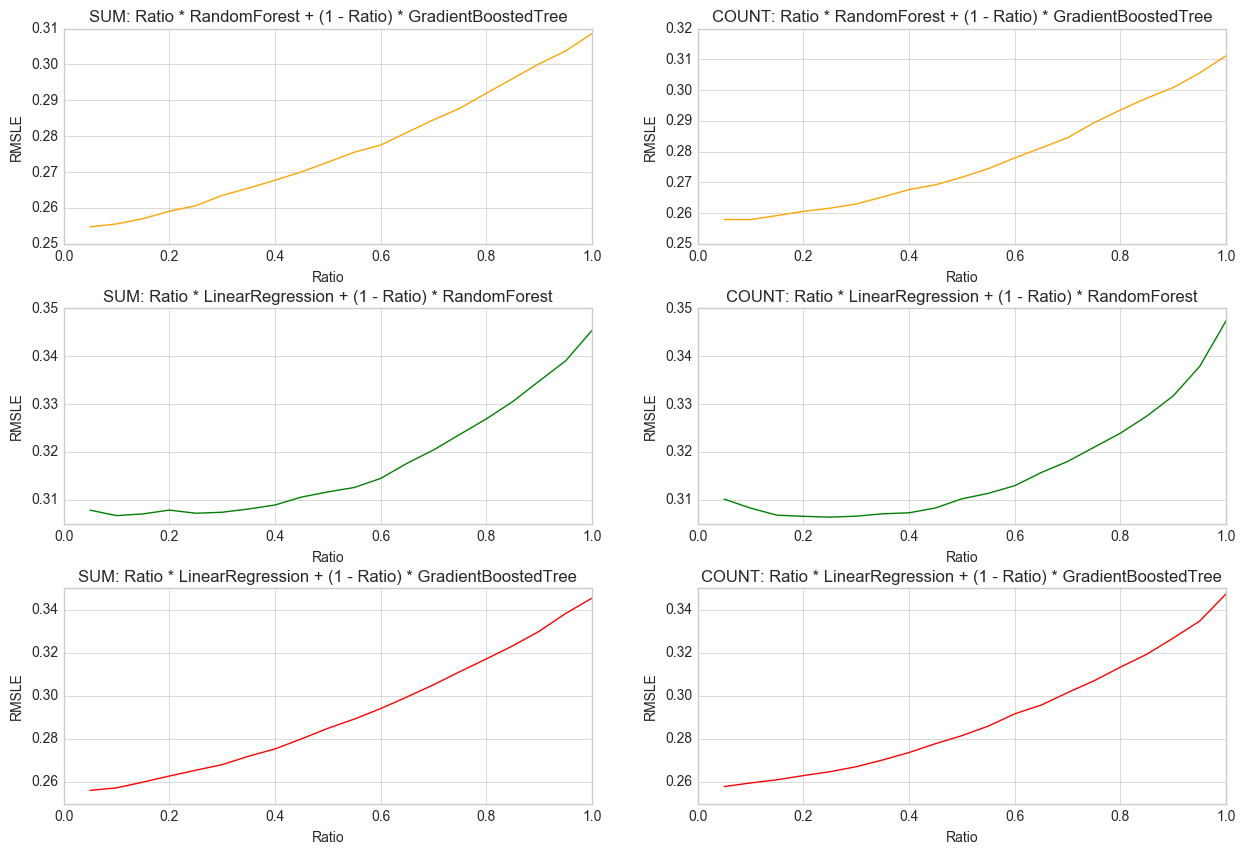

In [199]:
fig,axes= plt.subplots(nrows=3, ncols=2, figsize=(15,10))

axes[0][0].plot(ratio_array, rmsle_sum_rf_gbt, c='orange')
axes[0][0].set_xlabel('Ratio')
axes[0][0].set_ylabel('RMSLE')
axes[0][0].set_title('SUM: Ratio * RandomForest + (1 - Ratio) * GradientBoostedTree')

axes[0][1].plot(ratio_array, rmsle_count_rf_gbt, c='orange')
axes[0][1].set_xlabel('Ratio')
axes[0][1].set_ylabel('RMSLE')
axes[0][1].set_title('COUNT: Ratio * RandomForest + (1 - Ratio) * GradientBoostedTree')

axes[1][0].plot(ratio_array, rmsle_sum_lr_rf, c='green')
axes[1][0].set_xlabel('Ratio')
axes[1][0].set_ylabel('RMSLE')
axes[1][0].set_title('SUM: Ratio * LinearRegression + (1 - Ratio) * RandomForest')

axes[1][1].plot(ratio_array, rmsle_count_lr_rf, c='green')
axes[1][1].set_xlabel('Ratio')
axes[1][1].set_ylabel('RMSLE')
axes[1][1].set_title('COUNT: Ratio * LinearRegression + (1 - Ratio) * RandomForest')

axes[2][0].plot(ratio_array, rmsle_sum_lr_gbt, c='red')
axes[2][0].set_xlabel('Ratio')
axes[2][0].set_ylabel('RMSLE')
axes[2][0].set_title('SUM: Ratio * LinearRegression + (1 - Ratio) * GradientBoostedTree')

axes[2][1].plot(ratio_array, rmsle_count_lr_gbt, c='red')
axes[2][1].set_xlabel('Ratio')
axes[2][1].set_ylabel('RMSLE')
axes[2][1].set_title('COUNT: Ratio * LinearRegression + (1 - Ratio) * GradientBoostedTree')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Get the best ratio split. **

In [189]:
best_ratio = float(ratio_array[rmsle_sum_rf_gbt.index(min(rmsle_sum_rf_gbt))])
best_ratio

0.05

In [190]:
print('%.3f' % min(rmsle_sum_rf_gbt))
print('%.3f' % min(rmsle_count_rf_gbt))

0.255
0.258


** Final best  result on 'testing' data: **
### SUM -  0.255,   COUNT -  0.258

___
## 6. Predict on KAGGLE test set

### COMMENTED - predictions from best  models: Random Forest Regression and Gradient Boosted Regression Tree.
**  Although on validation set those models have best results, on Kaggle test set they have poorer results. Seems like Gradient Boosted is overfitting data. ** 

In [166]:
# predicted_Kaggle_sum_cat = {}
# predicted_Kaggle_count_cat = {}

# for hour_cat in hour_cat_list:
#     rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict[hour_cat], feature_selector_no_dummy[hour_cat], hour_cat, dummy=False, Kaggle=True)
#     gbt_predictionsTestData_r, gbt_predictionsTestData_c, gbt_predictionsTestData_count = make_prediction(gbt_cv_models_dict[hour_cat], feature_selector_no_dummy[hour_cat], hour_cat, dummy=False, Kaggle=True)
#     predicted_Kaggle_sum_cat[hour_cat] = predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, gbt_predictionsTestData_r, gbt_predictionsTestData_c, lambdas=bc_lambda_dict[hour_cat], ratio=best_ratio)
#     predicted_Kaggle_count_cat[hour_cat] = predict_count_Kaggle_test(rf_predictionsTestData_count, gbt_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat], ratio=best_ratio)

### Predictions from models: Random Forest Regression and Linear Regression.

In [191]:
predicted_Kaggle_sum_cat = {}
predicted_Kaggle_count_cat = {}

for hour_cat in hour_cat_list:
    rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict[hour_cat], feature_selector_no_dummy[hour_cat], hour_cat, dummy=False, Kaggle=True)
    lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count = make_prediction(lr_cv_models_dict[hour_cat], feature_selector_dummy[hour_cat], hour_cat, dummy=True, Kaggle=True)
    predicted_Kaggle_sum_cat[hour_cat] = predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, lr_predictionsTestData_r, lr_predictionsTestData_c, lambdas=bc_lambda_dict[hour_cat], ratio=float(0.2))
    predicted_Kaggle_count_cat[hour_cat] = predict_count_Kaggle_test(rf_predictionsTestData_count, lr_predictionsTestData_count, lambdas=bc_lambda_dict[hour_cat], ratio=float(0.2))

In [192]:
all_sum_Kaggle, all_count_Kaggle = concatenate_Kaggle_predictions(predicted_Kaggle_sum_cat, predicted_Kaggle_count_cat)

In [193]:
all_sum_Kaggle['datetime'] = pd.to_datetime(all_sum_Kaggle['datetime'])
kaggleSubmission_sum = all_sum_Kaggle.sort_values("datetime").reset_index(drop=True)

In [194]:
all_count_Kaggle['datetime'] = pd.to_datetime(all_count_Kaggle['datetime'])
kaggleSubmission_count = all_count_Kaggle.sort_values("datetime").reset_index(drop=True)

In [195]:
kaggleSubmission_sum.head()

datetime  count
0 2011-01-20 00:00:00     10
1 2011-01-20 01:00:00      5
2 2011-01-20 02:00:00      3
3 2011-01-20 03:00:00      2
4 2011-01-20 04:00:00      2

** Kaggle result: 0.44472 **

In [196]:
kaggleSubmission_count.head()

datetime  count
0 2011-01-20 00:00:00     13
1 2011-01-20 01:00:00      6
2 2011-01-20 02:00:00      3
3 2011-01-20 03:00:00      2
4 2011-01-20 04:00:00      2

** Kaggle result: 0.42860 **

In [197]:
kaggleSubmission_sum.to_csv('../data/kaggleSubmission_sum.csv', index=False)
kaggleSubmission_count.to_csv('../data/kaggleSubmission_count.csv', index=False)

## Future improvements:
** Due to computation and time limitations there are ares where additional research could be done: **
<ul>
    <li> Tune regularization of Gradient Boosted Tree Regression models to deal with overfitting. </li> 
    <li> Take a close look on predicted outliers (clearny seen on scatter plots with predictions vs labels). </li>
    <li> Make more / less hour categories and more separate models to better minimize RMSLE for hours with very few bike rentals. RMSLE metric hurts relatively more when the numbers are smaller. </li>
    <li> Try different ratio split on Random Forest Regression / Linear Regression / Gradient Boosted Regression Tree to tune the final result (there is limitation of submissions per day) </li>
    <li> Try another kind of interpolation, set different threshold for outliers  </li>
    <li> Use another tool for feature selection - ex. mutual info </li>
    <li> Make PCA analysis to reduce number of features </li>
    <li> Make greater GridSearch for better model tuning (requires high computation perfomance, ex. on AWS EMR clusters) </li>
    <li> Use another regression models like Deep Neural Networks for regression </li>
    <li> Use sckit-learn instead of Apache Spark ML (difference on algorithms implementations). </li>
</ul>

# Final result from Kaggle submission is <p style="color:red"><strong> 0.42860</strong></p> <br> 